# CIFAR-10 데이터 분류 모델

* The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. * There are 50000 training images and 10000 test images.

* The dataset is divided into five training batches and one test batch, each with 10000 images. 
* The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. 
* Between them, the training batches contain exactly 5000 images from each class.

In [1]:
import time
import os
import sys
from datetime import datetime

import pandas as pd
import platform
import io

from matplotlib.pyplot import cm

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torchvision

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm import tqdm
from omegaconf import OmegaConf
from omegaconf import DictConfig
import hydra
from hydra.core.config_store import ConfigStore

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch_optimizer import RAdam
from torch_optimizer import AdamP
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split
from torchvision import transforms

import skimage.transform
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

import wandb

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 스플릿 용 외부 함수
from data_utils import dataset_split

In [3]:
torch.__version__

'1.7.1+cu110'

In [4]:
# check if cuda is available
cuda = torch.cuda.is_available()
print(cuda)

True


In [5]:
transform = transforms.Compose(
    [
        # torch에서 사용하기 위해 변환
        transforms.ToTensor(),
        # 데이터 셋 정규화
        transforms.Normalize([0.5], [0.5]), # mean, # std
    ]
)

In [6]:
train_dataset = CIFAR10(root='.',
                        train=True,
                        transform=transform,
                        download=True)

test_dataset  = CIFAR10(root='.',
                        train=False,
                        transform=transform,)

Files already downloaded and verified


### 데이터 셋 확인하기

In [7]:
# meta data
data_batch_1 = pd.read_pickle(r'./cifar-10-batches-py/data_batch_1')
meta_data = pd.read_pickle(r'./cifar-10-batches-py/batches.meta')

In [8]:
print(data_batch_1.keys())
print(meta_data.keys())

dict_keys(['batch_label', 'labels', 'data', 'filenames'])
dict_keys(['num_cases_per_batch', 'label_names', 'num_vis'])


In [9]:
# 레이블 확인(타겟 변수)
batch_1_df = pd.DataFrame(data_batch_1['labels'], columns = ['labels'])
batch_1_df

,labels
0,6
1,9
2,9
3,4
4,1
...,...
9995,3
9996,9
9997,1
9998,1


In [10]:
# 유일한 종류만 가져와서 저장(레이블 인코딩)
one_hot_labels = batch_1_df['labels'].unique()
one_hot_labels = np.sort(one_hot_labels)
print(one_hot_labels)

[0 1 2 3 4 5 6 7 8 9]


In [11]:
# label 이름 확인
labels_name = meta_data['label_names']
labels_name

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [12]:
# labels
label_dict = {k:v for k,v in zip(one_hot_labels, labels_name)}
label_dict

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [13]:
label_dict.get(0)

'airplane'

### 데이터 셋 시각화
* README 처럼 10000개씩 5개 배치의 train 데이터, 10000개의 test 데이터로 나누어져있다.

In [14]:
# 데이터 shape 확인
train_data = list(train_dataset)
test_data  = list(test_dataset)
print(f'Train data shape: {len(train_data)}')
print(f'Test data shape:  {len(test_data)}')

Train data shape: 50000
Test data shape:  10000


In [15]:
data_batch = list()
for i in range(5):
    data = pd.read_pickle(r'./cifar-10-batches-py/data_batch_{}'.format(i+1))
    data_df = pd.DataFrame(data['labels'], columns = ['labels'])
    data_batch.append(data_df)
data = pd.read_pickle(r'./cifar-10-batches-py/test_batch')
data_df = pd.DataFrame(data['labels'], columns = ['labels'])
data_batch.append(data_df)

df = data_batch[0]
for i in range(5):
    df = pd.concat([df, data_batch[i+1]])

df.shape

(60000, 1)

In [16]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
df['class'] = [labels[i] for i in df['labels']]
df['train_val'] = "Train"
df['train_val'].iloc[50001:60000] = "Test"
df.head()

,labels,class,train_val
0,6,Frog,Train
1,9,Truck,Train
2,9,Truck,Train
3,4,Deer,Train
4,1,Automobile,Train


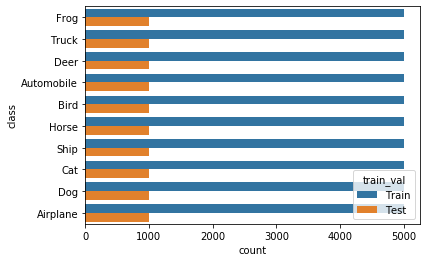

In [17]:
sns.countplot(y="class", data=df, hue='train_val')

* 32 x 32 크기의 3채널로 이루어진 RGB 데이터 셋

In [18]:
# 이미지의 사이즈와 클래스 확인
image, label = train_data[100]
print(image.shape)
print(label)

torch.Size([3, 32, 32])
8


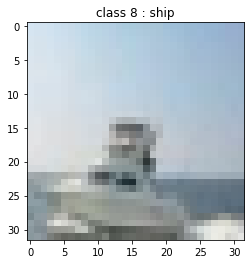

In [19]:
# 사진 확인
img, label = train_data[100]

img = img / 2 + 0.5
img = img.numpy()
plt.imshow(np.transpose(img, (1, 2, 0)))  # (3, 32, 32) -> (32, 32, 3)
plt.title('class {} : {}'.format(label, label_dict.get(label)))

plt.show()

## 모델 구현

### DataLoader 정의

딥러닝의 학습안정화가 잘 안되던 예전에는 batch size를 작게하는게 의외의 효과를 불러왔습니다. batch size가 클수록 많은 train data를 한번에 학습하기 때문에 더욱 정확한 gradient를 계산해서 cost function이 오히려 local minimum으로 수렴 되는 경우가 많았습니다. 그런데 batch size가 작으면 부정확한 gradient가 계산되어 cost function 공간에서 오히려 local minimum을 뛰어넘는 의외의 장점(?)을 가지게 되었습니다.

하지만 요즘엔 Adam optimizer나 batch normalization(BN)등의 기법을 사용함으로써 학습안정화가 정말 잘 되는 네트워크가 많습니다. 따라서 batch size가 커도 local minimum을 잘 지나쳐 global minimum으로 수렴할 수 있게되었습니다. 따라서 최근에는 batch size를 줄 수 있는만큼 최대한 크게줘야 좋다고 할 수 있습니다. batch size가 클수록 BN을 더욱 정확하게 계산할 수 있어 BN의 효과를 더욱 잘 누릴 수 있게되고 그렇게 되면 학습속도가 빨라지며 learning rate의 hyper parameter 설정에서 꽤나 자유로워질 수 있게됩니다.

https://velog.io/@garam/Batch-size%EB%8A%94-%ED%81%AC%EB%A9%B4%EC%A2%8B%EC%9D%84%EA%B9%8C-%EC%9E%91%EC%9C%BC%EB%A9%B4-%EC%A2%8B%EC%9D%84%EA%B9%8C

In [29]:
datasets = dataset_split(train_dataset, split=[0.9, 0.1])

train_dataset = datasets["train"]
val_dataset = datasets["val"]

train_batch_size = 64         # hyper-parameter 
val_batch_size = 16

train_dataloader = torch.utils.data.DataLoader(
                            dataset = train_dataset, 
                            batch_size = train_batch_size, 
                            shuffle = True,
                            num_workers=0  # 병렬 프로세싱 용
)

val_dataloader = torch.utils.data.DataLoader(
                            dataset = val_dataset, 
                            batch_size = val_batch_size, 
                            shuffle = False,
                            num_workers = 0
)

In [30]:
print(len(train_dataloader)*64)
print(len(val_dataloader)*16)

45056
5008


In [22]:
for sample_batch in train_dataloader:
    print(sample_batch)
    print(sample_batch[0].shape, sample_batch[1].shape)
    break

[tensor([[[[ 0.9922,  0.9922,  0.9686,  ...,  0.8980,  0.9529,  0.9922],
          [ 0.9765,  0.9451,  0.8745,  ...,  0.7882,  0.8980,  0.9686],
          [ 0.9373,  0.8510,  0.7490,  ...,  0.7098,  0.7725,  0.9137],
          ...,
          [ 0.8745,  0.5843,  0.2235,  ...,  0.3176,  0.6627,  0.9451],
          [ 0.9451,  0.8196,  0.5765,  ...,  0.5608,  0.8353,  0.9608],
          [ 0.9843,  0.9529,  0.8745,  ...,  0.8745,  0.9294,  0.9765]],

         [[ 0.9922,  0.9922,  0.9765,  ...,  0.9059,  0.9608,  0.9922],
          [ 0.9765,  0.9529,  0.8902,  ...,  0.8039,  0.9059,  0.9686],
          [ 0.9373,  0.8588,  0.7725,  ...,  0.7412,  0.7882,  0.9216],
          ...,
          [ 0.8510,  0.5059,  0.0980,  ...,  0.1765,  0.5922,  0.9294],
          [ 0.9373,  0.7725,  0.4980,  ...,  0.4588,  0.7961,  0.9608],
          [ 0.9843,  0.9451,  0.8510,  ...,  0.8353,  0.9216,  0.9843]],

         [[ 0.9922,  0.9765,  0.9529,  ...,  0.8588,  0.9451,  0.9922],
          [ 0.9608,  0.9059, 

### CNN 모델 정의

In [53]:
_cnn_cfg_dict: dict = {
    "layer_1": {
        "conv2d_in_channels": 3,
        "conv2d_out_channels": 64,
        "conv2d_kernel_size": 3,
        "conv2d_padding": 1,
        "maxpool2d_kernel_size": 2,
        "maxpool2d_stride": 2,
    },
    "layer_2": {
        "conv2d_in_channels": 64,
        "conv2d_out_channels": 128,
        "conv2d_kernel_size": 3,
        "conv2d_padding": 1,
        "maxpool2d_kernel_size": 2,
        "maxpool2d_stride": 2,
    },
    "layer_3": {
        "conv2d_in_channels": 128,
        "conv2d_out_channels": 256,
        "conv2d_kernel_size": 3,
        "conv2d_padding": 1,
        "maxpool2d_kernel_size": 2,
        "maxpool2d_stride": 2,
    },
    "layer_4": {
        "conv2d_in_channels": 256,
        "conv2d_out_channels": 512,
        "conv2d_kernel_size": 3,
        "conv2d_padding": 1,
        "maxpool2d_kernel_size": 2,
        "maxpool2d_stride": 2,
    },
    "layer_5": {
        "conv2d_in_channels": 512,
        "conv2d_out_channels": 512,
        "conv2d_kernel_size": 3,
        "conv2d_padding": 1,
        "maxpool2d_kernel_size": 2,
        "maxpool2d_stride": 2,
    },
    "fc_1": {
        "in_features": 512,
        "out_features": 128,
    },
    "fc_2": {
        "in_features": 128,
        "out_features": 10,        
    },
    "dropout_prob": 0.25,
}
    
# 하이퍼파라미터 config를 다루는 라이브러리 => Hydra
_cnn_cfg = OmegaConf.create(_cnn_cfg_dict)
print(OmegaConf.to_yaml(_cnn_cfg))

class CNN(nn.Module):
    def __init__(self, cfg: DictConfig = _cnn_cfg):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=cfg.layer_1.conv2d_in_channels,
                out_channels=cfg.layer_1.conv2d_out_channels,
                kernel_size=cfg.layer_1.conv2d_kernel_size,
                padding=cfg.layer_1.conv2d_padding
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=cfg.layer_1.conv2d_out_channels,
                out_channels=cfg.layer_1.conv2d_out_channels,
                kernel_size=cfg.layer_1.conv2d_kernel_size,
                padding=cfg.layer_1.conv2d_padding
            ),
            nn.BatchNorm2d(cfg.layer_1.conv2d_out_channels),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=cfg.layer_2.conv2d_in_channels,
                out_channels=cfg.layer_2.conv2d_out_channels,
                kernel_size=cfg.layer_2.conv2d_kernel_size,
                padding=cfg.layer_2.conv2d_padding
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=cfg.layer_2.conv2d_out_channels,
                out_channels=cfg.layer_2.conv2d_out_channels,
                kernel_size=cfg.layer_2.conv2d_kernel_size,
                padding=cfg.layer_2.conv2d_padding
            ),
            nn.BatchNorm2d(cfg.layer_2.conv2d_out_channels),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=cfg.layer_2.maxpool2d_kernel_size,
                stride=cfg.layer_2.maxpool2d_stride
            )
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(
                in_channels=cfg.layer_3.conv2d_in_channels,
                out_channels=cfg.layer_3.conv2d_out_channels,
                kernel_size=cfg.layer_3.conv2d_kernel_size,
                padding=cfg.layer_3.conv2d_padding
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=cfg.layer_3.conv2d_out_channels,
                out_channels=cfg.layer_3.conv2d_out_channels,
                kernel_size=cfg.layer_3.conv2d_kernel_size,
                padding=cfg.layer_3.conv2d_padding
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=cfg.layer_3.conv2d_out_channels,
                out_channels=cfg.layer_3.conv2d_out_channels,
                kernel_size=cfg.layer_3.conv2d_kernel_size,
                padding=cfg.layer_3.conv2d_padding
            ),
            nn.ReLU(),
            nn.BatchNorm2d(cfg.layer_3.conv2d_out_channels),
            nn.ReLU(),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(
                in_channels=cfg.layer_4.conv2d_in_channels,
                out_channels=cfg.layer_4.conv2d_out_channels,
                kernel_size=cfg.layer_4.conv2d_kernel_size,
                padding=cfg.layer_4.conv2d_padding
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=cfg.layer_4.conv2d_out_channels,
                out_channels=cfg.layer_4.conv2d_out_channels,
                kernel_size=cfg.layer_4.conv2d_kernel_size,
                padding=cfg.layer_4.conv2d_padding
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=cfg.layer_4.conv2d_out_channels,
                out_channels=cfg.layer_4.conv2d_out_channels,
                kernel_size=cfg.layer_4.conv2d_kernel_size,
                padding=cfg.layer_4.conv2d_padding
            ),
            nn.ReLU(),
            nn.BatchNorm2d(cfg.layer_4.conv2d_out_channels),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=cfg.layer_4.maxpool2d_kernel_size,
                stride=cfg.layer_4.maxpool2d_stride
            )
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(
                in_channels=cfg.layer_5.conv2d_in_channels,
                out_channels=cfg.layer_5.conv2d_out_channels,
                kernel_size=cfg.layer_5.conv2d_kernel_size,
                padding=cfg.layer_5.conv2d_padding
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=cfg.layer_5.conv2d_out_channels,
                out_channels=cfg.layer_5.conv2d_out_channels,
                kernel_size=cfg.layer_5.conv2d_kernel_size,
                padding=cfg.layer_5.conv2d_padding
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=cfg.layer_5.conv2d_out_channels,
                out_channels=cfg.layer_5.conv2d_out_channels,
                kernel_size=cfg.layer_5.conv2d_kernel_size,
                padding=cfg.layer_5.conv2d_padding
            ),
            nn.ReLU(),
            nn.BatchNorm2d(cfg.layer_5.conv2d_out_channels),
            nn.ReLU(),
        )
        self.avg_pool = nn.AvgPool2d(7)
        self.fc1 = nn.Linear(
            in_features=cfg.fc_1.in_features,
            out_features=cfg.fc_1.out_features,
        )
        self.dropout = nn.Dropout2d(cfg.dropout_prob)
        self.fc2 = nn.Linear(
            in_features=cfg.fc_2.in_features,
            out_features=cfg.fc_2.out_features,
        )
        

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        features = self.layer5(out)
        out = self.avg_pool(features)
        out = out.view(features.size(0), -1)
        
        out = self.fc1(out)
        out = self.dropout(out)
#         print(out.size(1))  # 파라미터 개수 확인
        out = self.fc2(out)
#         out = self.fc1(out)
#         out = self.fc2(out)
#         out = self.fc3(out)
        return  out, features

cnn = CNN(cfg=_cnn_cfg)
param = list(cnn.parameters())
print(len(param))
for i in param:
    print(i.shape)

layer_1:
  conv2d_in_channels: 3
  conv2d_out_channels: 64
  conv2d_kernel_size: 3
  conv2d_padding: 1
  maxpool2d_kernel_size: 2
  maxpool2d_stride: 2
layer_2:
  conv2d_in_channels: 64
  conv2d_out_channels: 128
  conv2d_kernel_size: 3
  conv2d_padding: 1
  maxpool2d_kernel_size: 2
  maxpool2d_stride: 2
layer_3:
  conv2d_in_channels: 128
  conv2d_out_channels: 256
  conv2d_kernel_size: 3
  conv2d_padding: 1
  maxpool2d_kernel_size: 2
  maxpool2d_stride: 2
layer_4:
  conv2d_in_channels: 256
  conv2d_out_channels: 512
  conv2d_kernel_size: 3
  conv2d_padding: 1
  maxpool2d_kernel_size: 2
  maxpool2d_stride: 2
layer_5:
  conv2d_in_channels: 512
  conv2d_out_channels: 512
  conv2d_kernel_size: 3
  conv2d_padding: 1
  maxpool2d_kernel_size: 2
  maxpool2d_stride: 2
fc_1:
  in_features: 512
  out_features: 128
fc_2:
  in_features: 128
  out_features: 10
dropout_prob: 0.25

40
torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([6

### Learning Rate Scheduler

In [48]:
# Warmup Scheduler
class WarmupLR(optim.lr_scheduler.LambdaLR):

    def __init__(
        self,
        optimizer: optim.Optimizer,
        warmup_end_steps: int,
        last_epoch: int = -1,
    ):
        
        def wramup_fn(step: int):
            if step < warmup_end_steps:
                return float(step) / float(max(warmup_end_steps, 1))
            return 1.0
        
        super().__init__(optimizer, wramup_fn, last_epoch)

### Loss Function 디자인
#### KL-divergence 쿨백-라이블러 발산

> 쿨백-라이블러 발산(Kullback–Leibler divergence, KLD)은 두 확률분포의 차이를 계산하는 데에 사용하는 함수로, 어떤 이상적인 분포에 대해, 그 분포를 근사하는 다른 분포를 사용해 샘플링을 한다면 발생할 수 있는 정보 엔트로피 차이를 계산한다. 상대 엔트로피(relative entropy), 정보 획득량(information gain), 인포메이션 다이버전스(information divergence)라고도 한다.

Cross entropy는 negative log likelihood와 같습니다. 그래서 cross entropy를 minimize하는 것이 log likelihood를 maximize하는 것과 같습니다. 그리고 확률분포 p,q​에 대한 cross entropy는 H(p)+KL(p|q)​ 이므로 KL-divergence를 minimize하는 것 또한 결국 log likelihood를 maximize하는 것과 같습니다.

=> 추정치가 데이터와 잘 맞는다 = 피쳐끼리 더 잘 뭉쳐진다

https://hyunw.kim/blog/2017/10/27/KL_divergence.html

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.manifold import TSNE
from sklearn import metrics

# define loss
loss_function = nn.CrossEntropyLoss()

def my_loss(f, labels):
    standardized_scalar = StandardScaler()
    standardized_data = standardized_scalar.fit_transform(f)

    n_components = 2
    tsne = TSNE(n_components=n_components)
    tsne_data = tsne.fit_transform(standardized_data)

    tsne_data = np.vstack((tsne_data.T, labels)).T
    df_tsne = pd.DataFrame(tsne_data, columns=["f1", "f2", "labels"])

    dbs = metrics.davies_bouldin_score(df_tsne.iloc[:,:-1], df_tsne['labels'])
    
    return -0.1 * (1 / dbs)

#     if dbs < 4:
#         return -0.1 * (1 / dbs)
#     else:
#         return 0.01 * dbs

### 모델 선언 및 손실 함수, 최적화(Optimizer) 정의, Tensorboard Logger 정의

In [54]:
# gpu setup
# gpu = None
gpu = 0

# define model
model = CNN(cfg=_cnn_cfg)
if gpu is not None:
     model.cuda(gpu)
model_name = type(model).__name__

# define optimizer
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = RAdam(model.parameters(), lr=lr)
# optimizer = AdamP(model.parameters(), lr=lr)
optimizer_name = type(optimizer).__name__

# define scheduler
# scheduler = None
scheduler = WarmupLR(optimizer, 1500)
scheduler_name = type(scheduler).__name__ if scheduler is not None else "no"

# define max number of epoch
max_epoch = 3

# define tensorboard logger
run_name = f"{datetime.now().isoformat(timespec='seconds')}-{model_name}-{optimizer_name}_optim_{lr}_lr_with_{scheduler_name}_scheduler"
run_name = run_name.replace(':', '')
run_dirname = "TestModel"
log_dir = os.path.join("runs", run_dirname, run_name)
writer = SummaryWriter(log_dir=log_dir)
log_interval = 100

# define wandb
project_name = "TestModel"
run_tags = [project_name]
wandb.init(
    project=project_name,
    name=run_name,
    tags=run_tags,
    config={"lr": lr, "model_name": model_name, "optimizer_name": optimizer_name, "scheduler_name": scheduler_name},
    reinit=True,
)
wandb.watch(model)

# set save model path
log_model_path = os.path.join(log_dir, "models")
os.makedirs(log_model_path, exist_ok=True)
yaml_path = os.path.join(log_dir, "cnn_test.yaml")
with open(yaml_path, 'w') as f:
    OmegaConf.save(_cnn_cfg, f)


### Early Stopping callback Object Class 정의

In [51]:
# 오픈소스 Early Stopping Callback Object 클래스 가져와서 수정
# With some modifications, source is from https://github.com/Bjarten/early-stopping-pytorch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.ckpt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.ckpt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss
        
        # best score가 최대일 때(loss가 최소일 때 저장)
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True  # 나아지지 않으면 Stop
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        
        # Stop한 model 저장
        filename = self.path.split('\\')[-1]
        save_dir = os.path.dirname(self.path)
        torch.save(model, os.path.join(save_dir, f"val_loss-{val_loss}-{filename}"))
        self.val_loss_min = val_loss

## 학습

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /runs/TestModel/

# define EarlyStopping.
early_stopper = EarlyStopping(
    patience=3, verbose=True, path=os.path.join(log_model_path, "model.ckpt")
)

# do train with validation.
train_step = 0
for epoch in range(1, max_epoch+1):
    # valid step
    # valid를 먼저 놓는 이유: 디버깅이 편하다.
    # validation data에 대해 oprimizer가 업데이트를 안하도록 보장
    val_f = np.array([[]])
    val_label = np.array([[]])
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        model.eval()

        for val_batch_idx, (val_images, val_labels) in enumerate(
            # tqdm: 진행률 프로세스 바
            tqdm(val_dataloader, position=0, leave=True, desc="validation")
        ):
            if val_batch_idx == 312:
                break
                
            if gpu is not None:
                val_images = val_images.cuda(gpu, non_blocking=True)
                val_labels = val_labels.cuda(gpu, non_blocking=True)
            # forward
            val_outputs, f = model(val_images)
            _, val_preds = torch.max(val_outputs, 1)
            
            dbs = my_loss(f.reshape(16, 32768).detach().cpu().numpy(), val_labels.detach().cpu().numpy())
            
            val_loss += (loss_function(val_outputs, val_labels) + dbs) / val_outputs.shape[0]
            val_corrects += torch.sum(val_preds == val_labels.data) / val_outputs.shape[0]
            
            if val_batch_idx == 308:
                val_f = f.reshape(16, 32768).detach().cpu().numpy()
                val_label = val_labels.detach().cpu().numpy()
            elif val_batch_idx > 308 and val_batch_idx < 312:
                val_f = np.vstack([val_f, f.reshape(16, 32768).detach().cpu().numpy()])
                val_label = np.hstack([val_label, val_labels.detach().cpu().numpy()])

    # valid step logging
    val_epoch_loss = val_loss / len(val_dataloader)
    val_epoch_acc = val_corrects / len(val_dataloader)
    
    print(
        f"{epoch} epoch, {train_step} step: val_loss: {val_epoch_loss}, val_acc: {val_epoch_acc}"
    )

    # tensorboard log
    writer.add_scalar("Loss/val", val_epoch_loss, train_step)
    writer.add_scalar("Acc/val", val_epoch_acc, train_step)
    writer.add_images("Images/val", val_images, train_step)

    # wandb log
    wandb.log({
        "Loss/val": val_epoch_loss,
        "Acc/val": val_epoch_acc,
        "Images/val": wandb.Image(val_images),
        "Outputs/val": wandb.Histogram(val_outputs.detach().cpu().numpy()),
        "Preds/val": wandb.Histogram(val_preds.detach().cpu().numpy()),
        "Labels/val": wandb.Histogram(val_labels.data.detach().cpu().numpy()),
    }, step=train_step)

    # check model early stopping point & save model if the model reached the best performance.
    early_stopper(val_epoch_loss, model)
    if early_stopper.early_stop:
        break
    
    # train step
    current_loss = 0
    current_corrects = 0
    model.train()
    
    for batch_idx, (images, labels) in enumerate(
         tqdm(train_dataloader, position=0, leave=True, desc="training")
    ):
        if batch_idx == 703:
            break
        
        if gpu is not None:
            images = images.cuda(gpu)
            labels = labels.cuda(gpu)

        current_loss = 0.0
        current_corrects = 0

        # Forward
        # get predictions
        outputs, f = model(images)
        _, preds = torch.max(outputs, 1)
        
        # get loss (Loss 계산)
        loss = loss_function(outputs, labels)
        dbs = my_loss(f.reshape(64, 32768).detach().cpu().numpy(), labels.detach().cpu().numpy())
        loss = loss + dbs
        
        # Backpropagation
        # optimizer 초기화 (zero화)
        optimizer.zero_grad()

        # Perform backward pass
        loss.backward()

        # Perform Optimization
        optimizer.step()

        # Perform LR scheduler Work
        if scheduler is not None:
            scheduler.step()

        current_loss += loss.item()
        
        current_corrects += torch.sum(preds == labels.data)

        if train_step % log_interval == 0:
            train_loss = current_loss / log_interval
            train_acc = current_corrects / log_interval
            dbs = my_loss(f.reshape(64, 32768).detach().cpu().numpy(), labels.detach().cpu().numpy())
            print(dbs)

            print(
                f"{train_step}: train_loss: {train_loss}, train_acc: {train_acc}"
            )
            
            cur_lr = optimizer.param_groups[0]["lr"] if scheduler is None else scheduler.get_last_lr()[0]                

            # tensorboard log
            writer.add_scalar("Loss/train", train_loss, train_step)
            writer.add_scalar("Acc/train", train_acc, train_step)
            writer.add_images("Images/train", images, train_step)
            writer.add_scalar("Learning Rate", cur_lr, train_step)
            writer.add_graph(model, images)

            # wandb log
            wandb.log({
                "Loss/train": train_loss,
                "Acc/train": train_acc,
                "Images/train": wandb.Image(images),
                "Outputs/train": wandb.Histogram(outputs.detach().cpu().numpy()),
                "Preds/train": wandb.Histogram(preds.detach().cpu().numpy()),
                "Labels/train": wandb.Histogram(labels.data.detach().cpu().numpy()),
                "Learning Rate": cur_lr,
            }, step=train_step)

            current_loss = 0
            current_corrects = 0

        train_step += 1

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 25228), started 2 days, 1:02:48 ago. (Use '!kill 25228' to kill it.)

validation:   0%|                                                                              | 0/313 [00:00<?, ?it/s]

128


validation:   1%|▍                                                                     | 2/313 [00:00<01:01,  5.03it/s]

128
128


validation:   1%|▋                                                                     | 3/313 [00:00<00:58,  5.30it/s]

128


validation:   1%|▉                                                                     | 4/313 [00:00<01:04,  4.78it/s]

128


validation:   2%|█                                                                     | 5/313 [00:01<01:10,  4.36it/s]

128


validation:   2%|█▌                                                                    | 7/313 [00:01<01:08,  4.48it/s]

128
128


validation:   3%|██                                                                    | 9/313 [00:02<01:08,  4.41it/s]

128
128


validation:   3%|██▏                                                                  | 10/313 [00:02<01:10,  4.29it/s]

128


validation:   4%|██▍                                                                  | 11/313 [00:02<01:09,  4.35it/s]

128


validation:   4%|██▋                                                                  | 12/313 [00:02<01:07,  4.48it/s]

128


validation:   4%|███                                                                  | 14/313 [00:03<01:11,  4.20it/s]

128


validation:   5%|███▎                                                                 | 15/313 [00:03<01:07,  4.40it/s]

128
128


validation:   5%|███▌                                                                 | 16/313 [00:03<01:07,  4.39it/s]

128


validation:   5%|███▋                                                                 | 17/313 [00:03<01:09,  4.28it/s]

128


validation:   6%|████▏                                                                | 19/313 [00:04<01:07,  4.33it/s]

128
128


validation:   6%|████▍                                                                | 20/313 [00:04<01:07,  4.36it/s]

128


validation:   7%|████▋                                                                | 21/313 [00:04<01:09,  4.17it/s]

128


validation:   7%|█████                                                                | 23/313 [00:05<01:03,  4.59it/s]

128
128


validation:   8%|█████▎                                                               | 24/313 [00:05<00:59,  4.89it/s]

128


validation:   8%|█████▋                                                               | 26/313 [00:05<00:57,  4.95it/s]

128
128


validation:   9%|█████▉                                                               | 27/313 [00:06<01:02,  4.57it/s]

128


validation:   9%|██████▏                                                              | 28/313 [00:06<01:10,  4.04it/s]

128


validation:   9%|██████▍                                                              | 29/313 [00:06<01:20,  3.51it/s]

128


validation:  10%|██████▌                                                              | 30/313 [00:07<01:23,  3.40it/s]

128


validation:  10%|██████▊                                                              | 31/313 [00:07<01:25,  3.29it/s]

128


validation:  10%|███████                                                              | 32/313 [00:07<01:20,  3.51it/s]

128


validation:  11%|███████▎                                                             | 33/313 [00:07<01:17,  3.60it/s]

128


validation:  11%|███████▍                                                             | 34/313 [00:08<01:19,  3.51it/s]

128


validation:  11%|███████▋                                                             | 35/313 [00:08<01:17,  3.61it/s]

128


validation:  12%|███████▉                                                             | 36/313 [00:08<01:14,  3.74it/s]

128


validation:  12%|████████▏                                                            | 37/313 [00:09<01:23,  3.31it/s]

128


validation:  12%|████████▌                                                            | 39/313 [00:09<01:09,  3.93it/s]

128
128


validation:  13%|████████▊                                                            | 40/313 [00:09<01:08,  3.96it/s]

128


validation:  13%|█████████                                                            | 41/313 [00:10<01:14,  3.68it/s]

128


validation:  14%|█████████▍                                                           | 43/313 [00:10<01:04,  4.20it/s]

128


validation:  14%|█████████▋                                                           | 44/313 [00:10<00:58,  4.57it/s]

128
128


validation:  15%|██████████▏                                                          | 46/313 [00:11<00:54,  4.94it/s]

128
128

validation:  15%|██████████▎                                                          | 47/313 [00:11<00:49,  5.33it/s]


128


validation:  15%|██████████▌                                                          | 48/313 [00:11<00:48,  5.42it/s]

128


validation:  16%|███████████                                                          | 50/313 [00:11<00:49,  5.36it/s]

128
128


validation:  17%|███████████▍                                                         | 52/313 [00:12<00:47,  5.48it/s]

128
128

validation:  17%|███████████▋                                                         | 53/313 [00:12<00:47,  5.43it/s]

validation:  17%|███████████▉                                                         | 54/313 [00:12<00:45,  5.69it/s]

128
128


validation:  18%|████████████▎                                                        | 56/313 [00:12<00:42,  6.09it/s]

128
128


validation:  19%|████████████▊                                                        | 58/313 [00:13<00:44,  5.69it/s]

128
128


validation:  19%|█████████████▏                                                       | 60/313 [00:13<00:49,  5.16it/s]

128
128


validation:  20%|█████████████▋                                                       | 62/313 [00:13<00:47,  5.27it/s]

128


validation:  20%|█████████████▉                                                       | 63/313 [00:14<00:46,  5.32it/s]

128
128


validation:  21%|██████████████▎                                                      | 65/313 [00:14<00:47,  5.24it/s]

128
128


validation:  21%|██████████████▌                                                      | 66/313 [00:14<00:57,  4.33it/s]

128


validation:  22%|██████████████▉                                                      | 68/313 [00:15<00:56,  4.31it/s]

128


validation:  22%|███████████████▏                                                     | 69/313 [00:15<00:50,  4.86it/s]

128
128


validation:  23%|███████████████▋                                                     | 71/313 [00:15<00:44,  5.44it/s]

128
128


validation:  23%|████████████████                                                     | 73/313 [00:16<00:41,  5.76it/s]

128
128


validation:  24%|████████████████▌                                                    | 75/313 [00:16<00:44,  5.37it/s]

128


validation:  24%|████████████████▊                                                    | 76/313 [00:16<00:42,  5.61it/s]

128
128


validation:  25%|█████████████████▏                                                   | 78/313 [00:17<00:41,  5.70it/s]

128
128


validation:  26%|█████████████████▋                                                   | 80/313 [00:17<00:41,  5.59it/s]

128
128

validation:  26%|█████████████████▊                                                   | 81/313 [00:17<00:40,  5.74it/s]


128


validation:  27%|██████████████████▎                                                  | 83/313 [00:17<00:36,  6.29it/s]

128
128


validation:  27%|██████████████████▋                                                  | 85/313 [00:18<00:37,  6.15it/s]

128
128


validation:  28%|███████████████████▏                                                 | 87/313 [00:18<00:36,  6.11it/s]

128
128


validation:  28%|███████████████████▌                                                 | 89/313 [00:18<00:35,  6.23it/s]

128
128


validation:  29%|███████████████████▊                                                 | 90/313 [00:19<00:35,  6.35it/s]

128


validation:  29%|████████████████████▎                                                | 92/313 [00:19<00:43,  5.12it/s]

128
128


validation:  30%|████████████████████▌                                                | 93/313 [00:19<00:47,  4.65it/s]

128


validation:  30%|████████████████████▉                                                | 95/313 [00:20<00:49,  4.42it/s]

128


validation:  31%|█████████████████████▏                                               | 96/313 [00:20<00:46,  4.69it/s]

128


validation:  31%|█████████████████████▍                                               | 97/313 [00:20<00:44,  4.89it/s]

128
128

validation:  31%|█████████████████████▌                                               | 98/313 [00:20<00:41,  5.22it/s]


128


validation:  32%|█████████████████████▋                                              | 100/313 [00:21<00:45,  4.63it/s]

128
128


validation:  33%|██████████████████████▏                                             | 102/313 [00:21<00:39,  5.29it/s]

128
128


validation:  33%|██████████████████████▌                                             | 104/313 [00:21<00:37,  5.62it/s]

128
128


validation:  34%|███████████████████████                                             | 106/313 [00:22<00:34,  5.95it/s]

128
128


validation:  35%|███████████████████████▍                                            | 108/313 [00:22<00:34,  5.98it/s]

128
128

validation:  35%|███████████████████████▋                                            | 109/313 [00:22<00:33,  6.14it/s]


128


validation:  35%|████████████████████████                                            | 111/313 [00:23<00:32,  6.20it/s]

128
128


validation:  36%|████████████████████████▌                                           | 113/313 [00:23<00:30,  6.60it/s]

128
128


validation:  37%|████████████████████████▉                                           | 115/313 [00:23<00:32,  6.15it/s]

128
128

validation:  37%|█████████████████████████▏                                          | 116/313 [00:23<00:31,  6.21it/s]


128


validation:  38%|█████████████████████████▋                                          | 118/313 [00:24<00:31,  6.12it/s]

128
128


validation:  38%|██████████████████████████                                          | 120/313 [00:24<00:31,  6.15it/s]

128
128


validation:  39%|██████████████████████████▌                                         | 122/313 [00:24<00:31,  6.14it/s]

128
128


validation:  39%|██████████████████████████▋                                         | 123/313 [00:25<00:30,  6.22it/s]

128


validation:  40%|███████████████████████████▏                                        | 125/313 [00:25<00:36,  5.22it/s]

128


validation:  40%|███████████████████████████▎                                        | 126/313 [00:25<00:33,  5.51it/s]

128
128


validation:  41%|███████████████████████████▊                                        | 128/313 [00:25<00:31,  5.90it/s]

128
128


validation:  42%|████████████████████████████▏                                       | 130/313 [00:26<00:31,  5.89it/s]

128
128


validation:  42%|████████████████████████████▋                                       | 132/313 [00:26<00:30,  5.91it/s]

128
128


validation:  43%|█████████████████████████████                                       | 134/313 [00:26<00:28,  6.27it/s]

128
128


validation:  43%|█████████████████████████████▌                                      | 136/313 [00:27<00:28,  6.15it/s]

128
128


validation:  44%|█████████████████████████████▉                                      | 138/313 [00:27<00:28,  6.21it/s]

128
128


validation:  45%|██████████████████████████████▍                                     | 140/313 [00:27<00:28,  6.13it/s]

128
128


validation:  45%|██████████████████████████████▊                                     | 142/313 [00:28<00:28,  6.03it/s]

128
128


validation:  46%|███████████████████████████████▎                                    | 144/313 [00:28<00:28,  5.95it/s]

128
128

validation:  46%|███████████████████████████████▌                                    | 145/313 [00:28<00:27,  6.02it/s]


128


validation:  47%|███████████████████████████████▉                                    | 147/313 [00:29<00:27,  6.12it/s]

128
128


validation:  47%|████████████████████████████████▏                                   | 148/313 [00:29<00:27,  6.10it/s]

128


validation:  48%|████████████████████████████████▌                                   | 150/313 [00:29<00:29,  5.56it/s]

128
128


validation:  49%|█████████████████████████████████                                   | 152/313 [00:29<00:27,  5.86it/s]

128
128


validation:  49%|█████████████████████████████████▍                                  | 154/313 [00:30<00:26,  5.95it/s]

128
128


validation:  50%|█████████████████████████████████▉                                  | 156/313 [00:30<00:25,  6.12it/s]

128
128


validation:  50%|██████████████████████████████████▎                                 | 158/313 [00:30<00:25,  6.09it/s]

128
128


validation:  51%|██████████████████████████████████▊                                 | 160/313 [00:31<00:27,  5.54it/s]

128


validation:  51%|██████████████████████████████████▉                                 | 161/313 [00:31<00:26,  5.75it/s]

128
128


validation:  52%|███████████████████████████████████▍                                | 163/313 [00:31<00:26,  5.69it/s]

128
128


validation:  52%|███████████████████████████████████▋                                | 164/313 [00:32<00:26,  5.69it/s]

128


validation:  53%|████████████████████████████████████                                | 166/313 [00:32<00:26,  5.45it/s]

128
128


validation:  54%|████████████████████████████████████▍                               | 168/313 [00:32<00:25,  5.74it/s]

128
128


validation:  54%|████████████████████████████████████▉                               | 170/313 [00:33<00:25,  5.72it/s]

128
128


validation:  55%|█████████████████████████████████████▎                              | 172/313 [00:33<00:23,  6.09it/s]

128
128


validation:  56%|█████████████████████████████████████▊                              | 174/313 [00:33<00:21,  6.49it/s]

128
128


validation:  56%|██████████████████████████████████████▏                             | 176/313 [00:34<00:21,  6.42it/s]

128
128


validation:  57%|██████████████████████████████████████▋                             | 178/313 [00:34<00:21,  6.14it/s]

128


validation:  57%|██████████████████████████████████████▉                             | 179/313 [00:34<00:22,  6.04it/s]

128
128


validation:  58%|███████████████████████████████████████▎                            | 181/313 [00:34<00:22,  5.83it/s]

128
128


validation:  58%|███████████████████████████████████████▊                            | 183/313 [00:35<00:23,  5.61it/s]

128
128


validation:  59%|███████████████████████████████████████▉                            | 184/313 [00:35<00:22,  5.81it/s]

128


validation:  59%|████████████████████████████████████████▍                           | 186/313 [00:35<00:24,  5.14it/s]

128
128


validation:  60%|████████████████████████████████████████▊                           | 188/313 [00:36<00:22,  5.58it/s]

128
128


validation:  61%|█████████████████████████████████████████▎                          | 190/313 [00:36<00:20,  5.86it/s]

128
128


validation:  61%|█████████████████████████████████████████▋                          | 192/313 [00:36<00:20,  5.97it/s]

128
128


validation:  62%|██████████████████████████████████████████▏                         | 194/313 [00:37<00:19,  6.00it/s]

128
128


validation:  63%|██████████████████████████████████████████▌                         | 196/313 [00:37<00:19,  6.09it/s]

128
128


validation:  63%|███████████████████████████████████████████                         | 198/313 [00:37<00:18,  6.22it/s]

128
128


validation:  64%|███████████████████████████████████████████▍                        | 200/313 [00:38<00:17,  6.34it/s]

128
128


validation:  65%|███████████████████████████████████████████▉                        | 202/313 [00:38<00:17,  6.20it/s]

128
128


validation:  65%|████████████████████████████████████████████▎                       | 204/313 [00:38<00:17,  6.12it/s]

128
128


validation:  66%|████████████████████████████████████████████▊                       | 206/313 [00:39<00:17,  6.01it/s]

128
128


validation:  66%|█████████████████████████████████████████████▏                      | 208/313 [00:39<00:17,  6.08it/s]

128
128


validation:  67%|█████████████████████████████████████████████▌                      | 210/313 [00:39<00:19,  5.38it/s]

128
128


validation:  68%|██████████████████████████████████████████████                      | 212/313 [00:40<00:17,  5.67it/s]

128
128


validation:  68%|██████████████████████████████████████████████▍                     | 214/313 [00:40<00:16,  6.12it/s]

128
128


validation:  69%|██████████████████████████████████████████████▉                     | 216/313 [00:40<00:15,  6.20it/s]

128
128


validation:  70%|███████████████████████████████████████████████▎                    | 218/313 [00:41<00:15,  6.14it/s]

128
128


validation:  70%|███████████████████████████████████████████████▊                    | 220/313 [00:41<00:14,  6.24it/s]

128
128


validation:  71%|████████████████████████████████████████████████                    | 221/313 [00:41<00:14,  6.17it/s]

128


validation:  71%|████████████████████████████████████████████████▍                   | 223/313 [00:42<00:15,  5.95it/s]

128
128


validation:  72%|████████████████████████████████████████████████▉                   | 225/313 [00:42<00:13,  6.37it/s]

128
128


validation:  73%|█████████████████████████████████████████████████▎                  | 227/313 [00:42<00:13,  6.17it/s]

128
128


validation:  73%|█████████████████████████████████████████████████▊                  | 229/313 [00:42<00:13,  6.17it/s]

128
128


validation:  74%|██████████████████████████████████████████████████▏                 | 231/313 [00:43<00:14,  5.77it/s]

128
128


validation:  74%|██████████████████████████████████████████████████▌                 | 233/313 [00:43<00:14,  5.65it/s]

128


validation:  75%|██████████████████████████████████████████████████▊                 | 234/313 [00:43<00:14,  5.52it/s]

128
128


validation:  75%|███████████████████████████████████████████████████▎                | 236/313 [00:44<00:14,  5.34it/s]

128
128


validation:  76%|███████████████████████████████████████████████████▋                | 238/313 [00:44<00:13,  5.76it/s]

128
128


validation:  77%|████████████████████████████████████████████████████▏               | 240/313 [00:44<00:12,  5.88it/s]

128
128


validation:  77%|████████████████████████████████████████████████████▌               | 242/313 [00:45<00:12,  5.71it/s]

128
128

validation:  78%|████████████████████████████████████████████████████▊               | 243/313 [00:45<00:11,  5.85it/s]


128


validation:  78%|█████████████████████████████████████████████████████               | 244/313 [00:45<00:11,  5.86it/s]

128


validation:  79%|█████████████████████████████████████████████████████▍              | 246/313 [00:46<00:12,  5.44it/s]

128
128


validation:  79%|█████████████████████████████████████████████████████▉              | 248/313 [00:46<00:11,  5.60it/s]

128
128


validation:  80%|██████████████████████████████████████████████████████▎             | 250/313 [00:46<00:10,  5.82it/s]

128
128


validation:  81%|██████████████████████████████████████████████████████▋             | 252/313 [00:47<00:10,  6.06it/s]

128
128


validation:  81%|███████████████████████████████████████████████████████▏            | 254/313 [00:47<00:09,  6.14it/s]

128
128


validation:  82%|███████████████████████████████████████████████████████▌            | 256/313 [00:47<00:09,  6.29it/s]

128
128


validation:  82%|████████████████████████████████████████████████████████            | 258/313 [00:47<00:08,  6.27it/s]

128
128


validation:  83%|████████████████████████████████████████████████████████▍           | 260/313 [00:48<00:08,  6.24it/s]

128
128


validation:  84%|████████████████████████████████████████████████████████▉           | 262/313 [00:48<00:08,  5.99it/s]

128
128


validation:  84%|█████████████████████████████████████████████████████████▎          | 264/313 [00:48<00:08,  6.08it/s]

128
128


validation:  85%|█████████████████████████████████████████████████████████▊          | 266/313 [00:49<00:07,  5.98it/s]

128
128


validation:  86%|██████████████████████████████████████████████████████████▏         | 268/313 [00:49<00:07,  5.82it/s]

128
128


validation:  86%|██████████████████████████████████████████████████████████▋         | 270/313 [00:50<00:07,  5.62it/s]

128
128


validation:  87%|██████████████████████████████████████████████████████████▉         | 271/313 [00:50<00:07,  5.75it/s]

128


validation:  87%|███████████████████████████████████████████████████████████▎        | 273/313 [00:50<00:06,  5.99it/s]

128
128


validation:  88%|███████████████████████████████████████████████████████████▋        | 275/313 [00:50<00:06,  5.87it/s]

128
128


validation:  88%|████████████████████████████████████████████████████████████▏       | 277/313 [00:51<00:06,  5.99it/s]

128
128


validation:  89%|████████████████████████████████████████████████████████████▌       | 279/313 [00:51<00:05,  5.88it/s]

128
128

validation:  89%|████████████████████████████████████████████████████████████▊       | 280/313 [00:51<00:05,  5.92it/s]


128


validation:  90%|█████████████████████████████████████████████████████████████▎      | 282/313 [00:52<00:05,  6.14it/s]

128
128


validation:  91%|█████████████████████████████████████████████████████████████▋      | 284/313 [00:52<00:04,  5.98it/s]

128
128


validation:  91%|██████████████████████████████████████████████████████████████▏     | 286/313 [00:52<00:04,  6.09it/s]

128
128


validation:  92%|██████████████████████████████████████████████████████████████▌     | 288/313 [00:53<00:04,  6.18it/s]

128
128


validation:  93%|███████████████████████████████████████████████████████████████     | 290/313 [00:53<00:03,  6.23it/s]

128
128


validation:  93%|███████████████████████████████████████████████████████████████▍    | 292/313 [00:53<00:03,  6.17it/s]

128
128


validation:  94%|███████████████████████████████████████████████████████████████▊    | 294/313 [00:53<00:03,  6.12it/s]

128
128


validation:  95%|████████████████████████████████████████████████████████████████▎   | 296/313 [00:54<00:02,  6.07it/s]

128
128


validation:  95%|████████████████████████████████████████████████████████████████▋   | 298/313 [00:54<00:02,  6.30it/s]

128
128


validation:  96%|█████████████████████████████████████████████████████████████████▏  | 300/313 [00:54<00:02,  6.18it/s]

128
128


validation:  96%|█████████████████████████████████████████████████████████████████▌  | 302/313 [00:55<00:01,  6.21it/s]

128
128


validation:  97%|██████████████████████████████████████████████████████████████████  | 304/313 [00:55<00:01,  6.22it/s]

128
128


validation:  98%|██████████████████████████████████████████████████████████████████▍ | 306/313 [00:55<00:01,  6.26it/s]

128
128


validation:  98%|██████████████████████████████████████████████████████████████████▉ | 308/313 [00:56<00:00,  5.26it/s]

128


validation:  99%|███████████████████████████████████████████████████████████████████▏| 309/313 [00:56<00:00,  5.44it/s]

128
128


validation:  99%|███████████████████████████████████████████████████████████████████▌| 311/313 [00:56<00:00,  5.70it/s]

128
128


validation: 100%|███████████████████████████████████████████████████████████████████▊| 312/313 [00:57<00:00,  5.47it/s]


1 epoch, 0 step: val_loss: 0.14171487092971802, val_acc: 0.10363418608903885
Validation loss decreased (inf --> 0.141715).  Saving model ...


training:   0%|                                                                                | 0/704 [00:00<?, ?it/s]

128
-0.011109609597090684
0: train_loss: 0.022774622440338135, train_acc: 0.07000000029802322
tensor(128)
tensor(128)
128


training:   0%|                                                                        | 1/704 [00:01<15:34,  1.33s/it]

128


training:   0%|▏                                                                       | 2/704 [00:01<10:07,  1.16it/s]

128


training:   0%|▎                                                                       | 3/704 [00:03<14:56,  1.28s/it]

128


training:   1%|▍                                                                       | 4/704 [00:04<14:11,  1.22s/it]

128


training:   1%|▌                                                                       | 5/704 [00:05<13:46,  1.18s/it]

128


training:   1%|▌                                                                       | 6/704 [00:07<13:31,  1.16s/it]

128


training:   1%|▋                                                                       | 7/704 [00:08<13:26,  1.16s/it]

128


training:   1%|▊                                                                       | 8/704 [00:09<13:18,  1.15s/it]

128


training:   1%|▉                                                                       | 9/704 [00:10<13:12,  1.14s/it]

128


training:   1%|█                                                                      | 10/704 [00:11<13:05,  1.13s/it]

128


training:   2%|█                                                                      | 11/704 [00:12<13:17,  1.15s/it]

128


training:   2%|█▏                                                                     | 12/704 [00:13<13:41,  1.19s/it]

128


training:   2%|█▎                                                                     | 13/704 [00:15<13:34,  1.18s/it]

128


training:   2%|█▍                                                                     | 14/704 [00:16<13:41,  1.19s/it]

128


training:   2%|█▌                                                                     | 15/704 [00:16<11:19,  1.01it/s]

128


training:   2%|█▌                                                                     | 16/704 [00:17<09:28,  1.21it/s]

128


training:   2%|█▋                                                                     | 17/704 [00:17<08:23,  1.36it/s]

128


training:   3%|█▊                                                                     | 18/704 [00:18<07:25,  1.54it/s]

128


training:   3%|█▉                                                                     | 19/704 [00:18<06:43,  1.70it/s]

128


training:   3%|██                                                                     | 20/704 [00:19<06:15,  1.82it/s]

128


training:   3%|██                                                                     | 21/704 [00:19<06:02,  1.88it/s]

128


training:   3%|██▏                                                                    | 22/704 [00:20<06:06,  1.86it/s]

128


training:   3%|██▎                                                                    | 23/704 [00:20<05:46,  1.97it/s]

128


training:   3%|██▍                                                                    | 24/704 [00:21<05:32,  2.04it/s]

128


training:   4%|██▌                                                                    | 25/704 [00:21<05:22,  2.10it/s]

128


training:   4%|██▌                                                                    | 26/704 [00:22<05:22,  2.10it/s]

128


training:   4%|██▋                                                                    | 27/704 [00:22<05:15,  2.15it/s]

128


training:   4%|██▊                                                                    | 28/704 [00:22<05:08,  2.19it/s]

128


training:   4%|██▉                                                                    | 29/704 [00:23<05:28,  2.06it/s]

128


training:   4%|███                                                                    | 30/704 [00:23<05:18,  2.11it/s]

128


training:   4%|███▏                                                                   | 31/704 [00:24<05:16,  2.13it/s]

128


training:   5%|███▏                                                                   | 32/704 [00:24<05:08,  2.18it/s]

128


training:   5%|███▎                                                                   | 33/704 [00:25<05:08,  2.18it/s]

128


training:   5%|███▍                                                                   | 34/704 [00:25<05:05,  2.19it/s]

128


training:   5%|███▌                                                                   | 35/704 [00:26<05:03,  2.20it/s]

128


training:   5%|███▋                                                                   | 36/704 [00:26<05:08,  2.17it/s]

128


training:   5%|███▋                                                                   | 37/704 [00:27<05:16,  2.11it/s]

128


training:   5%|███▊                                                                   | 38/704 [00:27<05:11,  2.14it/s]

128


training:   6%|███▉                                                                   | 39/704 [00:28<05:04,  2.18it/s]

128


training:   6%|████                                                                   | 40/704 [00:28<05:02,  2.20it/s]

128


training:   6%|████▏                                                                  | 41/704 [00:28<04:57,  2.23it/s]

128


training:   6%|████▏                                                                  | 42/704 [00:29<04:56,  2.23it/s]

128


training:   6%|████▎                                                                  | 43/704 [00:29<05:03,  2.18it/s]

128


training:   6%|████▍                                                                  | 44/704 [00:30<05:02,  2.18it/s]

128


training:   6%|████▌                                                                  | 45/704 [00:30<05:03,  2.17it/s]

128


training:   7%|████▋                                                                  | 46/704 [00:31<05:00,  2.19it/s]

128


training:   7%|████▋                                                                  | 47/704 [00:31<04:55,  2.22it/s]

128


training:   7%|████▊                                                                  | 48/704 [00:32<04:52,  2.25it/s]

128


training:   7%|████▉                                                                  | 49/704 [00:32<04:51,  2.25it/s]

128


training:   7%|█████                                                                  | 50/704 [00:33<04:56,  2.21it/s]

128


training:   7%|█████▏                                                                 | 51/704 [00:33<04:53,  2.22it/s]

128


training:   7%|█████▏                                                                 | 52/704 [00:33<04:53,  2.22it/s]

128


training:   8%|█████▎                                                                 | 53/704 [00:34<04:52,  2.22it/s]

128


training:   8%|█████▍                                                                 | 54/704 [00:34<04:50,  2.24it/s]

128


training:   8%|█████▌                                                                 | 55/704 [00:35<04:55,  2.19it/s]

128


training:   8%|█████▋                                                                 | 56/704 [00:35<04:53,  2.21it/s]

128


training:   8%|█████▋                                                                 | 57/704 [00:36<04:49,  2.23it/s]

128


training:   8%|█████▊                                                                 | 58/704 [00:36<04:49,  2.23it/s]

128


training:   8%|█████▉                                                                 | 59/704 [00:37<04:49,  2.23it/s]

128


training:   9%|██████                                                                 | 60/704 [00:37<04:48,  2.23it/s]

128


training:   9%|██████▏                                                                | 61/704 [00:37<04:45,  2.25it/s]

128


training:   9%|██████▎                                                                | 62/704 [00:38<04:46,  2.24it/s]

128


training:   9%|██████▎                                                                | 63/704 [00:38<04:45,  2.25it/s]

128


training:   9%|██████▍                                                                | 64/704 [00:39<04:49,  2.21it/s]

128


training:   9%|██████▌                                                                | 65/704 [00:39<04:47,  2.22it/s]

128


training:   9%|██████▋                                                                | 66/704 [00:40<04:57,  2.15it/s]

128


training:  10%|██████▊                                                                | 67/704 [00:40<04:53,  2.17it/s]

128


training:  10%|██████▊                                                                | 68/704 [00:41<04:52,  2.17it/s]

128


training:  10%|██████▉                                                                | 69/704 [00:41<04:49,  2.19it/s]

128


training:  10%|███████                                                                | 70/704 [00:42<04:47,  2.21it/s]

128


training:  10%|███████▏                                                               | 71/704 [00:42<04:43,  2.23it/s]

128


training:  10%|███████▎                                                               | 72/704 [00:42<04:42,  2.23it/s]

128


training:  10%|███████▎                                                               | 73/704 [00:43<04:42,  2.24it/s]

128


training:  11%|███████▍                                                               | 74/704 [00:43<05:07,  2.05it/s]

128


training:  11%|███████▌                                                               | 75/704 [00:44<04:57,  2.12it/s]

128


training:  11%|███████▋                                                               | 76/704 [00:44<04:51,  2.16it/s]

128


training:  11%|███████▊                                                               | 77/704 [00:45<04:46,  2.19it/s]

128


training:  11%|███████▊                                                               | 78/704 [00:45<04:42,  2.22it/s]

128


training:  11%|███████▉                                                               | 79/704 [00:46<04:45,  2.19it/s]

128


training:  11%|████████                                                               | 80/704 [00:46<04:42,  2.21it/s]

128


training:  12%|████████▏                                                              | 81/704 [00:47<04:40,  2.22it/s]

128


training:  12%|████████▎                                                              | 82/704 [00:47<04:38,  2.24it/s]

128


training:  12%|████████▎                                                              | 83/704 [00:47<04:36,  2.24it/s]

128


training:  12%|████████▍                                                              | 84/704 [00:48<04:36,  2.24it/s]

128


training:  12%|████████▌                                                              | 85/704 [00:48<04:38,  2.23it/s]

128


training:  12%|████████▋                                                              | 86/704 [00:49<04:40,  2.20it/s]

128


training:  12%|████████▊                                                              | 87/704 [00:49<04:37,  2.23it/s]

128


training:  12%|████████▉                                                              | 88/704 [00:50<04:35,  2.24it/s]

128


training:  13%|████████▉                                                              | 89/704 [00:50<04:54,  2.09it/s]

128


training:  13%|█████████                                                              | 90/704 [00:51<04:48,  2.13it/s]

128


training:  13%|█████████▏                                                             | 91/704 [00:51<04:43,  2.16it/s]

128


training:  13%|█████████▎                                                             | 92/704 [00:52<04:40,  2.18it/s]

128


training:  13%|█████████▍                                                             | 93/704 [00:52<04:39,  2.18it/s]

128


training:  13%|█████████▍                                                             | 94/704 [00:53<04:38,  2.19it/s]

128


training:  13%|█████████▌                                                             | 95/704 [00:53<04:37,  2.19it/s]

128


training:  14%|█████████▋                                                             | 96/704 [00:53<04:36,  2.20it/s]

128


training:  14%|█████████▊                                                             | 97/704 [00:54<04:34,  2.21it/s]

128


training:  14%|█████████▉                                                             | 98/704 [00:54<04:34,  2.21it/s]

128


training:  14%|█████████▉                                                             | 99/704 [00:55<04:31,  2.23it/s]

128


training:  14%|█████████▉                                                            | 100/704 [00:55<04:31,  2.22it/s]

128
-0.02507314225789077
100: train_loss: 0.015400253534317017, train_acc: 0.25999999046325684
tensor(128)
tensor(128)
128

training:  14%|██████████                                                            | 101/704 [00:56<06:33,  1.53it/s]


128


training:  14%|██████████▏                                                           | 102/704 [00:57<05:55,  1.69it/s]

128


training:  15%|██████████▏                                                           | 103/704 [00:57<05:27,  1.84it/s]

128


training:  15%|██████████▎                                                           | 104/704 [00:58<05:07,  1.95it/s]

128


training:  15%|██████████▍                                                           | 105/704 [00:58<04:53,  2.04it/s]

128


training:  15%|██████████▌                                                           | 106/704 [00:59<04:45,  2.09it/s]

128


training:  15%|██████████▋                                                           | 107/704 [00:59<04:40,  2.13it/s]

128


training:  15%|██████████▋                                                           | 108/704 [00:59<04:36,  2.16it/s]

128


training:  15%|██████████▊                                                           | 109/704 [01:00<04:31,  2.19it/s]

128


training:  16%|██████████▉                                                           | 110/704 [01:00<04:44,  2.09it/s]

128


training:  16%|███████████                                                           | 111/704 [01:01<04:41,  2.11it/s]

128


training:  16%|███████████▏                                                          | 112/704 [01:01<04:35,  2.15it/s]

128


training:  16%|███████████▏                                                          | 113/704 [01:02<04:31,  2.18it/s]

128


training:  16%|███████████▎                                                          | 114/704 [01:02<04:27,  2.20it/s]

128


training:  16%|███████████▍                                                          | 115/704 [01:03<04:26,  2.21it/s]

128


training:  16%|███████████▌                                                          | 116/704 [01:03<04:30,  2.17it/s]

128


training:  17%|███████████▋                                                          | 117/704 [01:04<04:28,  2.18it/s]

128


training:  17%|███████████▋                                                          | 118/704 [01:04<04:29,  2.18it/s]

128


training:  17%|███████████▊                                                          | 119/704 [01:05<04:29,  2.17it/s]

128


training:  17%|███████████▉                                                          | 120/704 [01:05<04:29,  2.16it/s]

128


training:  17%|████████████                                                          | 121/704 [01:05<04:27,  2.18it/s]

128


training:  17%|████████████▏                                                         | 122/704 [01:06<04:25,  2.19it/s]

128


training:  17%|████████████▏                                                         | 123/704 [01:06<04:23,  2.20it/s]

128


training:  18%|████████████▎                                                         | 124/704 [01:07<04:21,  2.22it/s]

128


training:  18%|████████████▍                                                         | 125/704 [01:07<04:19,  2.24it/s]

128


training:  18%|████████████▌                                                         | 126/704 [01:08<04:18,  2.23it/s]

128


training:  18%|████████████▋                                                         | 127/704 [01:08<04:20,  2.21it/s]

128


training:  18%|████████████▋                                                         | 128/704 [01:09<04:20,  2.21it/s]

128


training:  18%|████████████▊                                                         | 129/704 [01:09<04:22,  2.19it/s]

128


training:  18%|████████████▉                                                         | 130/704 [01:09<04:18,  2.22it/s]

128


training:  19%|█████████████                                                         | 131/704 [01:10<04:16,  2.23it/s]

128


training:  19%|█████████████▏                                                        | 132/704 [01:10<04:14,  2.25it/s]

128


training:  19%|█████████████▏                                                        | 133/704 [01:11<04:18,  2.21it/s]

128


training:  19%|█████████████▎                                                        | 134/704 [01:11<04:18,  2.21it/s]

128


training:  19%|█████████████▍                                                        | 135/704 [01:12<04:16,  2.22it/s]

128


training:  19%|█████████████▌                                                        | 136/704 [01:12<04:13,  2.24it/s]

128


training:  19%|█████████████▌                                                        | 137/704 [01:13<04:12,  2.25it/s]

128


training:  20%|█████████████▋                                                        | 138/704 [01:13<04:15,  2.21it/s]

128


training:  20%|█████████████▊                                                        | 139/704 [01:14<04:14,  2.22it/s]

128


training:  20%|█████████████▉                                                        | 140/704 [01:14<04:32,  2.07it/s]

128


training:  20%|██████████████                                                        | 141/704 [01:15<04:26,  2.11it/s]

128


training:  20%|██████████████                                                        | 142/704 [01:15<04:21,  2.15it/s]

128


training:  20%|██████████████▏                                                       | 143/704 [01:15<04:19,  2.16it/s]

128


training:  20%|██████████████▎                                                       | 144/704 [01:16<04:15,  2.19it/s]

128


training:  21%|██████████████▍                                                       | 145/704 [01:16<04:16,  2.18it/s]

128


training:  21%|██████████████▌                                                       | 146/704 [01:17<04:12,  2.21it/s]

128


training:  21%|██████████████▌                                                       | 147/704 [01:17<04:10,  2.23it/s]

128


training:  21%|██████████████▋                                                       | 148/704 [01:18<04:08,  2.24it/s]

128


training:  21%|██████████████▊                                                       | 149/704 [01:18<04:13,  2.19it/s]

128


training:  21%|██████████████▉                                                       | 150/704 [01:19<04:11,  2.21it/s]

128


training:  21%|███████████████                                                       | 151/704 [01:19<04:11,  2.20it/s]

128


training:  22%|███████████████                                                       | 152/704 [01:19<04:10,  2.20it/s]

128


training:  22%|███████████████▏                                                      | 153/704 [01:20<04:10,  2.20it/s]

128


training:  22%|███████████████▎                                                      | 154/704 [01:20<04:10,  2.20it/s]

128


training:  22%|███████████████▍                                                      | 155/704 [01:21<04:20,  2.11it/s]

128


training:  22%|███████████████▌                                                      | 156/704 [01:21<04:15,  2.14it/s]

128


training:  22%|███████████████▌                                                      | 157/704 [01:22<04:10,  2.18it/s]

128


training:  22%|███████████████▋                                                      | 158/704 [01:22<04:07,  2.21it/s]

128


training:  23%|███████████████▊                                                      | 159/704 [01:23<04:06,  2.21it/s]

128


training:  23%|███████████████▉                                                      | 160/704 [01:23<04:07,  2.20it/s]

128


training:  23%|████████████████                                                      | 161/704 [01:24<04:15,  2.12it/s]

128


training:  23%|████████████████                                                      | 162/704 [01:24<04:57,  1.82it/s]

128


training:  23%|████████████████▏                                                     | 163/704 [01:25<05:13,  1.73it/s]

128


training:  23%|████████████████▎                                                     | 164/704 [01:26<05:24,  1.67it/s]

128


training:  23%|████████████████▍                                                     | 165/704 [01:26<05:37,  1.60it/s]

128


training:  24%|████████████████▌                                                     | 166/704 [01:27<05:58,  1.50it/s]

128


training:  24%|████████████████▌                                                     | 167/704 [01:28<06:07,  1.46it/s]

128


training:  24%|████████████████▋                                                     | 168/704 [01:28<05:37,  1.59it/s]

128


training:  24%|████████████████▊                                                     | 169/704 [01:29<05:22,  1.66it/s]

128


training:  24%|████████████████▉                                                     | 170/704 [01:29<05:06,  1.74it/s]

128


training:  24%|█████████████████                                                     | 171/704 [01:30<05:08,  1.73it/s]

128


training:  24%|█████████████████                                                     | 172/704 [01:31<04:53,  1.82it/s]

128


training:  25%|█████████████████▏                                                    | 173/704 [01:31<04:54,  1.81it/s]

128


training:  25%|█████████████████▎                                                    | 174/704 [01:32<04:44,  1.87it/s]

128


training:  25%|█████████████████▍                                                    | 175/704 [01:32<04:37,  1.91it/s]

128


training:  25%|█████████████████▌                                                    | 176/704 [01:33<04:28,  1.97it/s]

128


training:  25%|█████████████████▌                                                    | 177/704 [01:33<04:20,  2.02it/s]

128


training:  25%|█████████████████▋                                                    | 178/704 [01:33<04:11,  2.09it/s]

128


training:  25%|█████████████████▊                                                    | 179/704 [01:34<04:08,  2.11it/s]

128


training:  26%|█████████████████▉                                                    | 180/704 [01:34<04:13,  2.07it/s]

128


training:  26%|█████████████████▉                                                    | 181/704 [01:35<04:07,  2.11it/s]

128


training:  26%|██████████████████                                                    | 182/704 [01:35<04:02,  2.15it/s]

128


training:  26%|██████████████████▏                                                   | 183/704 [01:36<03:59,  2.18it/s]

128


training:  26%|██████████████████▎                                                   | 184/704 [01:36<03:56,  2.20it/s]

128


training:  26%|██████████████████▍                                                   | 185/704 [01:37<03:55,  2.20it/s]

128


training:  26%|██████████████████▍                                                   | 186/704 [01:37<03:52,  2.22it/s]

128


training:  27%|██████████████████▌                                                   | 187/704 [01:38<03:51,  2.23it/s]

128


training:  27%|██████████████████▋                                                   | 188/704 [01:38<03:50,  2.24it/s]

128


training:  27%|██████████████████▊                                                   | 189/704 [01:38<03:50,  2.24it/s]

128


training:  27%|██████████████████▉                                                   | 190/704 [01:39<04:11,  2.04it/s]

128


training:  27%|██████████████████▉                                                   | 191/704 [01:39<04:05,  2.09it/s]

128


training:  27%|███████████████████                                                   | 192/704 [01:40<03:58,  2.15it/s]

128


training:  27%|███████████████████▏                                                  | 193/704 [01:40<03:59,  2.13it/s]

128


training:  28%|███████████████████▎                                                  | 194/704 [01:41<04:07,  2.06it/s]

128


training:  28%|███████████████████▍                                                  | 195/704 [01:42<05:10,  1.64it/s]

128


training:  28%|███████████████████▍                                                  | 196/704 [01:42<04:54,  1.72it/s]

128


training:  28%|███████████████████▌                                                  | 197/704 [01:43<04:33,  1.85it/s]

128


training:  28%|███████████████████▋                                                  | 198/704 [01:43<04:26,  1.90it/s]

128


training:  28%|███████████████████▊                                                  | 199/704 [01:44<04:41,  1.79it/s]

128


training:  28%|███████████████████▉                                                  | 200/704 [01:44<04:44,  1.77it/s]

128
-0.010804342222466914
200: train_loss: 0.014020214080810547, train_acc: 0.32999998331069946
tensor(128)
tensor(128)
128


training:  29%|███████████████████▉                                                  | 201/704 [01:46<06:49,  1.23it/s]

128


training:  29%|████████████████████                                                  | 202/704 [01:46<05:54,  1.42it/s]

128


training:  29%|████████████████████▏                                                 | 203/704 [01:47<05:14,  1.59it/s]

128


training:  29%|████████████████████▎                                                 | 204/704 [01:47<04:46,  1.75it/s]

128


training:  29%|████████████████████▍                                                 | 205/704 [01:48<04:40,  1.78it/s]

128


training:  29%|████████████████████▍                                                 | 206/704 [01:48<04:42,  1.76it/s]

128


training:  29%|████████████████████▌                                                 | 207/704 [01:49<04:23,  1.89it/s]

128


training:  30%|████████████████████▋                                                 | 208/704 [01:49<04:15,  1.94it/s]

128


training:  30%|████████████████████▊                                                 | 209/704 [01:50<04:04,  2.02it/s]

128


training:  30%|████████████████████▉                                                 | 210/704 [01:50<03:59,  2.06it/s]

128


training:  30%|████████████████████▉                                                 | 211/704 [01:51<03:58,  2.07it/s]

128


training:  30%|█████████████████████                                                 | 212/704 [01:51<03:55,  2.09it/s]

128


training:  30%|█████████████████████▏                                                | 213/704 [01:52<03:56,  2.07it/s]

128


training:  30%|█████████████████████▎                                                | 214/704 [01:52<04:02,  2.02it/s]

128


training:  31%|█████████████████████▍                                                | 215/704 [01:53<03:58,  2.05it/s]

128


training:  31%|█████████████████████▍                                                | 216/704 [01:53<04:39,  1.74it/s]

128


training:  31%|█████████████████████▌                                                | 217/704 [01:54<05:00,  1.62it/s]

128


training:  31%|█████████████████████▋                                                | 218/704 [01:55<04:44,  1.71it/s]

128


training:  31%|█████████████████████▊                                                | 219/704 [01:55<04:38,  1.74it/s]

128


training:  31%|█████████████████████▉                                                | 220/704 [01:56<04:23,  1.84it/s]

128


training:  31%|█████████████████████▉                                                | 221/704 [01:56<04:10,  1.93it/s]

128


training:  32%|██████████████████████                                                | 222/704 [01:57<04:01,  1.99it/s]

128


training:  32%|██████████████████████▏                                               | 223/704 [01:57<03:57,  2.03it/s]

128


training:  32%|██████████████████████▎                                               | 224/704 [01:57<03:55,  2.04it/s]

128


training:  32%|██████████████████████▎                                               | 225/704 [01:58<03:55,  2.04it/s]

128


training:  32%|██████████████████████▍                                               | 226/704 [01:58<03:57,  2.02it/s]

128


training:  32%|██████████████████████▌                                               | 227/704 [01:59<03:58,  2.00it/s]

128


training:  32%|██████████████████████▋                                               | 228/704 [02:00<04:18,  1.84it/s]

128


training:  33%|██████████████████████▊                                               | 229/704 [02:00<04:44,  1.67it/s]

128


training:  33%|██████████████████████▊                                               | 230/704 [02:02<06:12,  1.27it/s]

128


training:  33%|██████████████████████▉                                               | 231/704 [02:02<06:15,  1.26it/s]

128


training:  33%|███████████████████████                                               | 232/704 [02:03<05:47,  1.36it/s]

128


training:  33%|███████████████████████▏                                              | 233/704 [02:03<05:08,  1.53it/s]

128


training:  33%|███████████████████████▎                                              | 234/704 [02:04<04:39,  1.68it/s]

128


training:  33%|███████████████████████▎                                              | 235/704 [02:04<04:25,  1.77it/s]

128


training:  34%|███████████████████████▍                                              | 236/704 [02:05<04:45,  1.64it/s]

128


training:  34%|███████████████████████▌                                              | 237/704 [02:06<06:21,  1.22it/s]

128


training:  34%|███████████████████████▋                                              | 238/704 [02:07<05:42,  1.36it/s]

128


training:  34%|███████████████████████▊                                              | 239/704 [02:07<05:03,  1.53it/s]

128


training:  34%|███████████████████████▊                                              | 240/704 [02:08<04:39,  1.66it/s]

128


training:  34%|███████████████████████▉                                              | 241/704 [02:08<04:23,  1.76it/s]

128


training:  34%|████████████████████████                                              | 242/704 [02:09<04:27,  1.73it/s]

128


training:  35%|████████████████████████▏                                             | 243/704 [02:10<04:49,  1.59it/s]

128


training:  35%|████████████████████████▎                                             | 244/704 [02:10<04:36,  1.67it/s]

128


training:  35%|████████████████████████▎                                             | 245/704 [02:11<05:06,  1.50it/s]

128


training:  35%|████████████████████████▍                                             | 246/704 [02:12<05:49,  1.31it/s]

128


training:  35%|████████████████████████▌                                             | 247/704 [02:14<08:03,  1.06s/it]

128


training:  35%|████████████████████████▋                                             | 248/704 [02:15<07:17,  1.04it/s]

128


training:  35%|████████████████████████▊                                             | 249/704 [02:15<06:15,  1.21it/s]

128


training:  36%|████████████████████████▊                                             | 250/704 [02:16<06:07,  1.24it/s]

128


training:  36%|████████████████████████▉                                             | 251/704 [02:16<05:15,  1.44it/s]

128


training:  36%|█████████████████████████                                             | 252/704 [02:17<04:37,  1.63it/s]

128


training:  36%|█████████████████████████▏                                            | 253/704 [02:17<04:14,  1.77it/s]

128


training:  36%|█████████████████████████▎                                            | 254/704 [02:18<03:55,  1.91it/s]

128


training:  36%|█████████████████████████▎                                            | 255/704 [02:18<03:49,  1.95it/s]

128


training:  36%|█████████████████████████▍                                            | 256/704 [02:19<03:42,  2.01it/s]

128


training:  37%|█████████████████████████▌                                            | 257/704 [02:19<03:34,  2.08it/s]

128


training:  37%|█████████████████████████▋                                            | 258/704 [02:20<03:56,  1.89it/s]

128


training:  37%|█████████████████████████▊                                            | 259/704 [02:20<03:43,  1.99it/s]

128


training:  37%|█████████████████████████▊                                            | 260/704 [02:21<03:35,  2.06it/s]

128


training:  37%|█████████████████████████▉                                            | 261/704 [02:21<03:36,  2.04it/s]

128


training:  37%|██████████████████████████                                            | 262/704 [02:21<03:31,  2.09it/s]

128


training:  37%|██████████████████████████▏                                           | 263/704 [02:22<03:31,  2.08it/s]

128


training:  38%|██████████████████████████▎                                           | 264/704 [02:22<03:38,  2.02it/s]

128


training:  38%|██████████████████████████▎                                           | 265/704 [02:23<03:37,  2.02it/s]

128


training:  38%|██████████████████████████▍                                           | 266/704 [02:23<03:29,  2.09it/s]

128


training:  38%|██████████████████████████▌                                           | 267/704 [02:24<03:25,  2.13it/s]

128


training:  38%|██████████████████████████▋                                           | 268/704 [02:24<03:20,  2.18it/s]

128


training:  38%|██████████████████████████▋                                           | 269/704 [02:25<03:18,  2.19it/s]

128


training:  38%|██████████████████████████▊                                           | 270/704 [02:25<03:21,  2.16it/s]

128


training:  38%|██████████████████████████▉                                           | 271/704 [02:26<03:24,  2.12it/s]

128


training:  39%|███████████████████████████                                           | 272/704 [02:26<03:19,  2.16it/s]

128


training:  39%|███████████████████████████▏                                          | 273/704 [02:27<03:14,  2.21it/s]

128


training:  39%|███████████████████████████▏                                          | 274/704 [02:27<03:13,  2.23it/s]

128


training:  39%|███████████████████████████▎                                          | 275/704 [02:28<03:16,  2.18it/s]

128


training:  39%|███████████████████████████▍                                          | 276/704 [02:28<03:20,  2.13it/s]

128


training:  39%|███████████████████████████▌                                          | 277/704 [02:29<03:36,  1.98it/s]

128


training:  39%|███████████████████████████▋                                          | 278/704 [02:29<03:29,  2.04it/s]

128


training:  40%|███████████████████████████▋                                          | 279/704 [02:30<03:29,  2.03it/s]

128


training:  40%|███████████████████████████▊                                          | 280/704 [02:30<03:22,  2.09it/s]

128


training:  40%|███████████████████████████▉                                          | 281/704 [02:30<03:18,  2.13it/s]

128


training:  40%|████████████████████████████                                          | 282/704 [02:31<03:14,  2.17it/s]

128


training:  40%|████████████████████████████▏                                         | 283/704 [02:31<03:12,  2.18it/s]

128


training:  40%|████████████████████████████▏                                         | 284/704 [02:32<03:10,  2.20it/s]

128


training:  40%|████████████████████████████▎                                         | 285/704 [02:32<03:12,  2.18it/s]

128


training:  41%|████████████████████████████▍                                         | 286/704 [02:33<03:09,  2.21it/s]

128


training:  41%|████████████████████████████▌                                         | 287/704 [02:33<03:12,  2.17it/s]

128


training:  41%|████████████████████████████▋                                         | 288/704 [02:34<03:12,  2.17it/s]

128


training:  41%|████████████████████████████▋                                         | 289/704 [02:34<03:08,  2.20it/s]

128


training:  41%|████████████████████████████▊                                         | 290/704 [02:35<03:05,  2.23it/s]

128


training:  41%|████████████████████████████▉                                         | 291/704 [02:35<03:04,  2.23it/s]

128


training:  41%|█████████████████████████████                                         | 292/704 [02:35<03:02,  2.26it/s]

128


training:  42%|█████████████████████████████▏                                        | 293/704 [02:36<03:13,  2.12it/s]

128


training:  42%|█████████████████████████████▏                                        | 294/704 [02:36<03:13,  2.12it/s]

128


training:  42%|█████████████████████████████▎                                        | 295/704 [02:37<03:07,  2.18it/s]

128


training:  42%|█████████████████████████████▍                                        | 296/704 [02:37<03:04,  2.21it/s]

128


training:  42%|█████████████████████████████▌                                        | 297/704 [02:38<03:03,  2.22it/s]

128


training:  42%|█████████████████████████████▋                                        | 298/704 [02:38<03:03,  2.21it/s]

128


training:  42%|█████████████████████████████▋                                        | 299/704 [02:39<03:00,  2.24it/s]

128


training:  43%|█████████████████████████████▊                                        | 300/704 [02:39<03:04,  2.19it/s]

128
-0.012035504847811795
300: train_loss: 0.01399902582168579, train_acc: 0.3199999928474426
tensor(128)
tensor(128)
128


training:  43%|█████████████████████████████▉                                        | 301/704 [02:40<04:42,  1.43it/s]

128


training:  43%|██████████████████████████████                                        | 302/704 [02:41<04:16,  1.57it/s]

128


training:  43%|██████████████████████████████▏                                       | 303/704 [02:41<04:04,  1.64it/s]

128


training:  43%|██████████████████████████████▏                                       | 304/704 [02:42<03:43,  1.79it/s]

128


training:  43%|██████████████████████████████▎                                       | 305/704 [02:42<03:44,  1.78it/s]

128


training:  43%|██████████████████████████████▍                                       | 306/704 [02:43<03:28,  1.90it/s]

128


training:  44%|██████████████████████████████▌                                       | 307/704 [02:43<03:22,  1.96it/s]

128


training:  44%|██████████████████████████████▋                                       | 308/704 [02:44<03:15,  2.03it/s]

128


training:  44%|██████████████████████████████▋                                       | 309/704 [02:44<03:09,  2.08it/s]

128


training:  44%|██████████████████████████████▊                                       | 310/704 [02:45<03:04,  2.14it/s]

128


training:  44%|██████████████████████████████▉                                       | 311/704 [02:45<03:14,  2.02it/s]

128


training:  44%|███████████████████████████████                                       | 312/704 [02:46<03:15,  2.00it/s]

128


training:  44%|███████████████████████████████                                       | 313/704 [02:46<03:27,  1.88it/s]

128


training:  45%|███████████████████████████████▏                                      | 314/704 [02:47<03:20,  1.95it/s]

128


training:  45%|███████████████████████████████▎                                      | 315/704 [02:47<03:26,  1.88it/s]

128


training:  45%|███████████████████████████████▍                                      | 316/704 [02:48<03:17,  1.97it/s]

128


training:  45%|███████████████████████████████▌                                      | 317/704 [02:48<03:30,  1.84it/s]

128


training:  45%|███████████████████████████████▌                                      | 318/704 [02:49<04:17,  1.50it/s]

128


training:  45%|███████████████████████████████▋                                      | 319/704 [02:50<05:00,  1.28it/s]

128


training:  45%|███████████████████████████████▊                                      | 320/704 [02:51<04:30,  1.42it/s]

128


training:  46%|███████████████████████████████▉                                      | 321/704 [02:51<04:03,  1.57it/s]

128


training:  46%|████████████████████████████████                                      | 322/704 [02:52<03:51,  1.65it/s]

128


training:  46%|████████████████████████████████                                      | 323/704 [02:52<03:37,  1.75it/s]

128


training:  46%|████████████████████████████████▏                                     | 324/704 [02:53<03:22,  1.87it/s]

128


training:  46%|████████████████████████████████▎                                     | 325/704 [02:53<03:19,  1.90it/s]

128


training:  46%|████████████████████████████████▍                                     | 326/704 [02:54<03:12,  1.96it/s]

128


training:  46%|████████████████████████████████▌                                     | 327/704 [02:54<03:04,  2.04it/s]

128


training:  47%|████████████████████████████████▌                                     | 328/704 [02:55<03:00,  2.08it/s]

128


training:  47%|████████████████████████████████▋                                     | 329/704 [02:55<02:58,  2.10it/s]

128


training:  47%|████████████████████████████████▊                                     | 330/704 [02:56<02:53,  2.16it/s]

128


training:  47%|████████████████████████████████▉                                     | 331/704 [02:56<02:49,  2.19it/s]

128


training:  47%|█████████████████████████████████                                     | 332/704 [02:57<02:48,  2.20it/s]

128


training:  47%|█████████████████████████████████                                     | 333/704 [02:57<02:46,  2.23it/s]

128


training:  47%|█████████████████████████████████▏                                    | 334/704 [02:57<02:45,  2.24it/s]

128


training:  48%|█████████████████████████████████▎                                    | 335/704 [02:58<02:48,  2.20it/s]

128


training:  48%|█████████████████████████████████▍                                    | 336/704 [02:58<02:46,  2.21it/s]

128


training:  48%|█████████████████████████████████▌                                    | 337/704 [02:59<02:52,  2.13it/s]

128


training:  48%|█████████████████████████████████▌                                    | 338/704 [02:59<02:58,  2.06it/s]

128


training:  48%|█████████████████████████████████▋                                    | 339/704 [03:00<03:01,  2.01it/s]

128


training:  48%|█████████████████████████████████▊                                    | 340/704 [03:00<02:56,  2.06it/s]

128


training:  48%|█████████████████████████████████▉                                    | 341/704 [03:01<02:49,  2.14it/s]

128


training:  49%|██████████████████████████████████                                    | 342/704 [03:01<02:47,  2.16it/s]

128


training:  49%|██████████████████████████████████                                    | 343/704 [03:02<02:44,  2.20it/s]

128


training:  49%|██████████████████████████████████▏                                   | 344/704 [03:02<02:47,  2.16it/s]

128


training:  49%|██████████████████████████████████▎                                   | 345/704 [03:03<02:48,  2.13it/s]

128


training:  49%|██████████████████████████████████▍                                   | 346/704 [03:03<02:45,  2.16it/s]

128


training:  49%|██████████████████████████████████▌                                   | 347/704 [03:04<02:43,  2.18it/s]

128


training:  49%|██████████████████████████████████▌                                   | 348/704 [03:04<02:51,  2.07it/s]

128


training:  50%|██████████████████████████████████▋                                   | 349/704 [03:05<02:51,  2.07it/s]

128


training:  50%|██████████████████████████████████▊                                   | 350/704 [03:05<02:53,  2.04it/s]

128


training:  50%|██████████████████████████████████▉                                   | 351/704 [03:06<02:50,  2.06it/s]

128


training:  50%|███████████████████████████████████                                   | 352/704 [03:06<02:44,  2.13it/s]

128


training:  50%|███████████████████████████████████                                   | 353/704 [03:07<02:56,  1.99it/s]

128


training:  50%|███████████████████████████████████▏                                  | 354/704 [03:07<02:47,  2.08it/s]

128


training:  50%|███████████████████████████████████▎                                  | 355/704 [03:07<02:43,  2.13it/s]

128


training:  51%|███████████████████████████████████▍                                  | 356/704 [03:08<02:39,  2.18it/s]

128


training:  51%|███████████████████████████████████▍                                  | 357/704 [03:08<02:36,  2.21it/s]

128


training:  51%|███████████████████████████████████▌                                  | 358/704 [03:09<02:39,  2.17it/s]

128


training:  51%|███████████████████████████████████▋                                  | 359/704 [03:09<02:37,  2.20it/s]

128


training:  51%|███████████████████████████████████▊                                  | 360/704 [03:10<02:34,  2.23it/s]

128


training:  51%|███████████████████████████████████▉                                  | 361/704 [03:10<02:35,  2.21it/s]

128


training:  51%|███████████████████████████████████▉                                  | 362/704 [03:11<02:40,  2.13it/s]

128


training:  52%|████████████████████████████████████                                  | 363/704 [03:11<02:42,  2.10it/s]

128


training:  52%|████████████████████████████████████▏                                 | 364/704 [03:12<02:45,  2.06it/s]

128


training:  52%|████████████████████████████████████▎                                 | 365/704 [03:12<02:45,  2.05it/s]

128


training:  52%|████████████████████████████████████▍                                 | 366/704 [03:13<02:41,  2.10it/s]

128


training:  52%|████████████████████████████████████▍                                 | 367/704 [03:13<02:41,  2.08it/s]

128


training:  52%|████████████████████████████████████▌                                 | 368/704 [03:14<02:37,  2.14it/s]

128


training:  52%|████████████████████████████████████▋                                 | 369/704 [03:14<02:37,  2.12it/s]

128


training:  53%|████████████████████████████████████▊                                 | 370/704 [03:15<02:42,  2.06it/s]

128


training:  53%|████████████████████████████████████▉                                 | 371/704 [03:15<02:36,  2.13it/s]

128


training:  53%|████████████████████████████████████▉                                 | 372/704 [03:15<02:35,  2.14it/s]

128


training:  53%|█████████████████████████████████████                                 | 373/704 [03:16<02:38,  2.08it/s]

128


training:  53%|█████████████████████████████████████▏                                | 374/704 [03:16<02:38,  2.08it/s]

128


training:  53%|█████████████████████████████████████▎                                | 375/704 [03:17<02:48,  1.95it/s]

128


training:  53%|█████████████████████████████████████▍                                | 376/704 [03:18<02:46,  1.97it/s]

128


training:  54%|█████████████████████████████████████▍                                | 377/704 [03:18<02:40,  2.04it/s]

128


training:  54%|█████████████████████████████████████▌                                | 378/704 [03:18<02:34,  2.11it/s]

128


training:  54%|█████████████████████████████████████▋                                | 379/704 [03:19<02:31,  2.15it/s]

128


training:  54%|█████████████████████████████████████▊                                | 380/704 [03:19<02:31,  2.14it/s]

128


training:  54%|█████████████████████████████████████▉                                | 381/704 [03:20<02:28,  2.18it/s]

128


training:  54%|█████████████████████████████████████▉                                | 382/704 [03:20<02:29,  2.15it/s]

128


training:  54%|██████████████████████████████████████                                | 383/704 [03:21<02:36,  2.05it/s]

128


training:  55%|██████████████████████████████████████▏                               | 384/704 [03:21<02:31,  2.12it/s]

128


training:  55%|██████████████████████████████████████▎                               | 385/704 [03:22<02:29,  2.13it/s]

128


training:  55%|██████████████████████████████████████▍                               | 386/704 [03:22<02:36,  2.03it/s]

128


training:  55%|██████████████████████████████████████▍                               | 387/704 [03:23<02:40,  1.97it/s]

128


training:  55%|██████████████████████████████████████▌                               | 388/704 [03:23<02:37,  2.01it/s]

128


training:  55%|██████████████████████████████████████▋                               | 389/704 [03:24<02:35,  2.03it/s]

128


training:  55%|██████████████████████████████████████▊                               | 390/704 [03:24<02:31,  2.07it/s]

128


training:  56%|██████████████████████████████████████▉                               | 391/704 [03:25<02:32,  2.05it/s]

128


training:  56%|██████████████████████████████████████▉                               | 392/704 [03:25<02:28,  2.09it/s]

128


training:  56%|███████████████████████████████████████                               | 393/704 [03:26<02:32,  2.04it/s]

128


training:  56%|███████████████████████████████████████▏                              | 394/704 [03:26<02:31,  2.05it/s]

128


training:  56%|███████████████████████████████████████▎                              | 395/704 [03:27<02:27,  2.09it/s]

128


training:  56%|███████████████████████████████████████▍                              | 396/704 [03:27<02:42,  1.89it/s]

128


training:  56%|███████████████████████████████████████▍                              | 397/704 [03:28<02:33,  2.00it/s]

128


training:  57%|███████████████████████████████████████▌                              | 398/704 [03:28<02:35,  1.97it/s]

128


training:  57%|███████████████████████████████████████▋                              | 399/704 [03:29<02:30,  2.03it/s]

128


training:  57%|███████████████████████████████████████▊                              | 400/704 [03:29<02:31,  2.01it/s]

128
-0.019958978227384353
400: train_loss: 0.012303552627563476, train_acc: 0.35999998450279236
tensor(128)
tensor(128)
128

training:  57%|███████████████████████████████████████▊                              | 401/704 [03:30<03:35,  1.41it/s]


128


training:  57%|███████████████████████████████████████▉                              | 402/704 [03:31<03:15,  1.54it/s]

128


training:  57%|████████████████████████████████████████                              | 403/704 [03:31<03:02,  1.65it/s]

128


training:  57%|████████████████████████████████████████▏                             | 404/704 [03:32<02:52,  1.74it/s]

128


training:  58%|████████████████████████████████████████▎                             | 405/704 [03:32<02:44,  1.82it/s]

128


training:  58%|████████████████████████████████████████▎                             | 406/704 [03:33<02:35,  1.91it/s]

128


training:  58%|████████████████████████████████████████▍                             | 407/704 [03:33<02:33,  1.94it/s]

128


training:  58%|████████████████████████████████████████▌                             | 408/704 [03:34<02:35,  1.90it/s]

128


training:  58%|████████████████████████████████████████▋                             | 409/704 [03:34<02:32,  1.94it/s]

128


training:  58%|████████████████████████████████████████▊                             | 410/704 [03:35<02:38,  1.85it/s]

128


training:  58%|████████████████████████████████████████▊                             | 411/704 [03:35<02:35,  1.88it/s]

128


training:  59%|████████████████████████████████████████▉                             | 412/704 [03:36<02:34,  1.90it/s]

128


training:  59%|█████████████████████████████████████████                             | 413/704 [03:36<02:28,  1.96it/s]

128


training:  59%|█████████████████████████████████████████▏                            | 414/704 [03:37<02:28,  1.95it/s]

128


training:  59%|█████████████████████████████████████████▎                            | 415/704 [03:37<02:24,  2.00it/s]

128


training:  59%|█████████████████████████████████████████▎                            | 416/704 [03:38<02:22,  2.03it/s]

128


training:  59%|█████████████████████████████████████████▍                            | 417/704 [03:38<02:17,  2.08it/s]

128


training:  59%|█████████████████████████████████████████▌                            | 418/704 [03:39<02:14,  2.13it/s]

128


training:  60%|█████████████████████████████████████████▋                            | 419/704 [03:39<02:14,  2.13it/s]

128


training:  60%|█████████████████████████████████████████▊                            | 420/704 [03:40<02:10,  2.18it/s]

128


training:  60%|█████████████████████████████████████████▊                            | 421/704 [03:40<02:09,  2.19it/s]

128


training:  60%|█████████████████████████████████████████▉                            | 422/704 [03:41<02:08,  2.20it/s]

128


training:  60%|██████████████████████████████████████████                            | 423/704 [03:41<02:06,  2.22it/s]

128


training:  60%|██████████████████████████████████████████▏                           | 424/704 [03:42<02:07,  2.19it/s]

128


training:  60%|██████████████████████████████████████████▎                           | 425/704 [03:42<02:09,  2.15it/s]

128


training:  61%|██████████████████████████████████████████▎                           | 426/704 [03:42<02:07,  2.19it/s]

128


training:  61%|██████████████████████████████████████████▍                           | 427/704 [03:43<02:11,  2.11it/s]

128


training:  61%|██████████████████████████████████████████▌                           | 428/704 [03:43<02:08,  2.16it/s]

128


training:  61%|██████████████████████████████████████████▋                           | 429/704 [03:44<02:05,  2.19it/s]

128


training:  61%|██████████████████████████████████████████▊                           | 430/704 [03:44<02:05,  2.19it/s]

128


training:  61%|██████████████████████████████████████████▊                           | 431/704 [03:45<02:08,  2.13it/s]

128


training:  61%|██████████████████████████████████████████▉                           | 432/704 [03:45<02:20,  1.94it/s]

128


training:  62%|███████████████████████████████████████████                           | 433/704 [03:46<02:18,  1.95it/s]

128


training:  62%|███████████████████████████████████████████▏                          | 434/704 [03:46<02:14,  2.01it/s]

128


training:  62%|███████████████████████████████████████████▎                          | 435/704 [03:47<02:12,  2.03it/s]

128


training:  62%|███████████████████████████████████████████▎                          | 436/704 [03:47<02:20,  1.90it/s]

128


training:  62%|███████████████████████████████████████████▍                          | 437/704 [03:48<02:13,  2.00it/s]

128


training:  62%|███████████████████████████████████████████▌                          | 438/704 [03:48<02:15,  1.97it/s]

128


training:  62%|███████████████████████████████████████████▋                          | 439/704 [03:49<02:12,  1.99it/s]

128


training:  62%|███████████████████████████████████████████▊                          | 440/704 [03:50<02:19,  1.89it/s]

128


training:  63%|███████████████████████████████████████████▊                          | 441/704 [03:50<02:15,  1.95it/s]

128


training:  63%|███████████████████████████████████████████▉                          | 442/704 [03:50<02:09,  2.03it/s]

128


training:  63%|████████████████████████████████████████████                          | 443/704 [03:51<02:08,  2.04it/s]

128


training:  63%|████████████████████████████████████████████▏                         | 444/704 [03:51<02:05,  2.08it/s]

128


training:  63%|████████████████████████████████████████████▏                         | 445/704 [03:52<02:02,  2.11it/s]

128


training:  63%|████████████████████████████████████████████▎                         | 446/704 [03:52<02:05,  2.05it/s]

128


training:  63%|████████████████████████████████████████████▍                         | 447/704 [03:53<02:04,  2.06it/s]

128


training:  64%|████████████████████████████████████████████▌                         | 448/704 [03:53<02:08,  2.00it/s]

128


training:  64%|████████████████████████████████████████████▋                         | 449/704 [03:54<02:04,  2.05it/s]

128


training:  64%|████████████████████████████████████████████▋                         | 450/704 [03:54<02:07,  1.99it/s]

128


training:  64%|████████████████████████████████████████████▊                         | 451/704 [03:55<02:03,  2.06it/s]

128


training:  64%|████████████████████████████████████████████▉                         | 452/704 [03:55<02:10,  1.93it/s]

128


training:  64%|█████████████████████████████████████████████                         | 453/704 [03:56<02:04,  2.01it/s]

128


training:  64%|█████████████████████████████████████████████▏                        | 454/704 [03:56<02:02,  2.04it/s]

128


training:  65%|█████████████████████████████████████████████▏                        | 455/704 [03:57<02:01,  2.05it/s]

128


training:  65%|█████████████████████████████████████████████▎                        | 456/704 [03:57<01:58,  2.09it/s]

128


training:  65%|█████████████████████████████████████████████▍                        | 457/704 [03:58<02:02,  2.02it/s]

128


training:  65%|█████████████████████████████████████████████▌                        | 458/704 [03:58<02:01,  2.02it/s]

128


training:  65%|█████████████████████████████████████████████▋                        | 459/704 [03:59<01:58,  2.07it/s]

128


training:  65%|█████████████████████████████████████████████▋                        | 460/704 [03:59<01:55,  2.12it/s]

128


training:  65%|█████████████████████████████████████████████▊                        | 461/704 [04:00<01:52,  2.16it/s]

128


training:  66%|█████████████████████████████████████████████▉                        | 462/704 [04:00<01:49,  2.21it/s]

128


training:  66%|██████████████████████████████████████████████                        | 463/704 [04:01<01:47,  2.23it/s]

128


training:  66%|██████████████████████████████████████████████▏                       | 464/704 [04:01<01:47,  2.24it/s]

128


training:  66%|██████████████████████████████████████████████▏                       | 465/704 [04:01<01:49,  2.18it/s]

128


training:  66%|██████████████████████████████████████████████▎                       | 466/704 [04:02<01:47,  2.21it/s]

128


training:  66%|██████████████████████████████████████████████▍                       | 467/704 [04:02<01:46,  2.22it/s]

128


training:  66%|██████████████████████████████████████████████▌                       | 468/704 [04:03<01:45,  2.24it/s]

128


training:  67%|██████████████████████████████████████████████▋                       | 469/704 [04:03<01:43,  2.26it/s]

128


training:  67%|██████████████████████████████████████████████▋                       | 470/704 [04:04<01:43,  2.27it/s]

128


training:  67%|██████████████████████████████████████████████▊                       | 471/704 [04:04<01:43,  2.25it/s]

128


training:  67%|██████████████████████████████████████████████▉                       | 472/704 [04:05<01:44,  2.22it/s]

128


training:  67%|███████████████████████████████████████████████                       | 473/704 [04:05<01:43,  2.23it/s]

128


training:  67%|███████████████████████████████████████████████▏                      | 474/704 [04:06<01:47,  2.13it/s]

128


training:  67%|███████████████████████████████████████████████▏                      | 475/704 [04:06<01:49,  2.09it/s]

128


training:  68%|███████████████████████████████████████████████▎                      | 476/704 [04:06<01:46,  2.13it/s]

128


training:  68%|███████████████████████████████████████████████▍                      | 477/704 [04:07<01:44,  2.17it/s]

128


training:  68%|███████████████████████████████████████████████▌                      | 478/704 [04:07<01:42,  2.20it/s]

128


training:  68%|███████████████████████████████████████████████▋                      | 479/704 [04:08<01:56,  1.94it/s]

128


training:  68%|███████████████████████████████████████████████▋                      | 480/704 [04:08<01:50,  2.03it/s]

128


training:  68%|███████████████████████████████████████████████▊                      | 481/704 [04:09<01:46,  2.09it/s]

128


training:  68%|███████████████████████████████████████████████▉                      | 482/704 [04:09<01:44,  2.13it/s]

128


training:  69%|████████████████████████████████████████████████                      | 483/704 [04:10<01:41,  2.18it/s]

128


training:  69%|████████████████████████████████████████████████▏                     | 484/704 [04:10<01:40,  2.20it/s]

128


training:  69%|████████████████████████████████████████████████▏                     | 485/704 [04:11<01:38,  2.21it/s]

128


training:  69%|████████████████████████████████████████████████▎                     | 486/704 [04:11<01:39,  2.19it/s]

128


training:  69%|████████████████████████████████████████████████▍                     | 487/704 [04:12<01:39,  2.18it/s]

128


training:  69%|████████████████████████████████████████████████▌                     | 488/704 [04:12<01:37,  2.21it/s]

128


training:  69%|████████████████████████████████████████████████▌                     | 489/704 [04:12<01:37,  2.21it/s]

128


training:  70%|████████████████████████████████████████████████▋                     | 490/704 [04:13<01:35,  2.24it/s]

128


training:  70%|████████████████████████████████████████████████▊                     | 491/704 [04:13<01:34,  2.24it/s]

128


training:  70%|████████████████████████████████████████████████▉                     | 492/704 [04:14<01:36,  2.19it/s]

128


training:  70%|█████████████████████████████████████████████████                     | 493/704 [04:14<01:35,  2.20it/s]

128


training:  70%|█████████████████████████████████████████████████                     | 494/704 [04:15<01:37,  2.16it/s]

128


training:  70%|█████████████████████████████████████████████████▏                    | 495/704 [04:15<01:40,  2.07it/s]

128


training:  70%|█████████████████████████████████████████████████▎                    | 496/704 [04:16<01:39,  2.09it/s]

128


training:  71%|█████████████████████████████████████████████████▍                    | 497/704 [04:16<01:41,  2.04it/s]

128


training:  71%|█████████████████████████████████████████████████▌                    | 498/704 [04:17<01:41,  2.02it/s]

128


training:  71%|█████████████████████████████████████████████████▌                    | 499/704 [04:17<01:44,  1.96it/s]

128


training:  71%|█████████████████████████████████████████████████▋                    | 500/704 [04:18<01:44,  1.95it/s]

128
-0.019062510049329105
500: train_loss: 0.01352638602256775, train_acc: 0.3100000023841858
tensor(128)
tensor(128)
128


training:  71%|█████████████████████████████████████████████████▊                    | 501/704 [04:19<02:22,  1.43it/s]

128


training:  71%|█████████████████████████████████████████████████▉                    | 502/704 [04:19<02:07,  1.58it/s]

128


training:  71%|██████████████████████████████████████████████████                    | 503/704 [04:20<01:55,  1.74it/s]

128


training:  72%|██████████████████████████████████████████████████                    | 504/704 [04:20<01:47,  1.86it/s]

128


training:  72%|██████████████████████████████████████████████████▏                   | 505/704 [04:21<01:41,  1.96it/s]

128


training:  72%|██████████████████████████████████████████████████▎                   | 506/704 [04:21<01:36,  2.05it/s]

128


training:  72%|██████████████████████████████████████████████████▍                   | 507/704 [04:22<01:37,  2.03it/s]

128


training:  72%|██████████████████████████████████████████████████▌                   | 508/704 [04:22<01:34,  2.07it/s]

128


training:  72%|██████████████████████████████████████████████████▌                   | 509/704 [04:23<01:33,  2.08it/s]

128


training:  72%|██████████████████████████████████████████████████▋                   | 510/704 [04:23<01:35,  2.04it/s]

128


training:  73%|██████████████████████████████████████████████████▊                   | 511/704 [04:24<01:32,  2.10it/s]

128


training:  73%|██████████████████████████████████████████████████▉                   | 512/704 [04:24<01:29,  2.14it/s]

128


training:  73%|███████████████████████████████████████████████████                   | 513/704 [04:25<01:28,  2.17it/s]

128


training:  73%|███████████████████████████████████████████████████                   | 514/704 [04:25<01:30,  2.11it/s]

128


training:  73%|███████████████████████████████████████████████████▏                  | 515/704 [04:25<01:28,  2.14it/s]

128


training:  73%|███████████████████████████████████████████████████▎                  | 516/704 [04:26<01:26,  2.17it/s]

128


training:  73%|███████████████████████████████████████████████████▍                  | 517/704 [04:26<01:30,  2.08it/s]

128


training:  74%|███████████████████████████████████████████████████▌                  | 518/704 [04:27<01:27,  2.12it/s]

128


training:  74%|███████████████████████████████████████████████████▌                  | 519/704 [04:27<01:27,  2.12it/s]

128


training:  74%|███████████████████████████████████████████████████▋                  | 520/704 [04:28<01:26,  2.13it/s]

128


training:  74%|███████████████████████████████████████████████████▊                  | 521/704 [04:28<01:33,  1.97it/s]

128


training:  74%|███████████████████████████████████████████████████▉                  | 522/704 [04:29<01:30,  2.02it/s]

128


training:  74%|████████████████████████████████████████████████████                  | 523/704 [04:29<01:26,  2.08it/s]

128


training:  74%|████████████████████████████████████████████████████                  | 524/704 [04:30<01:25,  2.11it/s]

128


training:  75%|████████████████████████████████████████████████████▏                 | 525/704 [04:30<01:23,  2.16it/s]

128


training:  75%|████████████████████████████████████████████████████▎                 | 526/704 [04:31<01:24,  2.11it/s]

128


training:  75%|████████████████████████████████████████████████████▍                 | 527/704 [04:31<01:24,  2.10it/s]

128


training:  75%|████████████████████████████████████████████████████▌                 | 528/704 [04:32<01:23,  2.11it/s]

128


training:  75%|████████████████████████████████████████████████████▌                 | 529/704 [04:32<01:22,  2.12it/s]

128


training:  75%|████████████████████████████████████████████████████▋                 | 530/704 [04:33<01:20,  2.15it/s]

128


training:  75%|████████████████████████████████████████████████████▊                 | 531/704 [04:33<01:19,  2.16it/s]

128


training:  76%|████████████████████████████████████████████████████▉                 | 532/704 [04:34<01:18,  2.20it/s]

128


training:  76%|████████████████████████████████████████████████████▉                 | 533/704 [04:34<01:18,  2.16it/s]

128


training:  76%|█████████████████████████████████████████████████████                 | 534/704 [04:34<01:18,  2.16it/s]

128


training:  76%|█████████████████████████████████████████████████████▏                | 535/704 [04:35<01:18,  2.14it/s]

128


training:  76%|█████████████████████████████████████████████████████▎                | 536/704 [04:35<01:17,  2.16it/s]

128


training:  76%|█████████████████████████████████████████████████████▍                | 537/704 [04:36<01:16,  2.19it/s]

128


training:  76%|█████████████████████████████████████████████████████▍                | 538/704 [04:36<01:15,  2.19it/s]

128


training:  77%|█████████████████████████████████████████████████████▌                | 539/704 [04:37<01:17,  2.12it/s]

128


training:  77%|█████████████████████████████████████████████████████▋                | 540/704 [04:37<01:19,  2.07it/s]

128


training:  77%|█████████████████████████████████████████████████████▊                | 541/704 [04:38<01:23,  1.94it/s]

128


training:  77%|█████████████████████████████████████████████████████▉                | 542/704 [04:39<01:32,  1.76it/s]

128


training:  77%|█████████████████████████████████████████████████████▉                | 543/704 [04:39<01:28,  1.81it/s]

128


training:  77%|██████████████████████████████████████████████████████                | 544/704 [04:40<01:22,  1.93it/s]

128


training:  77%|██████████████████████████████████████████████████████▏               | 545/704 [04:40<01:18,  2.02it/s]

128


training:  78%|██████████████████████████████████████████████████████▎               | 546/704 [04:41<01:24,  1.87it/s]

128


training:  78%|██████████████████████████████████████████████████████▍               | 547/704 [04:41<01:19,  1.97it/s]

128


training:  78%|██████████████████████████████████████████████████████▍               | 548/704 [04:42<01:18,  1.98it/s]

128


training:  78%|██████████████████████████████████████████████████████▌               | 549/704 [04:42<01:20,  1.93it/s]

128


training:  78%|██████████████████████████████████████████████████████▋               | 550/704 [04:43<01:17,  2.00it/s]

128


training:  78%|██████████████████████████████████████████████████████▊               | 551/704 [04:43<01:14,  2.06it/s]

128


training:  78%|██████████████████████████████████████████████████████▉               | 552/704 [04:44<01:14,  2.05it/s]

128


training:  79%|██████████████████████████████████████████████████████▉               | 553/704 [04:44<01:13,  2.04it/s]

128


training:  79%|███████████████████████████████████████████████████████               | 554/704 [04:45<01:14,  2.02it/s]

128


training:  79%|███████████████████████████████████████████████████████▏              | 555/704 [04:45<01:11,  2.07it/s]

128


training:  79%|███████████████████████████████████████████████████████▎              | 556/704 [04:46<01:16,  1.93it/s]

128


training:  79%|███████████████████████████████████████████████████████▍              | 557/704 [04:46<01:18,  1.88it/s]

128


training:  79%|███████████████████████████████████████████████████████▍              | 558/704 [04:47<01:16,  1.90it/s]

128


training:  79%|███████████████████████████████████████████████████████▌              | 559/704 [04:47<01:19,  1.82it/s]

128


training:  80%|███████████████████████████████████████████████████████▋              | 560/704 [04:48<01:17,  1.87it/s]

128


training:  80%|███████████████████████████████████████████████████████▊              | 561/704 [04:48<01:17,  1.84it/s]

128


training:  80%|███████████████████████████████████████████████████████▉              | 562/704 [04:49<01:17,  1.82it/s]

128


training:  80%|███████████████████████████████████████████████████████▉              | 563/704 [04:49<01:13,  1.92it/s]

128


training:  80%|████████████████████████████████████████████████████████              | 564/704 [04:50<01:11,  1.97it/s]

128


training:  80%|████████████████████████████████████████████████████████▏             | 565/704 [04:50<01:11,  1.94it/s]

128


training:  80%|████████████████████████████████████████████████████████▎             | 566/704 [04:51<01:09,  1.98it/s]

128


training:  81%|████████████████████████████████████████████████████████▍             | 567/704 [04:51<01:09,  1.97it/s]

128


training:  81%|████████████████████████████████████████████████████████▍             | 568/704 [04:52<01:06,  2.05it/s]

128


training:  81%|████████████████████████████████████████████████████████▌             | 569/704 [04:52<01:04,  2.09it/s]

128


training:  81%|████████████████████████████████████████████████████████▋             | 570/704 [04:53<01:05,  2.06it/s]

128


training:  81%|████████████████████████████████████████████████████████▊             | 571/704 [04:53<01:03,  2.10it/s]

128


training:  81%|████████████████████████████████████████████████████████▉             | 572/704 [04:54<01:03,  2.06it/s]

128


training:  81%|████████████████████████████████████████████████████████▉             | 573/704 [04:54<01:11,  1.84it/s]

128


training:  82%|█████████████████████████████████████████████████████████             | 574/704 [04:55<01:09,  1.87it/s]

128


training:  82%|█████████████████████████████████████████████████████████▏            | 575/704 [04:55<01:09,  1.87it/s]

128


training:  82%|█████████████████████████████████████████████████████████▎            | 576/704 [04:56<01:06,  1.92it/s]

128


training:  82%|█████████████████████████████████████████████████████████▎            | 577/704 [04:56<01:03,  2.01it/s]

128


training:  82%|█████████████████████████████████████████████████████████▍            | 578/704 [04:57<01:03,  1.99it/s]

128


training:  82%|█████████████████████████████████████████████████████████▌            | 579/704 [04:57<01:04,  1.94it/s]

128


training:  82%|█████████████████████████████████████████████████████████▋            | 580/704 [04:58<01:01,  2.03it/s]

128


training:  83%|█████████████████████████████████████████████████████████▊            | 581/704 [04:58<00:58,  2.09it/s]

128


training:  83%|█████████████████████████████████████████████████████████▊            | 582/704 [04:59<00:58,  2.08it/s]

128


training:  83%|█████████████████████████████████████████████████████████▉            | 583/704 [04:59<00:56,  2.14it/s]

128


training:  83%|██████████████████████████████████████████████████████████            | 584/704 [05:00<00:55,  2.18it/s]

128


training:  83%|██████████████████████████████████████████████████████████▏           | 585/704 [05:00<00:56,  2.12it/s]

128


training:  83%|██████████████████████████████████████████████████████████▎           | 586/704 [05:01<00:54,  2.17it/s]

128


training:  83%|██████████████████████████████████████████████████████████▎           | 587/704 [05:01<00:55,  2.10it/s]

128


training:  84%|██████████████████████████████████████████████████████████▍           | 588/704 [05:02<00:56,  2.06it/s]

128


training:  84%|██████████████████████████████████████████████████████████▌           | 589/704 [05:02<00:54,  2.10it/s]

128


training:  84%|██████████████████████████████████████████████████████████▋           | 590/704 [05:03<00:54,  2.09it/s]

128


training:  84%|██████████████████████████████████████████████████████████▊           | 591/704 [05:03<00:55,  2.04it/s]

128


training:  84%|██████████████████████████████████████████████████████████▊           | 592/704 [05:04<00:53,  2.09it/s]

128


training:  84%|██████████████████████████████████████████████████████████▉           | 593/704 [05:04<00:52,  2.12it/s]

128


training:  84%|███████████████████████████████████████████████████████████           | 594/704 [05:04<00:51,  2.12it/s]

128


training:  85%|███████████████████████████████████████████████████████████▏          | 595/704 [05:05<00:52,  2.07it/s]

128


training:  85%|███████████████████████████████████████████████████████████▎          | 596/704 [05:05<00:51,  2.10it/s]

128


training:  85%|███████████████████████████████████████████████████████████▎          | 597/704 [05:06<00:49,  2.15it/s]

128


training:  85%|███████████████████████████████████████████████████████████▍          | 598/704 [05:06<00:48,  2.19it/s]

128


training:  85%|███████████████████████████████████████████████████████████▌          | 599/704 [05:07<00:47,  2.19it/s]

128


training:  85%|███████████████████████████████████████████████████████████▋          | 600/704 [05:07<00:47,  2.18it/s]

128
-0.010929209045994558
600: train_loss: 0.01167004942893982, train_acc: 0.429999977350235
tensor(128)
tensor(128)
128


training:  85%|███████████████████████████████████████████████████████████▊          | 601/704 [05:08<01:10,  1.47it/s]

128


training:  86%|███████████████████████████████████████████████████████████▊          | 602/704 [05:09<01:02,  1.63it/s]

128


training:  86%|███████████████████████████████████████████████████████████▉          | 603/704 [05:09<00:57,  1.76it/s]

128


training:  86%|████████████████████████████████████████████████████████████          | 604/704 [05:10<00:53,  1.87it/s]

128


training:  86%|████████████████████████████████████████████████████████████▏         | 605/704 [05:10<00:54,  1.82it/s]

128


training:  86%|████████████████████████████████████████████████████████████▎         | 606/704 [05:11<00:50,  1.94it/s]

128


training:  86%|████████████████████████████████████████████████████████████▎         | 607/704 [05:11<00:47,  2.02it/s]

128


training:  86%|████████████████████████████████████████████████████████████▍         | 608/704 [05:12<00:46,  2.08it/s]

128


training:  87%|████████████████████████████████████████████████████████████▌         | 609/704 [05:12<00:44,  2.14it/s]

128


training:  87%|████████████████████████████████████████████████████████████▋         | 610/704 [05:13<00:43,  2.15it/s]

128


training:  87%|████████████████████████████████████████████████████████████▊         | 611/704 [05:13<00:42,  2.19it/s]

128


training:  87%|████████████████████████████████████████████████████████████▊         | 612/704 [05:13<00:42,  2.17it/s]

128


training:  87%|████████████████████████████████████████████████████████████▉         | 613/704 [05:14<00:41,  2.20it/s]

128


training:  87%|█████████████████████████████████████████████████████████████         | 614/704 [05:14<00:40,  2.23it/s]

128


training:  87%|█████████████████████████████████████████████████████████████▏        | 615/704 [05:15<00:39,  2.24it/s]

128


training:  88%|█████████████████████████████████████████████████████████████▎        | 616/704 [05:15<00:39,  2.25it/s]

128


training:  88%|█████████████████████████████████████████████████████████████▎        | 617/704 [05:16<00:38,  2.23it/s]

128


training:  88%|█████████████████████████████████████████████████████████████▍        | 618/704 [05:16<00:38,  2.25it/s]

128


training:  88%|█████████████████████████████████████████████████████████████▌        | 619/704 [05:17<00:38,  2.21it/s]

128


training:  88%|█████████████████████████████████████████████████████████████▋        | 620/704 [05:17<00:37,  2.24it/s]

128


training:  88%|█████████████████████████████████████████████████████████████▋        | 621/704 [05:18<00:37,  2.23it/s]

128


training:  88%|█████████████████████████████████████████████████████████████▊        | 622/704 [05:18<00:38,  2.15it/s]

128


training:  88%|█████████████████████████████████████████████████████████████▉        | 623/704 [05:18<00:37,  2.18it/s]

128


training:  89%|██████████████████████████████████████████████████████████████        | 624/704 [05:19<00:36,  2.21it/s]

128


training:  89%|██████████████████████████████████████████████████████████████▏       | 625/704 [05:19<00:38,  2.06it/s]

128


training:  89%|██████████████████████████████████████████████████████████████▏       | 626/704 [05:20<00:37,  2.08it/s]

128


training:  89%|██████████████████████████████████████████████████████████████▎       | 627/704 [05:20<00:36,  2.12it/s]

128


training:  89%|██████████████████████████████████████████████████████████████▍       | 628/704 [05:21<00:35,  2.16it/s]

128


training:  89%|██████████████████████████████████████████████████████████████▌       | 629/704 [05:21<00:34,  2.17it/s]

128


training:  89%|██████████████████████████████████████████████████████████████▋       | 630/704 [05:22<00:35,  2.06it/s]

128


training:  90%|██████████████████████████████████████████████████████████████▋       | 631/704 [05:22<00:35,  2.03it/s]

128


training:  90%|██████████████████████████████████████████████████████████████▊       | 632/704 [05:23<00:34,  2.08it/s]

128


training:  90%|██████████████████████████████████████████████████████████████▉       | 633/704 [05:23<00:33,  2.12it/s]

128


training:  90%|███████████████████████████████████████████████████████████████       | 634/704 [05:24<00:32,  2.15it/s]

128


training:  90%|███████████████████████████████████████████████████████████████▏      | 635/704 [05:24<00:31,  2.18it/s]

128


training:  90%|███████████████████████████████████████████████████████████████▏      | 636/704 [05:25<00:31,  2.19it/s]

128


training:  90%|███████████████████████████████████████████████████████████████▎      | 637/704 [05:25<00:30,  2.19it/s]

128


training:  91%|███████████████████████████████████████████████████████████████▍      | 638/704 [05:25<00:30,  2.19it/s]

128


training:  91%|███████████████████████████████████████████████████████████████▌      | 639/704 [05:26<00:29,  2.20it/s]

128


training:  91%|███████████████████████████████████████████████████████████████▋      | 640/704 [05:26<00:30,  2.10it/s]

128


training:  91%|███████████████████████████████████████████████████████████████▋      | 641/704 [05:27<00:32,  1.92it/s]

128


training:  91%|███████████████████████████████████████████████████████████████▊      | 642/704 [05:28<00:44,  1.38it/s]

128


training:  91%|███████████████████████████████████████████████████████████████▉      | 643/704 [05:29<00:48,  1.27it/s]

128


training:  91%|████████████████████████████████████████████████████████████████      | 644/704 [05:30<00:46,  1.29it/s]

128


training:  92%|████████████████████████████████████████████████████████████████▏     | 645/704 [05:31<00:41,  1.41it/s]

128


training:  92%|████████████████████████████████████████████████████████████████▏     | 646/704 [05:31<00:38,  1.50it/s]

128


training:  92%|████████████████████████████████████████████████████████████████▎     | 647/704 [05:32<00:35,  1.59it/s]

128


training:  92%|████████████████████████████████████████████████████████████████▍     | 648/704 [05:32<00:32,  1.71it/s]

128


training:  92%|████████████████████████████████████████████████████████████████▌     | 649/704 [05:33<00:30,  1.80it/s]

128


training:  92%|████████████████████████████████████████████████████████████████▋     | 650/704 [05:33<00:29,  1.84it/s]

128


training:  92%|████████████████████████████████████████████████████████████████▋     | 651/704 [05:34<00:29,  1.81it/s]

128


training:  93%|████████████████████████████████████████████████████████████████▊     | 652/704 [05:34<00:31,  1.63it/s]

128


training:  93%|████████████████████████████████████████████████████████████████▉     | 653/704 [05:35<00:29,  1.70it/s]

128


training:  93%|█████████████████████████████████████████████████████████████████     | 654/704 [05:35<00:27,  1.80it/s]

128


training:  93%|█████████████████████████████████████████████████████████████████▏    | 655/704 [05:37<00:35,  1.38it/s]

128


training:  93%|█████████████████████████████████████████████████████████████████▏    | 656/704 [05:37<00:33,  1.42it/s]

128


training:  93%|█████████████████████████████████████████████████████████████████▎    | 657/704 [05:38<00:33,  1.38it/s]

128


training:  93%|█████████████████████████████████████████████████████████████████▍    | 658/704 [05:39<00:34,  1.34it/s]

128


training:  94%|█████████████████████████████████████████████████████████████████▌    | 659/704 [05:39<00:31,  1.45it/s]

128


training:  94%|█████████████████████████████████████████████████████████████████▋    | 660/704 [05:40<00:32,  1.36it/s]

128


training:  94%|█████████████████████████████████████████████████████████████████▋    | 661/704 [05:41<00:33,  1.30it/s]

128


training:  94%|█████████████████████████████████████████████████████████████████▊    | 662/704 [05:42<00:36,  1.14it/s]

128


training:  94%|█████████████████████████████████████████████████████████████████▉    | 663/704 [05:43<00:37,  1.10it/s]

128


training:  94%|██████████████████████████████████████████████████████████████████    | 664/704 [05:44<00:33,  1.19it/s]

128


training:  94%|██████████████████████████████████████████████████████████████████    | 665/704 [05:45<00:31,  1.25it/s]

128


training:  95%|██████████████████████████████████████████████████████████████████▏   | 666/704 [05:45<00:28,  1.32it/s]

128


training:  95%|██████████████████████████████████████████████████████████████████▎   | 667/704 [05:46<00:25,  1.44it/s]

128


training:  95%|██████████████████████████████████████████████████████████████████▍   | 668/704 [05:46<00:24,  1.46it/s]

128


training:  95%|██████████████████████████████████████████████████████████████████▌   | 669/704 [05:47<00:22,  1.55it/s]

128


training:  95%|██████████████████████████████████████████████████████████████████▌   | 670/704 [05:48<00:23,  1.43it/s]

128


training:  95%|██████████████████████████████████████████████████████████████████▋   | 671/704 [05:48<00:22,  1.44it/s]

128


training:  95%|██████████████████████████████████████████████████████████████████▊   | 672/704 [05:49<00:22,  1.41it/s]

128


training:  96%|██████████████████████████████████████████████████████████████████▉   | 673/704 [05:50<00:20,  1.55it/s]

128


training:  96%|███████████████████████████████████████████████████████████████████   | 674/704 [05:50<00:19,  1.56it/s]

128


training:  96%|███████████████████████████████████████████████████████████████████   | 675/704 [05:51<00:17,  1.63it/s]

128


training:  96%|███████████████████████████████████████████████████████████████████▏  | 676/704 [05:51<00:17,  1.64it/s]

128


training:  96%|███████████████████████████████████████████████████████████████████▎  | 677/704 [05:52<00:17,  1.59it/s]

128


training:  96%|███████████████████████████████████████████████████████████████████▍  | 678/704 [05:53<00:15,  1.65it/s]

128


training:  96%|███████████████████████████████████████████████████████████████████▌  | 679/704 [05:53<00:15,  1.57it/s]

128


training:  97%|███████████████████████████████████████████████████████████████████▌  | 680/704 [05:54<00:15,  1.59it/s]

128


training:  97%|███████████████████████████████████████████████████████████████████▋  | 681/704 [05:55<00:13,  1.73it/s]

128


training:  97%|███████████████████████████████████████████████████████████████████▊  | 682/704 [05:55<00:12,  1.81it/s]

128


training:  97%|███████████████████████████████████████████████████████████████████▉  | 683/704 [05:55<00:11,  1.88it/s]

128


training:  97%|████████████████████████████████████████████████████████████████████  | 684/704 [05:56<00:10,  1.97it/s]

128


training:  97%|████████████████████████████████████████████████████████████████████  | 685/704 [05:56<00:09,  2.04it/s]

128


training:  97%|████████████████████████████████████████████████████████████████████▏ | 686/704 [05:57<00:08,  2.09it/s]

128


training:  98%|████████████████████████████████████████████████████████████████████▎ | 687/704 [05:57<00:07,  2.14it/s]

128


training:  98%|████████████████████████████████████████████████████████████████████▍ | 688/704 [05:58<00:07,  2.16it/s]

128


training:  98%|████████████████████████████████████████████████████████████████████▌ | 689/704 [05:58<00:07,  2.13it/s]

128


training:  98%|████████████████████████████████████████████████████████████████████▌ | 690/704 [05:59<00:06,  2.15it/s]

128


training:  98%|████████████████████████████████████████████████████████████████████▋ | 691/704 [05:59<00:06,  2.03it/s]

128


training:  98%|████████████████████████████████████████████████████████████████████▊ | 692/704 [06:00<00:05,  2.05it/s]

128


training:  98%|████████████████████████████████████████████████████████████████████▉ | 693/704 [06:00<00:05,  1.88it/s]

128


training:  99%|█████████████████████████████████████████████████████████████████████ | 694/704 [06:01<00:05,  1.97it/s]

128


training:  99%|█████████████████████████████████████████████████████████████████████ | 695/704 [06:01<00:04,  2.05it/s]

128


training:  99%|█████████████████████████████████████████████████████████████████████▏| 696/704 [06:02<00:03,  2.10it/s]

128


training:  99%|█████████████████████████████████████████████████████████████████████▎| 697/704 [06:02<00:03,  2.14it/s]

128


training:  99%|█████████████████████████████████████████████████████████████████████▍| 698/704 [06:03<00:02,  2.15it/s]

128


training:  99%|█████████████████████████████████████████████████████████████████████▌| 699/704 [06:03<00:02,  2.17it/s]

128


training:  99%|█████████████████████████████████████████████████████████████████████▌| 700/704 [06:03<00:01,  2.16it/s]

128
-0.021883226690844727
700: train_loss: 0.012054380178451538, train_acc: 0.3499999940395355
tensor(128)
tensor(128)
128


training: 100%|█████████████████████████████████████████████████████████████████████▋| 701/704 [06:05<00:01,  1.50it/s]

128


training: 100%|█████████████████████████████████████████████████████████████████████▊| 702/704 [06:05<00:01,  1.66it/s]

128


validation:   0%|▏                                                                     | 1/313 [00:00<00:53,  5.83it/s]

128
128


validation:   1%|▋                                                                     | 3/313 [00:00<00:57,  5.39it/s]

128
128


validation:   2%|█                                                                     | 5/313 [00:00<00:53,  5.76it/s]

128
128


validation:   2%|█▌                                                                    | 7/313 [00:01<00:52,  5.83it/s]

128
128


validation:   3%|██                                                                    | 9/313 [00:01<00:50,  5.98it/s]

128
128


validation:   4%|██▍                                                                  | 11/313 [00:01<00:50,  6.00it/s]

128
128


validation:   4%|██▊                                                                  | 13/313 [00:02<00:49,  6.03it/s]

128
128


validation:   5%|███▎                                                                 | 15/313 [00:02<00:51,  5.82it/s]

128
128

validation:   5%|███▌                                                                 | 16/313 [00:02<00:51,  5.77it/s]


128


validation:   6%|███▉                                                                 | 18/313 [00:03<00:50,  5.83it/s]

128
128


validation:   6%|████▍                                                                | 20/313 [00:03<00:50,  5.79it/s]

128
128


validation:   7%|████▊                                                                | 22/313 [00:03<00:53,  5.48it/s]

128
128


validation:   8%|█████▎                                                               | 24/313 [00:04<00:49,  5.80it/s]

128
128


validation:   8%|█████▋                                                               | 26/313 [00:04<00:52,  5.47it/s]

128


validation:   9%|█████▉                                                               | 27/313 [00:04<00:53,  5.35it/s]

128


validation:   9%|██████▏                                                              | 28/313 [00:04<00:52,  5.47it/s]

128
128


validation:  10%|██████▌                                                              | 30/313 [00:05<00:49,  5.77it/s]

128
128


validation:  10%|███████                                                              | 32/313 [00:05<00:50,  5.57it/s]

128
128


validation:  11%|███████▍                                                             | 34/313 [00:05<00:50,  5.51it/s]

128


validation:  11%|███████▋                                                             | 35/313 [00:06<00:49,  5.61it/s]

128
128


validation:  12%|████████▏                                                            | 37/313 [00:06<00:47,  5.80it/s]

128
128


validation:  12%|████████▌                                                            | 39/313 [00:06<00:47,  5.81it/s]

128
128


validation:  13%|█████████                                                            | 41/313 [00:07<00:49,  5.55it/s]

128
128


validation:  14%|█████████▍                                                           | 43/313 [00:07<00:45,  6.00it/s]

128
128


validation:  14%|█████████▉                                                           | 45/313 [00:07<00:46,  5.77it/s]

128
128


validation:  15%|██████████▎                                                          | 47/313 [00:08<00:46,  5.72it/s]

128
128


validation:  16%|██████████▊                                                          | 49/313 [00:08<00:44,  5.88it/s]

128
128


validation:  16%|███████████▏                                                         | 51/313 [00:08<00:44,  5.89it/s]

128
128


validation:  17%|███████████▋                                                         | 53/313 [00:09<00:46,  5.58it/s]

128


validation:  17%|███████████▉                                                         | 54/313 [00:09<00:45,  5.66it/s]

128
128


validation:  18%|████████████▎                                                        | 56/313 [00:09<00:44,  5.81it/s]

128
128


validation:  19%|████████████▊                                                        | 58/313 [00:10<00:42,  6.02it/s]

128
128


validation:  19%|█████████████▏                                                       | 60/313 [00:10<00:41,  6.06it/s]

128
128


validation:  20%|█████████████▋                                                       | 62/313 [00:10<00:41,  6.00it/s]

128
128


validation:  20%|██████████████                                                       | 64/313 [00:11<00:41,  6.02it/s]

128
128


validation:  21%|██████████████▌                                                      | 66/313 [00:11<00:42,  5.80it/s]

128
128

validation:  21%|██████████████▊                                                      | 67/313 [00:11<00:41,  5.91it/s]


128


validation:  22%|███████████████▏                                                     | 69/313 [00:11<00:41,  5.86it/s]

128
128


validation:  23%|███████████████▋                                                     | 71/313 [00:12<00:40,  5.95it/s]

128
128


validation:  23%|████████████████                                                     | 73/313 [00:12<00:40,  5.89it/s]

128
128


validation:  24%|████████████████▌                                                    | 75/313 [00:12<00:40,  5.94it/s]

128
128


validation:  25%|████████████████▉                                                    | 77/313 [00:13<00:37,  6.36it/s]

128
128


validation:  25%|█████████████████▍                                                   | 79/313 [00:13<00:40,  5.79it/s]

128


validation:  26%|█████████████████▋                                                   | 80/313 [00:13<00:42,  5.53it/s]

128


validation:  26%|█████████████████▊                                                   | 81/313 [00:14<00:42,  5.40it/s]

128


validation:  26%|██████████████████                                                   | 82/313 [00:14<00:41,  5.54it/s]

128
128


validation:  27%|██████████████████▌                                                  | 84/313 [00:14<00:39,  5.75it/s]

128
128


validation:  27%|██████████████████▉                                                  | 86/313 [00:15<00:44,  5.10it/s]

128
128


validation:  28%|███████████████████▍                                                 | 88/313 [00:15<00:40,  5.57it/s]

128
128


validation:  29%|███████████████████▊                                                 | 90/313 [00:15<00:38,  5.87it/s]

128
128


validation:  29%|████████████████████▎                                                | 92/313 [00:16<00:38,  5.77it/s]

128
128


validation:  30%|████████████████████▋                                                | 94/313 [00:16<00:37,  5.84it/s]

128
128


validation:  31%|█████████████████████▏                                               | 96/313 [00:16<00:35,  6.03it/s]

128
128


validation:  31%|█████████████████████▌                                               | 98/313 [00:16<00:34,  6.20it/s]

128
128


validation:  32%|█████████████████████▋                                              | 100/313 [00:17<00:35,  5.95it/s]

128
128


validation:  33%|██████████████████████▏                                             | 102/313 [00:17<00:35,  5.87it/s]

128
128


validation:  33%|██████████████████████▍                                             | 103/313 [00:17<00:35,  5.86it/s]

128


validation:  34%|██████████████████████▊                                             | 105/313 [00:18<00:36,  5.67it/s]

128
128


validation:  34%|███████████████████████▏                                            | 107/313 [00:18<00:36,  5.68it/s]

128
128


validation:  35%|███████████████████████▋                                            | 109/313 [00:18<00:34,  5.85it/s]

128
128


validation:  35%|████████████████████████                                            | 111/313 [00:19<00:34,  5.80it/s]

128
128


validation:  36%|████████████████████████▌                                           | 113/313 [00:19<00:34,  5.78it/s]

128
128

validation:  36%|████████████████████████▊                                           | 114/313 [00:19<00:34,  5.80it/s]


128


validation:  37%|█████████████████████████▏                                          | 116/313 [00:20<00:32,  6.01it/s]

128
128


validation:  38%|█████████████████████████▋                                          | 118/313 [00:20<00:33,  5.86it/s]

128
128


validation:  38%|██████████████████████████                                          | 120/313 [00:20<00:33,  5.79it/s]

128
128


validation:  39%|██████████████████████████▌                                         | 122/313 [00:21<00:32,  5.87it/s]

128
128


validation:  40%|██████████████████████████▉                                         | 124/313 [00:21<00:31,  5.99it/s]

128
128


validation:  40%|███████████████████████████▎                                        | 126/313 [00:21<00:31,  5.93it/s]

128
128


validation:  41%|███████████████████████████▊                                        | 128/313 [00:22<00:31,  5.97it/s]

128
128


validation:  42%|████████████████████████████▏                                       | 130/313 [00:22<00:31,  5.86it/s]

128
128

validation:  42%|████████████████████████████▍                                       | 131/313 [00:22<00:30,  5.92it/s]


128


validation:  42%|████████████████████████████▉                                       | 133/313 [00:22<00:29,  6.00it/s]

128
128


validation:  43%|█████████████████████████████▎                                      | 135/313 [00:23<00:29,  6.14it/s]

128
128


validation:  44%|█████████████████████████████▊                                      | 137/313 [00:23<00:28,  6.09it/s]

128
128


validation:  44%|█████████████████████████████▉                                      | 138/313 [00:23<00:29,  5.98it/s]

128


validation:  44%|██████████████████████████████▏                                     | 139/313 [00:24<00:31,  5.50it/s]

128


validation:  45%|██████████████████████████████▋                                     | 141/313 [00:24<00:32,  5.33it/s]

128
128

validation:  45%|██████████████████████████████▊                                     | 142/313 [00:24<00:31,  5.44it/s]


128


validation:  46%|███████████████████████████████▎                                    | 144/313 [00:24<00:32,  5.22it/s]

128
128


validation:  47%|███████████████████████████████▋                                    | 146/313 [00:25<00:31,  5.34it/s]

128
128


validation:  47%|████████████████████████████████▏                                   | 148/313 [00:25<00:28,  5.70it/s]

128
128


validation:  48%|████████████████████████████████▌                                   | 150/313 [00:26<00:27,  5.82it/s]

128
128


validation:  49%|█████████████████████████████████                                   | 152/313 [00:26<00:27,  5.90it/s]

128
128


validation:  49%|█████████████████████████████████▍                                  | 154/313 [00:26<00:27,  5.86it/s]

128
128


validation:  50%|█████████████████████████████████▉                                  | 156/313 [00:27<00:27,  5.68it/s]

128
128


validation:  50%|██████████████████████████████████▎                                 | 158/313 [00:27<00:26,  5.79it/s]

128
128


validation:  51%|██████████████████████████████████▊                                 | 160/313 [00:27<00:26,  5.68it/s]

128


validation:  51%|██████████████████████████████████▉                                 | 161/313 [00:27<00:26,  5.79it/s]

128
128


validation:  52%|███████████████████████████████████▍                                | 163/313 [00:28<00:25,  5.83it/s]

128
128


validation:  53%|███████████████████████████████████▊                                | 165/313 [00:28<00:25,  5.89it/s]

128
128


validation:  53%|████████████████████████████████████▎                               | 167/313 [00:28<00:24,  5.87it/s]

128
128


validation:  54%|████████████████████████████████████▋                               | 169/313 [00:29<00:25,  5.76it/s]

128
128


validation:  55%|█████████████████████████████████████▏                              | 171/313 [00:29<00:24,  5.78it/s]

128
128


validation:  55%|█████████████████████████████████████▌                              | 173/313 [00:30<00:24,  5.67it/s]

128
128


validation:  56%|██████████████████████████████████████                              | 175/313 [00:30<00:23,  5.83it/s]

128
128


validation:  57%|██████████████████████████████████████▍                             | 177/313 [00:30<00:22,  6.00it/s]

128
128


validation:  57%|██████████████████████████████████████▉                             | 179/313 [00:31<00:22,  5.88it/s]

128
128


validation:  58%|███████████████████████████████████████▎                            | 181/313 [00:31<00:22,  5.83it/s]

128
128


validation:  58%|███████████████████████████████████████▊                            | 183/313 [00:31<00:22,  5.85it/s]

128
128


validation:  59%|████████████████████████████████████████▏                           | 185/313 [00:32<00:21,  5.99it/s]

128
128


validation:  60%|████████████████████████████████████████▋                           | 187/313 [00:32<00:20,  6.03it/s]

128
128


validation:  60%|█████████████████████████████████████████                           | 189/313 [00:32<00:20,  6.04it/s]

128
128


validation:  61%|█████████████████████████████████████████▍                          | 191/313 [00:33<00:20,  6.00it/s]

128
128


validation:  62%|█████████████████████████████████████████▉                          | 193/313 [00:33<00:20,  5.74it/s]

128


validation:  62%|██████████████████████████████████████████▏                         | 194/313 [00:33<00:20,  5.76it/s]

128
128


validation:  63%|██████████████████████████████████████████▌                         | 196/313 [00:33<00:19,  5.87it/s]

128
128


validation:  63%|███████████████████████████████████████████                         | 198/313 [00:34<00:18,  6.15it/s]

128
128


validation:  64%|███████████████████████████████████████████▍                        | 200/313 [00:34<00:20,  5.41it/s]

128
128


validation:  65%|███████████████████████████████████████████▉                        | 202/313 [00:34<00:19,  5.68it/s]

128
128


validation:  65%|████████████████████████████████████████████▎                       | 204/313 [00:35<00:20,  5.32it/s]

128
128


validation:  66%|████████████████████████████████████████████▊                       | 206/313 [00:35<00:19,  5.58it/s]

128
128


validation:  66%|█████████████████████████████████████████████▏                      | 208/313 [00:36<00:18,  5.77it/s]

128
128


validation:  67%|█████████████████████████████████████████████▌                      | 210/313 [00:36<00:17,  5.79it/s]

128
128


validation:  68%|██████████████████████████████████████████████                      | 212/313 [00:36<00:16,  5.99it/s]

128
128


validation:  68%|██████████████████████████████████████████████▍                     | 214/313 [00:37<00:16,  5.97it/s]

128
128


validation:  69%|██████████████████████████████████████████████▉                     | 216/313 [00:37<00:15,  6.16it/s]

128
128


validation:  70%|███████████████████████████████████████████████▎                    | 218/313 [00:37<00:15,  6.00it/s]

128
128


validation:  70%|███████████████████████████████████████████████▊                    | 220/313 [00:38<00:15,  5.99it/s]

128
128


validation:  71%|████████████████████████████████████████████████▏                   | 222/313 [00:38<00:15,  5.76it/s]

128


validation:  71%|████████████████████████████████████████████████▍                   | 223/313 [00:38<00:15,  5.65it/s]

128
128

validation:  72%|████████████████████████████████████████████████▋                   | 224/313 [00:38<00:15,  5.70it/s]


128


validation:  72%|█████████████████████████████████████████████████                   | 226/313 [00:39<00:14,  5.84it/s]

128
128


validation:  73%|█████████████████████████████████████████████████▌                  | 228/313 [00:39<00:14,  5.78it/s]

128
128


validation:  73%|█████████████████████████████████████████████████▊                  | 229/313 [00:39<00:14,  5.74it/s]

128


validation:  74%|██████████████████████████████████████████████████▏                 | 231/313 [00:40<00:15,  5.46it/s]

128


validation:  74%|██████████████████████████████████████████████████▍                 | 232/313 [00:40<00:14,  5.55it/s]

128
128


validation:  75%|██████████████████████████████████████████████████▊                 | 234/313 [00:40<00:13,  5.70it/s]

128
128


validation:  75%|███████████████████████████████████████████████████▎                | 236/313 [00:40<00:13,  5.57it/s]

128


validation:  76%|███████████████████████████████████████████████████▍                | 237/313 [00:41<00:13,  5.63it/s]

128
128


validation:  76%|███████████████████████████████████████████████████▉                | 239/313 [00:41<00:12,  5.90it/s]

128
128


validation:  77%|████████████████████████████████████████████████████▏               | 240/313 [00:41<00:13,  5.51it/s]

128


validation:  77%|████████████████████████████████████████████████████▌               | 242/313 [00:42<00:13,  5.32it/s]

128
128


validation:  78%|█████████████████████████████████████████████████████               | 244/313 [00:42<00:12,  5.44it/s]

128
128


validation:  79%|█████████████████████████████████████████████████████▍              | 246/313 [00:42<00:12,  5.54it/s]

128
128


validation:  79%|█████████████████████████████████████████████████████▋              | 247/313 [00:42<00:12,  5.22it/s]

128


validation:  80%|██████████████████████████████████████████████████████              | 249/313 [00:43<00:11,  5.43it/s]

128
128


validation:  80%|██████████████████████████████████████████████████████▌             | 251/313 [00:43<00:11,  5.37it/s]

128


validation:  81%|██████████████████████████████████████████████████████▋             | 252/313 [00:43<00:11,  5.41it/s]

128


validation:  81%|██████████████████████████████████████████████████████▉             | 253/313 [00:44<00:10,  5.60it/s]

128
128


validation:  81%|███████████████████████████████████████████████████████▍            | 255/313 [00:44<00:10,  5.61it/s]

128
128


validation:  82%|███████████████████████████████████████████████████████▌            | 256/313 [00:44<00:10,  5.21it/s]

128


validation:  82%|████████████████████████████████████████████████████████            | 258/313 [00:45<00:10,  5.18it/s]

128
128


validation:  83%|████████████████████████████████████████████████████████▎           | 259/313 [00:45<00:10,  5.36it/s]

128


validation:  83%|████████████████████████████████████████████████████████▋           | 261/313 [00:45<00:10,  5.00it/s]

128
128


validation:  84%|█████████████████████████████████████████████████████████▏          | 263/313 [00:45<00:09,  5.43it/s]

128
128


validation:  85%|█████████████████████████████████████████████████████████▌          | 265/313 [00:46<00:08,  5.54it/s]

128
128


validation:  85%|██████████████████████████████████████████████████████████          | 267/313 [00:46<00:08,  5.43it/s]

128


validation:  86%|██████████████████████████████████████████████████████████▏         | 268/313 [00:46<00:08,  5.40it/s]

128


validation:  86%|██████████████████████████████████████████████████████████▍         | 269/313 [00:47<00:08,  5.20it/s]

128


validation:  86%|██████████████████████████████████████████████████████████▋         | 270/313 [00:47<00:08,  5.04it/s]

128


validation:  87%|██████████████████████████████████████████████████████████▉         | 271/313 [00:47<00:08,  5.01it/s]

128


validation:  87%|███████████████████████████████████████████████████████████         | 272/313 [00:47<00:08,  4.90it/s]

128
128


validation:  88%|███████████████████████████████████████████████████████████▌        | 274/313 [00:48<00:07,  5.24it/s]

128
128


validation:  88%|███████████████████████████████████████████████████████████▉        | 276/313 [00:48<00:07,  4.99it/s]

128
128


validation:  89%|████████████████████████████████████████████████████████████▍       | 278/313 [00:48<00:06,  5.31it/s]

128
128


validation:  89%|████████████████████████████████████████████████████████████▊       | 280/313 [00:49<00:05,  5.76it/s]

128
128


validation:  90%|█████████████████████████████████████████████████████████████▎      | 282/313 [00:49<00:05,  5.83it/s]

128
128


validation:  91%|█████████████████████████████████████████████████████████████▋      | 284/313 [00:49<00:05,  5.77it/s]

128
128


validation:  91%|██████████████████████████████████████████████████████████████▏     | 286/313 [00:50<00:04,  5.85it/s]

128
128


validation:  92%|██████████████████████████████████████████████████████████████▌     | 288/313 [00:50<00:04,  5.65it/s]

128


validation:  92%|██████████████████████████████████████████████████████████████▊     | 289/313 [00:50<00:04,  5.68it/s]

128
128


validation:  93%|███████████████████████████████████████████████████████████████▏    | 291/313 [00:51<00:03,  5.68it/s]

128
128


validation:  94%|███████████████████████████████████████████████████████████████▋    | 293/313 [00:51<00:03,  6.24it/s]

128
128


validation:  94%|████████████████████████████████████████████████████████████████    | 295/313 [00:51<00:03,  5.92it/s]

128
128


validation:  95%|████████████████████████████████████████████████████████████████▌   | 297/313 [00:52<00:02,  5.87it/s]

128
128


validation:  96%|████████████████████████████████████████████████████████████████▉   | 299/313 [00:52<00:02,  5.81it/s]

128
128


validation:  96%|█████████████████████████████████████████████████████████████████▍  | 301/313 [00:52<00:02,  5.65it/s]

128


validation:  96%|█████████████████████████████████████████████████████████████████▌  | 302/313 [00:53<00:01,  5.66it/s]

128
128


validation:  97%|██████████████████████████████████████████████████████████████████  | 304/313 [00:53<00:01,  5.48it/s]

128
128


validation:  98%|██████████████████████████████████████████████████████████████████▍ | 306/313 [00:53<00:01,  5.29it/s]

128
128


validation:  98%|██████████████████████████████████████████████████████████████████▉ | 308/313 [00:54<00:00,  5.61it/s]

128
128


validation:  99%|███████████████████████████████████████████████████████████████████▎| 310/313 [00:54<00:00,  5.72it/s]

128
128


validation: 100%|███████████████████████████████████████████████████████████████████▊| 312/313 [00:54<00:00,  5.41it/s]

128


validation: 100%|███████████████████████████████████████████████████████████████████▊| 312/313 [00:54<00:00,  5.69it/s]


2 epoch, 703 step: val_loss: 0.1339430809020996, val_acc: 0.3943690061569214
Validation loss decreased (0.141715 --> 0.133943).  Saving model ...


training:   0%|                                                                                | 0/704 [00:00<?, ?it/s]

128


training:   0%|                                                                        | 1/704 [00:00<07:02,  1.67it/s]

128


training:   0%|▏                                                                       | 2/704 [00:01<06:13,  1.88it/s]

128


training:   0%|▎                                                                       | 3/704 [00:01<05:53,  1.98it/s]

128


training:   1%|▍                                                                       | 4/704 [00:02<05:47,  2.01it/s]

128


training:   1%|▌                                                                       | 5/704 [00:02<05:37,  2.07it/s]

128


training:   1%|▌                                                                       | 6/704 [00:02<05:40,  2.05it/s]

128


training:   1%|▋                                                                       | 7/704 [00:03<05:30,  2.11it/s]

128


training:   1%|▊                                                                       | 8/704 [00:03<05:27,  2.12it/s]

128


training:   1%|▉                                                                       | 9/704 [00:04<05:24,  2.14it/s]

128


training:   1%|█                                                                      | 10/704 [00:04<05:22,  2.15it/s]

128


training:   2%|█                                                                      | 11/704 [00:05<05:20,  2.16it/s]

128


training:   2%|█▏                                                                     | 12/704 [00:05<05:18,  2.17it/s]

128


training:   2%|█▎                                                                     | 13/704 [00:06<05:18,  2.17it/s]

128


training:   2%|█▍                                                                     | 14/704 [00:06<05:17,  2.17it/s]

128


training:   2%|█▌                                                                     | 15/704 [00:07<05:21,  2.14it/s]

128


training:   2%|█▌                                                                     | 16/704 [00:07<05:16,  2.17it/s]

128


training:   2%|█▋                                                                     | 17/704 [00:08<05:21,  2.14it/s]

128


training:   3%|█▊                                                                     | 18/704 [00:08<05:15,  2.18it/s]

128


training:   3%|█▉                                                                     | 19/704 [00:08<05:18,  2.15it/s]

128


training:   3%|██                                                                     | 20/704 [00:09<05:19,  2.14it/s]

128


training:   3%|██                                                                     | 21/704 [00:09<05:20,  2.13it/s]

128


training:   3%|██▏                                                                    | 22/704 [00:10<05:44,  1.98it/s]

128


training:   3%|██▎                                                                    | 23/704 [00:11<05:57,  1.90it/s]

128


training:   3%|██▍                                                                    | 24/704 [00:11<06:00,  1.89it/s]

128


training:   4%|██▌                                                                    | 25/704 [00:12<05:47,  1.95it/s]

128


training:   4%|██▌                                                                    | 26/704 [00:12<05:37,  2.01it/s]

128


training:   4%|██▋                                                                    | 27/704 [00:13<05:32,  2.03it/s]

128


training:   4%|██▊                                                                    | 28/704 [00:13<05:28,  2.06it/s]

128


training:   4%|██▉                                                                    | 29/704 [00:13<05:25,  2.07it/s]

128


training:   4%|███                                                                    | 30/704 [00:14<05:18,  2.11it/s]

128


training:   4%|███▏                                                                   | 31/704 [00:14<05:18,  2.12it/s]

128


training:   5%|███▏                                                                   | 32/704 [00:15<05:12,  2.15it/s]

128


training:   5%|███▎                                                                   | 33/704 [00:15<05:10,  2.16it/s]

128


training:   5%|███▍                                                                   | 34/704 [00:16<05:06,  2.19it/s]

128


training:   5%|███▌                                                                   | 35/704 [00:16<05:06,  2.18it/s]

128


training:   5%|███▋                                                                   | 36/704 [00:17<05:07,  2.17it/s]

128


training:   5%|███▋                                                                   | 37/704 [00:17<05:02,  2.20it/s]

128


training:   5%|███▊                                                                   | 38/704 [00:18<05:07,  2.17it/s]

128


training:   6%|███▉                                                                   | 39/704 [00:18<05:02,  2.20it/s]

128


training:   6%|████                                                                   | 40/704 [00:19<05:07,  2.16it/s]

128


training:   6%|████▏                                                                  | 41/704 [00:19<05:05,  2.17it/s]

128


training:   6%|████▏                                                                  | 42/704 [00:19<05:07,  2.15it/s]

128


training:   6%|████▎                                                                  | 43/704 [00:20<05:08,  2.14it/s]

128


training:   6%|████▍                                                                  | 44/704 [00:20<05:15,  2.09it/s]

128


training:   6%|████▌                                                                  | 45/704 [00:21<05:16,  2.08it/s]

128


training:   7%|████▋                                                                  | 46/704 [00:21<05:08,  2.13it/s]

128


training:   7%|████▋                                                                  | 47/704 [00:22<05:05,  2.15it/s]

128


training:   7%|████▊                                                                  | 48/704 [00:22<05:00,  2.18it/s]

128


training:   7%|████▉                                                                  | 49/704 [00:23<05:12,  2.10it/s]

128


training:   7%|█████                                                                  | 50/704 [00:23<05:06,  2.13it/s]

128


training:   7%|█████▏                                                                 | 51/704 [00:24<05:07,  2.12it/s]

128


training:   7%|█████▏                                                                 | 52/704 [00:24<05:17,  2.05it/s]

128


training:   8%|█████▎                                                                 | 53/704 [00:25<05:12,  2.08it/s]

128


training:   8%|█████▍                                                                 | 54/704 [00:25<05:09,  2.10it/s]

128


training:   8%|█████▌                                                                 | 55/704 [00:26<05:06,  2.11it/s]

128


training:   8%|█████▋                                                                 | 56/704 [00:26<05:06,  2.12it/s]

128


training:   8%|█████▋                                                                 | 57/704 [00:27<05:07,  2.11it/s]

128


training:   8%|█████▊                                                                 | 58/704 [00:27<05:02,  2.14it/s]

128


training:   8%|█████▉                                                                 | 59/704 [00:27<04:59,  2.16it/s]

128


training:   9%|██████                                                                 | 60/704 [00:28<04:55,  2.18it/s]

128


training:   9%|██████▏                                                                | 61/704 [00:28<04:52,  2.20it/s]

128


training:   9%|██████▎                                                                | 62/704 [00:29<04:52,  2.19it/s]

128


training:   9%|██████▎                                                                | 63/704 [00:29<04:49,  2.21it/s]

128


training:   9%|██████▍                                                                | 64/704 [00:30<04:51,  2.20it/s]

128


training:   9%|██████▌                                                                | 65/704 [00:30<04:49,  2.20it/s]

128


training:   9%|██████▋                                                                | 66/704 [00:31<05:19,  1.99it/s]

128


training:  10%|██████▊                                                                | 67/704 [00:31<05:10,  2.05it/s]

128


training:  10%|██████▊                                                                | 68/704 [00:32<05:02,  2.10it/s]

128


training:  10%|██████▉                                                                | 69/704 [00:32<04:58,  2.13it/s]

128


training:  10%|███████                                                                | 70/704 [00:33<04:54,  2.15it/s]

128


training:  10%|███████▏                                                               | 71/704 [00:33<04:53,  2.16it/s]

128


training:  10%|███████▎                                                               | 72/704 [00:34<04:51,  2.17it/s]

128


training:  10%|███████▎                                                               | 73/704 [00:34<04:50,  2.17it/s]

128


training:  11%|███████▍                                                               | 74/704 [00:34<04:51,  2.16it/s]

128


training:  11%|███████▌                                                               | 75/704 [00:35<04:47,  2.19it/s]

128


training:  11%|███████▋                                                               | 76/704 [00:35<04:46,  2.19it/s]

128


training:  11%|███████▊                                                               | 77/704 [00:36<04:45,  2.20it/s]

128


training:  11%|███████▊                                                               | 78/704 [00:36<04:48,  2.17it/s]

128


training:  11%|███████▉                                                               | 79/704 [00:37<04:45,  2.19it/s]

128


training:  11%|████████                                                               | 80/704 [00:37<04:44,  2.20it/s]

128


training:  12%|████████▏                                                              | 81/704 [00:38<04:43,  2.20it/s]

128


training:  12%|████████▎                                                              | 82/704 [00:38<04:42,  2.20it/s]

128


training:  12%|████████▎                                                              | 83/704 [00:39<04:44,  2.18it/s]

128


training:  12%|████████▍                                                              | 84/704 [00:39<04:44,  2.18it/s]

128


training:  12%|████████▌                                                              | 85/704 [00:39<04:46,  2.16it/s]

128


training:  12%|████████▋                                                              | 86/704 [00:40<04:52,  2.11it/s]

128


training:  12%|████████▊                                                              | 87/704 [00:40<04:48,  2.14it/s]

128


training:  12%|████████▉                                                              | 88/704 [00:41<05:22,  1.91it/s]

128


training:  13%|████████▉                                                              | 89/704 [00:42<05:10,  1.98it/s]

128


training:  13%|█████████                                                              | 90/704 [00:42<05:04,  2.02it/s]

128


training:  13%|█████████▏                                                             | 91/704 [00:43<04:59,  2.05it/s]

128


training:  13%|█████████▎                                                             | 92/704 [00:43<04:57,  2.06it/s]

128


training:  13%|█████████▍                                                             | 93/704 [00:43<04:58,  2.05it/s]

128


training:  13%|█████████▍                                                             | 94/704 [00:44<04:55,  2.06it/s]

128


training:  13%|█████████▌                                                             | 95/704 [00:44<04:49,  2.10it/s]

128


training:  14%|█████████▋                                                             | 96/704 [00:45<04:48,  2.11it/s]

128


training:  14%|█████████▊                                                             | 97/704 [00:45<04:42,  2.15it/s]

128
-0.018103741923272083
800: train_loss: 0.009798670411109925, train_acc: 0.38999998569488525
tensor(128)
tensor(128)
128


training:  14%|█████████▉                                                             | 98/704 [00:47<06:54,  1.46it/s]

128


training:  14%|█████████▉                                                             | 99/704 [00:47<06:13,  1.62it/s]

128


training:  14%|█████████▉                                                            | 100/704 [00:47<05:47,  1.74it/s]

128


training:  14%|██████████                                                            | 101/704 [00:48<05:27,  1.84it/s]

128


training:  14%|██████████▏                                                           | 102/704 [00:48<05:14,  1.91it/s]

128


training:  15%|██████████▏                                                           | 103/704 [00:49<05:06,  1.96it/s]

128


training:  15%|██████████▎                                                           | 104/704 [00:49<04:54,  2.03it/s]

128


training:  15%|██████████▍                                                           | 105/704 [00:50<04:54,  2.03it/s]

128


training:  15%|██████████▌                                                           | 106/704 [00:50<05:15,  1.90it/s]

128


training:  15%|██████████▋                                                           | 107/704 [00:51<05:24,  1.84it/s]

128


training:  15%|██████████▋                                                           | 108/704 [00:52<05:44,  1.73it/s]

128


training:  15%|██████████▊                                                           | 109/704 [00:52<06:13,  1.59it/s]

128


training:  16%|██████████▉                                                           | 110/704 [00:53<06:18,  1.57it/s]

128


training:  16%|███████████                                                           | 111/704 [00:54<06:00,  1.64it/s]

128


training:  16%|███████████▏                                                          | 112/704 [00:54<05:54,  1.67it/s]

128


training:  16%|███████████▏                                                          | 113/704 [00:55<05:50,  1.69it/s]

128


training:  16%|███████████▎                                                          | 114/704 [00:55<05:43,  1.72it/s]

128


training:  16%|███████████▍                                                          | 115/704 [00:56<06:01,  1.63it/s]

128


training:  16%|███████████▌                                                          | 116/704 [00:57<05:53,  1.66it/s]

128


training:  17%|███████████▋                                                          | 117/704 [00:57<06:11,  1.58it/s]

128


training:  17%|███████████▋                                                          | 118/704 [00:58<05:57,  1.64it/s]

128


training:  17%|███████████▊                                                          | 119/704 [00:58<05:41,  1.71it/s]

128


training:  17%|███████████▉                                                          | 120/704 [00:59<05:59,  1.62it/s]

128


training:  17%|████████████                                                          | 121/704 [01:00<05:48,  1.67it/s]

128


training:  17%|████████████▏                                                         | 122/704 [01:00<05:29,  1.77it/s]

128


training:  17%|████████████▏                                                         | 123/704 [01:01<05:29,  1.77it/s]

128


training:  18%|████████████▎                                                         | 124/704 [01:01<05:28,  1.77it/s]

128


training:  18%|████████████▍                                                         | 125/704 [01:02<05:48,  1.66it/s]

128


training:  18%|████████████▌                                                         | 126/704 [01:03<05:52,  1.64it/s]

128


training:  18%|████████████▋                                                         | 127/704 [01:03<05:28,  1.76it/s]

128


training:  18%|████████████▋                                                         | 128/704 [01:04<05:10,  1.86it/s]

128


training:  18%|████████████▊                                                         | 129/704 [01:04<05:02,  1.90it/s]

128


training:  18%|████████████▉                                                         | 130/704 [01:05<05:09,  1.85it/s]

128


training:  19%|█████████████                                                         | 131/704 [01:05<05:14,  1.82it/s]

128


training:  19%|█████████████▏                                                        | 132/704 [01:06<05:03,  1.89it/s]

128


training:  19%|█████████████▏                                                        | 133/704 [01:06<04:55,  1.93it/s]

128


training:  19%|█████████████▎                                                        | 134/704 [01:07<04:43,  2.01it/s]

128


training:  19%|█████████████▍                                                        | 135/704 [01:07<04:42,  2.02it/s]

128


training:  19%|█████████████▌                                                        | 136/704 [01:08<04:39,  2.03it/s]

128


training:  19%|█████████████▌                                                        | 137/704 [01:08<04:35,  2.06it/s]

128


training:  20%|█████████████▋                                                        | 138/704 [01:09<04:33,  2.07it/s]

128


training:  20%|█████████████▊                                                        | 139/704 [01:09<04:27,  2.11it/s]

128


training:  20%|█████████████▉                                                        | 140/704 [01:09<04:24,  2.13it/s]

128


training:  20%|██████████████                                                        | 141/704 [01:10<04:21,  2.15it/s]

128


training:  20%|██████████████                                                        | 142/704 [01:10<04:22,  2.14it/s]

128


training:  20%|██████████████▏                                                       | 143/704 [01:11<04:19,  2.17it/s]

128


training:  20%|██████████████▎                                                       | 144/704 [01:11<04:19,  2.16it/s]

128


training:  21%|██████████████▍                                                       | 145/704 [01:12<04:53,  1.90it/s]

128


training:  21%|██████████████▌                                                       | 146/704 [01:12<04:38,  2.00it/s]

128


training:  21%|██████████████▌                                                       | 147/704 [01:13<04:29,  2.07it/s]

128


training:  21%|██████████████▋                                                       | 148/704 [01:13<04:23,  2.11it/s]

128


training:  21%|██████████████▊                                                       | 149/704 [01:14<04:21,  2.12it/s]

128


training:  21%|██████████████▉                                                       | 150/704 [01:14<04:18,  2.15it/s]

128


training:  21%|███████████████                                                       | 151/704 [01:15<04:24,  2.09it/s]

128


training:  22%|███████████████                                                       | 152/704 [01:15<04:19,  2.12it/s]

128


training:  22%|███████████████▏                                                      | 153/704 [01:16<04:17,  2.14it/s]

128


training:  22%|███████████████▎                                                      | 154/704 [01:16<04:11,  2.18it/s]

128


training:  22%|███████████████▍                                                      | 155/704 [01:17<04:13,  2.17it/s]

128


training:  22%|███████████████▌                                                      | 156/704 [01:17<04:14,  2.15it/s]

128


training:  22%|███████████████▌                                                      | 157/704 [01:17<04:10,  2.18it/s]

128


training:  22%|███████████████▋                                                      | 158/704 [01:18<04:08,  2.20it/s]

128


training:  23%|███████████████▊                                                      | 159/704 [01:18<04:06,  2.21it/s]

128


training:  23%|███████████████▉                                                      | 160/704 [01:19<04:08,  2.19it/s]

128


training:  23%|████████████████                                                      | 161/704 [01:19<04:09,  2.18it/s]

128


training:  23%|████████████████                                                      | 162/704 [01:20<04:06,  2.20it/s]

128


training:  23%|████████████████▏                                                     | 163/704 [01:20<04:06,  2.20it/s]

128


training:  23%|████████████████▎                                                     | 164/704 [01:21<04:05,  2.20it/s]

128


training:  23%|████████████████▍                                                     | 165/704 [01:21<04:06,  2.19it/s]

128


training:  24%|████████████████▌                                                     | 166/704 [01:22<04:08,  2.17it/s]

128


training:  24%|████████████████▌                                                     | 167/704 [01:22<04:34,  1.96it/s]

128


training:  24%|████████████████▋                                                     | 168/704 [01:23<04:24,  2.02it/s]

128


training:  24%|████████████████▊                                                     | 169/704 [01:23<04:17,  2.08it/s]

128


training:  24%|████████████████▉                                                     | 170/704 [01:24<04:22,  2.04it/s]

128


training:  24%|█████████████████                                                     | 171/704 [01:24<04:45,  1.87it/s]

128


training:  24%|█████████████████                                                     | 172/704 [01:25<04:53,  1.81it/s]

128


training:  25%|█████████████████▏                                                    | 173/704 [01:25<05:11,  1.70it/s]

128


training:  25%|█████████████████▎                                                    | 174/704 [01:26<05:02,  1.75it/s]

128


training:  25%|█████████████████▍                                                    | 175/704 [01:27<04:50,  1.82it/s]

128


training:  25%|█████████████████▌                                                    | 176/704 [01:27<04:48,  1.83it/s]

128


training:  25%|█████████████████▌                                                    | 177/704 [01:28<05:12,  1.69it/s]

128


training:  25%|█████████████████▋                                                    | 178/704 [01:28<05:00,  1.75it/s]

128


training:  25%|█████████████████▊                                                    | 179/704 [01:29<04:44,  1.84it/s]

128


training:  26%|█████████████████▉                                                    | 180/704 [01:29<04:40,  1.87it/s]

128


training:  26%|█████████████████▉                                                    | 181/704 [01:30<04:35,  1.90it/s]

128


training:  26%|██████████████████                                                    | 182/704 [01:30<04:36,  1.89it/s]

128


training:  26%|██████████████████▏                                                   | 183/704 [01:31<04:33,  1.91it/s]

128


training:  26%|██████████████████▎                                                   | 184/704 [01:31<04:50,  1.79it/s]

128


training:  26%|██████████████████▍                                                   | 185/704 [01:32<04:40,  1.85it/s]

128


training:  26%|██████████████████▍                                                   | 186/704 [01:33<05:02,  1.71it/s]

128


training:  27%|██████████████████▌                                                   | 187/704 [01:33<04:45,  1.81it/s]

128


training:  27%|██████████████████▋                                                   | 188/704 [01:34<04:37,  1.86it/s]

128


training:  27%|██████████████████▊                                                   | 189/704 [01:34<04:25,  1.94it/s]

128


training:  27%|██████████████████▉                                                   | 190/704 [01:35<04:38,  1.84it/s]

128


training:  27%|██████████████████▉                                                   | 191/704 [01:35<05:09,  1.66it/s]

128


training:  27%|███████████████████                                                   | 192/704 [01:36<05:11,  1.64it/s]

128


training:  27%|███████████████████▏                                                  | 193/704 [01:37<05:11,  1.64it/s]

128


training:  28%|███████████████████▎                                                  | 194/704 [01:37<05:00,  1.70it/s]

128


training:  28%|███████████████████▍                                                  | 195/704 [01:38<04:51,  1.74it/s]

128


training:  28%|███████████████████▍                                                  | 196/704 [01:38<04:33,  1.86it/s]

128


training:  28%|███████████████████▌                                                  | 197/704 [01:39<04:19,  1.95it/s]

128
-0.011767972923374205
900: train_loss: 0.009998370409011841, train_acc: 0.4099999964237213
tensor(128)
tensor(128)
128


training:  28%|███████████████████▋                                                  | 198/704 [01:40<07:14,  1.16it/s]

128


training:  28%|███████████████████▊                                                  | 199/704 [01:41<06:29,  1.30it/s]

128


training:  28%|███████████████████▉                                                  | 200/704 [01:41<06:00,  1.40it/s]

128


training:  29%|███████████████████▉                                                  | 201/704 [01:43<08:22,  1.00it/s]

128


training:  29%|████████████████████                                                  | 202/704 [01:44<08:11,  1.02it/s]

128


training:  29%|████████████████████▏                                                 | 203/704 [01:45<07:44,  1.08it/s]

128


training:  29%|████████████████████▎                                                 | 204/704 [01:45<06:36,  1.26it/s]

128


training:  29%|████████████████████▍                                                 | 205/704 [01:46<06:46,  1.23it/s]

128


training:  29%|████████████████████▍                                                 | 206/704 [01:47<06:03,  1.37it/s]

128


training:  29%|████████████████████▌                                                 | 207/704 [01:47<05:51,  1.41it/s]

128


training:  30%|████████████████████▋                                                 | 208/704 [01:48<05:53,  1.40it/s]

128


training:  30%|████████████████████▊                                                 | 209/704 [01:49<05:47,  1.42it/s]

128


training:  30%|████████████████████▉                                                 | 210/704 [01:49<05:10,  1.59it/s]

128


training:  30%|████████████████████▉                                                 | 211/704 [01:50<04:43,  1.74it/s]

128


training:  30%|█████████████████████                                                 | 212/704 [01:50<04:29,  1.83it/s]

128


training:  30%|█████████████████████▏                                                | 213/704 [01:51<04:33,  1.79it/s]

128


training:  30%|█████████████████████▎                                                | 214/704 [01:51<04:32,  1.79it/s]

128


training:  31%|█████████████████████▍                                                | 215/704 [01:52<04:21,  1.87it/s]

128


training:  31%|█████████████████████▍                                                | 216/704 [01:52<04:24,  1.85it/s]

128


training:  31%|█████████████████████▌                                                | 217/704 [01:53<04:23,  1.85it/s]

128


training:  31%|█████████████████████▋                                                | 218/704 [01:53<04:17,  1.89it/s]

128


training:  31%|█████████████████████▊                                                | 219/704 [01:54<04:05,  1.98it/s]

128


training:  31%|█████████████████████▉                                                | 220/704 [01:54<04:02,  2.00it/s]

128


training:  31%|█████████████████████▉                                                | 221/704 [01:55<04:02,  1.99it/s]

128


training:  32%|██████████████████████                                                | 222/704 [01:55<03:57,  2.03it/s]

128


training:  32%|██████████████████████▏                                               | 223/704 [01:56<03:55,  2.04it/s]

128


training:  32%|██████████████████████▎                                               | 224/704 [01:56<04:20,  1.84it/s]

128


training:  32%|██████████████████████▎                                               | 225/704 [01:57<04:23,  1.82it/s]

128


training:  32%|██████████████████████▍                                               | 226/704 [01:58<04:12,  1.89it/s]

128


training:  32%|██████████████████████▌                                               | 227/704 [01:58<04:33,  1.74it/s]

128


training:  32%|██████████████████████▋                                               | 228/704 [01:59<04:15,  1.86it/s]

128


training:  33%|██████████████████████▊                                               | 229/704 [01:59<04:02,  1.96it/s]

128


training:  33%|██████████████████████▊                                               | 230/704 [02:00<03:55,  2.01it/s]

128


training:  33%|██████████████████████▉                                               | 231/704 [02:00<04:02,  1.95it/s]

128


training:  33%|███████████████████████                                               | 232/704 [02:01<03:52,  2.03it/s]

128


training:  33%|███████████████████████▏                                              | 233/704 [02:01<03:41,  2.13it/s]

128


training:  33%|███████████████████████▎                                              | 234/704 [02:02<04:36,  1.70it/s]

128


training:  33%|███████████████████████▎                                              | 235/704 [02:02<04:16,  1.83it/s]

128


training:  34%|███████████████████████▍                                              | 236/704 [02:03<04:19,  1.80it/s]

128


training:  34%|███████████████████████▌                                              | 237/704 [02:03<04:05,  1.90it/s]

128


training:  34%|███████████████████████▋                                              | 238/704 [02:04<03:56,  1.97it/s]

128


training:  34%|███████████████████████▊                                              | 239/704 [02:04<03:49,  2.02it/s]

128


training:  34%|███████████████████████▊                                              | 240/704 [02:05<03:45,  2.06it/s]

128


training:  34%|███████████████████████▉                                              | 241/704 [02:05<03:40,  2.10it/s]

128


training:  34%|████████████████████████                                              | 242/704 [02:06<03:38,  2.11it/s]

128


training:  35%|████████████████████████▏                                             | 243/704 [02:06<03:32,  2.17it/s]

128


training:  35%|████████████████████████▎                                             | 244/704 [02:07<03:32,  2.17it/s]

128


training:  35%|████████████████████████▎                                             | 245/704 [02:07<03:44,  2.04it/s]

128


training:  35%|████████████████████████▍                                             | 246/704 [02:08<03:54,  1.95it/s]

128


training:  35%|████████████████████████▌                                             | 247/704 [02:08<03:43,  2.05it/s]

128


training:  35%|████████████████████████▋                                             | 248/704 [02:09<03:49,  1.99it/s]

128


training:  35%|████████████████████████▊                                             | 249/704 [02:09<03:39,  2.08it/s]

128


training:  36%|████████████████████████▊                                             | 250/704 [02:10<03:43,  2.03it/s]

128


training:  36%|████████████████████████▉                                             | 251/704 [02:10<03:43,  2.03it/s]

128


training:  36%|█████████████████████████                                             | 252/704 [02:11<03:37,  2.07it/s]

128


training:  36%|█████████████████████████▏                                            | 253/704 [02:11<03:42,  2.03it/s]

128


training:  36%|█████████████████████████▎                                            | 254/704 [02:12<03:36,  2.08it/s]

128


training:  36%|█████████████████████████▎                                            | 255/704 [02:12<03:29,  2.15it/s]

128


training:  36%|█████████████████████████▍                                            | 256/704 [02:12<03:32,  2.11it/s]

128


training:  37%|█████████████████████████▌                                            | 257/704 [02:13<03:30,  2.12it/s]

128


training:  37%|█████████████████████████▋                                            | 258/704 [02:13<03:38,  2.04it/s]

128


training:  37%|█████████████████████████▊                                            | 259/704 [02:14<04:03,  1.82it/s]

128


training:  37%|█████████████████████████▊                                            | 260/704 [02:15<04:00,  1.84it/s]

128


training:  37%|█████████████████████████▉                                            | 261/704 [02:15<03:58,  1.86it/s]

128


training:  37%|██████████████████████████                                            | 262/704 [02:16<03:44,  1.97it/s]

128


training:  37%|██████████████████████████▏                                           | 263/704 [02:16<03:33,  2.07it/s]

128


training:  38%|██████████████████████████▎                                           | 264/704 [02:16<03:28,  2.11it/s]

128


training:  38%|██████████████████████████▎                                           | 265/704 [02:17<03:23,  2.16it/s]

128


training:  38%|██████████████████████████▍                                           | 266/704 [02:17<03:18,  2.21it/s]

128


training:  38%|██████████████████████████▌                                           | 267/704 [02:18<03:16,  2.22it/s]

128


training:  38%|██████████████████████████▋                                           | 268/704 [02:18<03:12,  2.26it/s]

128


training:  38%|██████████████████████████▋                                           | 269/704 [02:19<03:11,  2.27it/s]

128


training:  38%|██████████████████████████▊                                           | 270/704 [02:19<03:09,  2.29it/s]

128


training:  38%|██████████████████████████▉                                           | 271/704 [02:20<03:08,  2.30it/s]

128


training:  39%|███████████████████████████                                           | 272/704 [02:20<03:07,  2.30it/s]

128


training:  39%|███████████████████████████▏                                          | 273/704 [02:20<03:16,  2.19it/s]

128


training:  39%|███████████████████████████▏                                          | 274/704 [02:21<03:15,  2.20it/s]

128


training:  39%|███████████████████████████▎                                          | 275/704 [02:21<03:14,  2.21it/s]

128


training:  39%|███████████████████████████▍                                          | 276/704 [02:22<03:12,  2.22it/s]

128


training:  39%|███████████████████████████▌                                          | 277/704 [02:22<03:10,  2.24it/s]

128


training:  39%|███████████████████████████▋                                          | 278/704 [02:23<03:08,  2.26it/s]

128


training:  40%|███████████████████████████▋                                          | 279/704 [02:23<03:15,  2.17it/s]

128


training:  40%|███████████████████████████▊                                          | 280/704 [02:24<03:13,  2.20it/s]

128


training:  40%|███████████████████████████▉                                          | 281/704 [02:24<03:14,  2.17it/s]

128


training:  40%|████████████████████████████                                          | 282/704 [02:25<03:12,  2.19it/s]

128


training:  40%|████████████████████████████▏                                         | 283/704 [02:25<03:10,  2.21it/s]

128


training:  40%|████████████████████████████▏                                         | 284/704 [02:25<03:08,  2.23it/s]

128


training:  40%|████████████████████████████▎                                         | 285/704 [02:26<03:06,  2.25it/s]

128


training:  41%|████████████████████████████▍                                         | 286/704 [02:26<03:04,  2.27it/s]

128


training:  41%|████████████████████████████▌                                         | 287/704 [02:27<03:02,  2.28it/s]

128


training:  41%|████████████████████████████▋                                         | 288/704 [02:27<03:02,  2.27it/s]

128


training:  41%|████████████████████████████▋                                         | 289/704 [02:28<03:02,  2.28it/s]

128


training:  41%|████████████████████████████▊                                         | 290/704 [02:28<03:01,  2.28it/s]

128


training:  41%|████████████████████████████▉                                         | 291/704 [02:28<03:00,  2.29it/s]

128


training:  41%|█████████████████████████████                                         | 292/704 [02:29<02:59,  2.29it/s]

128


training:  42%|█████████████████████████████▏                                        | 293/704 [02:29<03:07,  2.19it/s]

128


training:  42%|█████████████████████████████▏                                        | 294/704 [02:30<03:07,  2.19it/s]

128


training:  42%|█████████████████████████████▎                                        | 295/704 [02:30<03:03,  2.22it/s]

128


training:  42%|█████████████████████████████▍                                        | 296/704 [02:31<03:08,  2.16it/s]

128


training:  42%|█████████████████████████████▌                                        | 297/704 [02:31<03:10,  2.14it/s]

128
-0.021702577795819862
1000: train_loss: 0.011006608009338378, train_acc: 0.3999999761581421
tensor(128)
tensor(128)
128

training:  42%|█████████████████████████████▋                                        | 298/704 [02:32<04:26,  1.53it/s]


128


training:  42%|█████████████████████████████▋                                        | 299/704 [02:33<03:58,  1.70it/s]

128


training:  43%|█████████████████████████████▊                                        | 300/704 [02:33<03:44,  1.80it/s]

128


training:  43%|█████████████████████████████▉                                        | 301/704 [02:34<03:28,  1.93it/s]

128


training:  43%|██████████████████████████████                                        | 302/704 [02:34<03:19,  2.02it/s]

128


training:  43%|██████████████████████████████▏                                       | 303/704 [02:35<03:14,  2.06it/s]

128


training:  43%|██████████████████████████████▏                                       | 304/704 [02:35<03:08,  2.12it/s]

128


training:  43%|██████████████████████████████▎                                       | 305/704 [02:35<03:04,  2.17it/s]

128


training:  43%|██████████████████████████████▍                                       | 306/704 [02:36<03:02,  2.18it/s]

128


training:  44%|██████████████████████████████▌                                       | 307/704 [02:36<03:00,  2.20it/s]

128


training:  44%|██████████████████████████████▋                                       | 308/704 [02:37<02:58,  2.22it/s]

128


training:  44%|██████████████████████████████▋                                       | 309/704 [02:37<02:56,  2.24it/s]

128


training:  44%|██████████████████████████████▊                                       | 310/704 [02:38<02:54,  2.25it/s]

128


training:  44%|██████████████████████████████▉                                       | 311/704 [02:38<02:53,  2.27it/s]

128


training:  44%|███████████████████████████████                                       | 312/704 [02:39<02:52,  2.27it/s]

128


training:  44%|███████████████████████████████                                       | 313/704 [02:39<02:51,  2.28it/s]

128


training:  45%|███████████████████████████████▏                                      | 314/704 [02:39<02:49,  2.30it/s]

128


training:  45%|███████████████████████████████▎                                      | 315/704 [02:40<02:48,  2.31it/s]

128


training:  45%|███████████████████████████████▍                                      | 316/704 [02:40<02:48,  2.30it/s]

128


training:  45%|███████████████████████████████▌                                      | 317/704 [02:41<02:47,  2.30it/s]

128


training:  45%|███████████████████████████████▌                                      | 318/704 [02:41<02:48,  2.30it/s]

128


training:  45%|███████████████████████████████▋                                      | 319/704 [02:42<02:46,  2.31it/s]

128


training:  45%|███████████████████████████████▊                                      | 320/704 [02:42<02:47,  2.29it/s]

128


training:  46%|███████████████████████████████▉                                      | 321/704 [02:42<02:47,  2.29it/s]

128


training:  46%|████████████████████████████████                                      | 322/704 [02:43<02:51,  2.23it/s]

128


training:  46%|████████████████████████████████                                      | 323/704 [02:43<02:54,  2.18it/s]

128


training:  46%|████████████████████████████████▏                                     | 324/704 [02:44<02:52,  2.21it/s]

128


training:  46%|████████████████████████████████▎                                     | 325/704 [02:44<02:50,  2.22it/s]

128


training:  46%|████████████████████████████████▍                                     | 326/704 [02:45<03:00,  2.09it/s]

128


training:  46%|████████████████████████████████▌                                     | 327/704 [02:45<02:56,  2.14it/s]

128


training:  47%|████████████████████████████████▌                                     | 328/704 [02:46<02:51,  2.19it/s]

128


training:  47%|████████████████████████████████▋                                     | 329/704 [02:46<02:49,  2.22it/s]

128


training:  47%|████████████████████████████████▊                                     | 330/704 [02:47<02:46,  2.25it/s]

128


training:  47%|████████████████████████████████▉                                     | 331/704 [02:47<02:44,  2.27it/s]

128


training:  47%|█████████████████████████████████                                     | 332/704 [02:47<02:42,  2.29it/s]

128


training:  47%|█████████████████████████████████                                     | 333/704 [02:48<02:40,  2.31it/s]

128


training:  47%|█████████████████████████████████▏                                    | 334/704 [02:48<02:39,  2.32it/s]

128


training:  48%|█████████████████████████████████▎                                    | 335/704 [02:49<02:38,  2.33it/s]

128


training:  48%|█████████████████████████████████▍                                    | 336/704 [02:49<02:38,  2.32it/s]

128


training:  48%|█████████████████████████████████▌                                    | 337/704 [02:50<02:37,  2.33it/s]

128


training:  48%|█████████████████████████████████▌                                    | 338/704 [02:50<02:37,  2.33it/s]

128


training:  48%|█████████████████████████████████▋                                    | 339/704 [02:50<02:38,  2.31it/s]

128


training:  48%|█████████████████████████████████▊                                    | 340/704 [02:51<02:38,  2.30it/s]

128


training:  48%|█████████████████████████████████▉                                    | 341/704 [02:51<02:37,  2.31it/s]

128


training:  49%|██████████████████████████████████                                    | 342/704 [02:52<02:36,  2.31it/s]

128


training:  49%|██████████████████████████████████                                    | 343/704 [02:52<02:36,  2.30it/s]

128


training:  49%|██████████████████████████████████▏                                   | 344/704 [02:53<02:35,  2.31it/s]

128


training:  49%|██████████████████████████████████▎                                   | 345/704 [02:53<02:39,  2.26it/s]

128


training:  49%|██████████████████████████████████▍                                   | 346/704 [02:54<02:59,  2.00it/s]

128


training:  49%|██████████████████████████████████▌                                   | 347/704 [02:54<02:55,  2.03it/s]

128


training:  49%|██████████████████████████████████▌                                   | 348/704 [02:55<02:49,  2.10it/s]

128


training:  50%|██████████████████████████████████▋                                   | 349/704 [02:55<02:51,  2.07it/s]

128


training:  50%|██████████████████████████████████▊                                   | 350/704 [02:56<02:45,  2.14it/s]

128


training:  50%|██████████████████████████████████▉                                   | 351/704 [02:56<02:42,  2.17it/s]

128


training:  50%|███████████████████████████████████                                   | 352/704 [02:56<02:39,  2.20it/s]

128


training:  50%|███████████████████████████████████                                   | 353/704 [02:57<02:37,  2.23it/s]

128


training:  50%|███████████████████████████████████▏                                  | 354/704 [02:57<02:36,  2.24it/s]

128


training:  50%|███████████████████████████████████▎                                  | 355/704 [02:58<02:33,  2.27it/s]

128


training:  51%|███████████████████████████████████▍                                  | 356/704 [02:58<02:32,  2.28it/s]

128


training:  51%|███████████████████████████████████▍                                  | 357/704 [02:59<02:32,  2.28it/s]

128


training:  51%|███████████████████████████████████▌                                  | 358/704 [02:59<02:31,  2.29it/s]

128


training:  51%|███████████████████████████████████▋                                  | 359/704 [03:00<02:30,  2.29it/s]

128


training:  51%|███████████████████████████████████▊                                  | 360/704 [03:00<02:31,  2.27it/s]

128


training:  51%|███████████████████████████████████▉                                  | 361/704 [03:00<02:33,  2.24it/s]

128


training:  51%|███████████████████████████████████▉                                  | 362/704 [03:01<02:31,  2.26it/s]

128


training:  52%|████████████████████████████████████                                  | 363/704 [03:01<02:29,  2.28it/s]

128


training:  52%|████████████████████████████████████▏                                 | 364/704 [03:02<02:29,  2.27it/s]

128


training:  52%|████████████████████████████████████▎                                 | 365/704 [03:02<02:28,  2.29it/s]

128


training:  52%|████████████████████████████████████▍                                 | 366/704 [03:03<02:28,  2.28it/s]

128


training:  52%|████████████████████████████████████▍                                 | 367/704 [03:03<02:27,  2.29it/s]

128


training:  52%|████████████████████████████████████▌                                 | 368/704 [03:03<02:27,  2.28it/s]

128


training:  52%|████████████████████████████████████▋                                 | 369/704 [03:04<02:33,  2.18it/s]

128


training:  53%|████████████████████████████████████▊                                 | 370/704 [03:04<02:32,  2.19it/s]

128


training:  53%|████████████████████████████████████▉                                 | 371/704 [03:05<02:31,  2.20it/s]

128


training:  53%|████████████████████████████████████▉                                 | 372/704 [03:06<02:53,  1.91it/s]

128


training:  53%|█████████████████████████████████████                                 | 373/704 [03:06<02:49,  1.95it/s]

128


training:  53%|█████████████████████████████████████▏                                | 374/704 [03:07<02:44,  2.01it/s]

128


training:  53%|█████████████████████████████████████▎                                | 375/704 [03:07<02:38,  2.07it/s]

128


training:  53%|█████████████████████████████████████▍                                | 376/704 [03:07<02:33,  2.13it/s]

128


training:  54%|█████████████████████████████████████▍                                | 377/704 [03:08<02:30,  2.18it/s]

128


training:  54%|█████████████████████████████████████▌                                | 378/704 [03:08<02:26,  2.23it/s]

128


training:  54%|█████████████████████████████████████▋                                | 379/704 [03:09<02:24,  2.25it/s]

128


training:  54%|█████████████████████████████████████▊                                | 380/704 [03:09<02:28,  2.18it/s]

128


training:  54%|█████████████████████████████████████▉                                | 381/704 [03:10<02:25,  2.22it/s]

128


training:  54%|█████████████████████████████████████▉                                | 382/704 [03:10<02:23,  2.24it/s]

128


training:  54%|██████████████████████████████████████                                | 383/704 [03:11<02:23,  2.24it/s]

128


training:  55%|██████████████████████████████████████▏                               | 384/704 [03:11<02:22,  2.25it/s]

128


training:  55%|██████████████████████████████████████▎                               | 385/704 [03:11<02:20,  2.27it/s]

128


training:  55%|██████████████████████████████████████▍                               | 386/704 [03:12<02:20,  2.27it/s]

128


training:  55%|██████████████████████████████████████▍                               | 387/704 [03:12<02:19,  2.28it/s]

128


training:  55%|██████████████████████████████████████▌                               | 388/704 [03:13<02:18,  2.29it/s]

128


training:  55%|██████████████████████████████████████▋                               | 389/704 [03:13<02:17,  2.30it/s]

128


training:  55%|██████████████████████████████████████▊                               | 390/704 [03:14<02:16,  2.30it/s]

128


training:  56%|██████████████████████████████████████▉                               | 391/704 [03:14<02:23,  2.18it/s]

128


training:  56%|██████████████████████████████████████▉                               | 392/704 [03:15<02:26,  2.14it/s]

128


training:  56%|███████████████████████████████████████                               | 393/704 [03:15<02:24,  2.15it/s]

128


training:  56%|███████████████████████████████████████▏                              | 394/704 [03:16<02:37,  1.97it/s]

128


training:  56%|███████████████████████████████████████▎                              | 395/704 [03:16<02:29,  2.07it/s]

128


training:  56%|███████████████████████████████████████▍                              | 396/704 [03:16<02:24,  2.13it/s]

128


training:  56%|███████████████████████████████████████▍                              | 397/704 [03:17<02:22,  2.16it/s]

128
-0.01071336071765521
1100: train_loss: 0.008995776772499084, train_acc: 0.3999999761581421
tensor(128)
tensor(128)
128


training:  57%|███████████████████████████████████████▌                              | 398/704 [03:18<03:38,  1.40it/s]

128


training:  57%|███████████████████████████████████████▋                              | 399/704 [03:19<03:22,  1.51it/s]

128


training:  57%|███████████████████████████████████████▊                              | 400/704 [03:19<03:06,  1.63it/s]

128


training:  57%|███████████████████████████████████████▊                              | 401/704 [03:20<03:01,  1.67it/s]

128


training:  57%|███████████████████████████████████████▉                              | 402/704 [03:20<02:50,  1.77it/s]

128


training:  57%|████████████████████████████████████████                              | 403/704 [03:21<02:47,  1.80it/s]

128


training:  57%|████████████████████████████████████████▏                             | 404/704 [03:22<03:06,  1.61it/s]

128


training:  58%|████████████████████████████████████████▎                             | 405/704 [03:22<03:15,  1.53it/s]

128


training:  58%|████████████████████████████████████████▎                             | 406/704 [03:24<05:01,  1.01s/it]

128


training:  58%|████████████████████████████████████████▍                             | 407/704 [03:25<04:37,  1.07it/s]

128


training:  58%|████████████████████████████████████████▌                             | 408/704 [03:26<04:41,  1.05it/s]

128


training:  58%|████████████████████████████████████████▋                             | 409/704 [03:27<04:05,  1.20it/s]

128


training:  58%|████████████████████████████████████████▊                             | 410/704 [03:27<03:46,  1.30it/s]

128


training:  58%|████████████████████████████████████████▊                             | 411/704 [03:28<03:25,  1.43it/s]

128


training:  59%|████████████████████████████████████████▉                             | 412/704 [03:28<03:05,  1.57it/s]

128


training:  59%|█████████████████████████████████████████                             | 413/704 [03:29<02:47,  1.74it/s]

128


training:  59%|█████████████████████████████████████████▏                            | 414/704 [03:29<02:35,  1.86it/s]

128


training:  59%|█████████████████████████████████████████▎                            | 415/704 [03:29<02:26,  1.97it/s]

128


training:  59%|█████████████████████████████████████████▎                            | 416/704 [03:30<02:21,  2.04it/s]

128


training:  59%|█████████████████████████████████████████▍                            | 417/704 [03:30<02:17,  2.08it/s]

128


training:  59%|█████████████████████████████████████████▌                            | 418/704 [03:31<02:16,  2.10it/s]

128


training:  60%|█████████████████████████████████████████▋                            | 419/704 [03:31<02:13,  2.14it/s]

128


training:  60%|█████████████████████████████████████████▊                            | 420/704 [03:32<02:12,  2.15it/s]

128


training:  60%|█████████████████████████████████████████▊                            | 421/704 [03:32<02:14,  2.10it/s]

128


training:  60%|█████████████████████████████████████████▉                            | 422/704 [03:33<02:11,  2.14it/s]

128


training:  60%|██████████████████████████████████████████                            | 423/704 [03:33<02:09,  2.16it/s]

128


training:  60%|██████████████████████████████████████████▏                           | 424/704 [03:34<02:09,  2.16it/s]

128


training:  60%|██████████████████████████████████████████▎                           | 425/704 [03:34<02:14,  2.08it/s]

128


training:  61%|██████████████████████████████████████████▎                           | 426/704 [03:35<02:10,  2.13it/s]

128


training:  61%|██████████████████████████████████████████▍                           | 427/704 [03:35<02:09,  2.14it/s]

128


training:  61%|██████████████████████████████████████████▌                           | 428/704 [03:36<02:08,  2.15it/s]

128


training:  61%|██████████████████████████████████████████▋                           | 429/704 [03:36<02:07,  2.16it/s]

128


training:  61%|██████████████████████████████████████████▊                           | 430/704 [03:36<02:05,  2.19it/s]

128


training:  61%|██████████████████████████████████████████▊                           | 431/704 [03:37<02:03,  2.21it/s]

128


training:  61%|██████████████████████████████████████████▉                           | 432/704 [03:37<02:02,  2.22it/s]

128


training:  62%|███████████████████████████████████████████                           | 433/704 [03:38<02:09,  2.09it/s]

128


training:  62%|███████████████████████████████████████████▏                          | 434/704 [03:39<02:36,  1.73it/s]

128


training:  62%|███████████████████████████████████████████▎                          | 435/704 [03:39<02:36,  1.72it/s]

128


training:  62%|███████████████████████████████████████████▎                          | 436/704 [03:40<02:23,  1.86it/s]

128


training:  62%|███████████████████████████████████████████▍                          | 437/704 [03:40<02:21,  1.89it/s]

128


training:  62%|███████████████████████████████████████████▌                          | 438/704 [03:41<02:50,  1.56it/s]

128


training:  62%|███████████████████████████████████████████▋                          | 439/704 [03:42<03:20,  1.32it/s]

128


training:  62%|███████████████████████████████████████████▊                          | 440/704 [03:43<03:21,  1.31it/s]

128


training:  63%|███████████████████████████████████████████▊                          | 441/704 [03:43<02:58,  1.47it/s]

128


training:  63%|███████████████████████████████████████████▉                          | 442/704 [03:44<02:39,  1.64it/s]

128


training:  63%|████████████████████████████████████████████                          | 443/704 [03:44<02:34,  1.69it/s]

128


training:  63%|████████████████████████████████████████████▏                         | 444/704 [03:45<02:30,  1.73it/s]

128


training:  63%|████████████████████████████████████████████▏                         | 445/704 [03:45<02:21,  1.83it/s]

128


training:  63%|████████████████████████████████████████████▎                         | 446/704 [03:46<02:12,  1.95it/s]

128


training:  63%|████████████████████████████████████████████▍                         | 447/704 [03:46<02:08,  2.00it/s]

128


training:  64%|████████████████████████████████████████████▌                         | 448/704 [03:47<02:03,  2.07it/s]

128


training:  64%|████████████████████████████████████████████▋                         | 449/704 [03:47<02:00,  2.11it/s]

128


training:  64%|████████████████████████████████████████████▋                         | 450/704 [03:48<01:57,  2.17it/s]

128


training:  64%|████████████████████████████████████████████▊                         | 451/704 [03:48<01:55,  2.18it/s]

128


training:  64%|████████████████████████████████████████████▉                         | 452/704 [03:49<01:54,  2.20it/s]

128


training:  64%|█████████████████████████████████████████████                         | 453/704 [03:49<01:52,  2.23it/s]

128


training:  64%|█████████████████████████████████████████████▏                        | 454/704 [03:49<01:52,  2.23it/s]

128


training:  65%|█████████████████████████████████████████████▏                        | 455/704 [03:50<01:53,  2.18it/s]

128


training:  65%|█████████████████████████████████████████████▎                        | 456/704 [03:50<01:52,  2.20it/s]

128


training:  65%|█████████████████████████████████████████████▍                        | 457/704 [03:51<01:52,  2.20it/s]

128


training:  65%|█████████████████████████████████████████████▌                        | 458/704 [03:51<01:59,  2.05it/s]

128


training:  65%|█████████████████████████████████████████████▋                        | 459/704 [03:52<01:55,  2.12it/s]

128


training:  65%|█████████████████████████████████████████████▋                        | 460/704 [03:52<01:52,  2.17it/s]

128


training:  65%|█████████████████████████████████████████████▊                        | 461/704 [03:53<01:56,  2.09it/s]

128


training:  66%|█████████████████████████████████████████████▉                        | 462/704 [03:53<02:02,  1.97it/s]

128


training:  66%|██████████████████████████████████████████████                        | 463/704 [03:54<02:21,  1.70it/s]

128


training:  66%|██████████████████████████████████████████████▏                       | 464/704 [03:55<02:25,  1.65it/s]

128


training:  66%|██████████████████████████████████████████████▏                       | 465/704 [03:55<02:21,  1.68it/s]

128


training:  66%|██████████████████████████████████████████████▎                       | 466/704 [03:56<02:13,  1.79it/s]

128


training:  66%|██████████████████████████████████████████████▍                       | 467/704 [03:56<02:10,  1.82it/s]

128


training:  66%|██████████████████████████████████████████████▌                       | 468/704 [03:57<02:07,  1.85it/s]

128


training:  67%|██████████████████████████████████████████████▋                       | 469/704 [03:57<02:13,  1.77it/s]

128


training:  67%|██████████████████████████████████████████████▋                       | 470/704 [03:58<02:24,  1.62it/s]

128


training:  67%|██████████████████████████████████████████████▊                       | 471/704 [03:59<02:17,  1.69it/s]

128


training:  67%|██████████████████████████████████████████████▉                       | 472/704 [03:59<02:09,  1.80it/s]

128


training:  67%|███████████████████████████████████████████████                       | 473/704 [04:00<02:00,  1.92it/s]

128


training:  67%|███████████████████████████████████████████████▏                      | 474/704 [04:00<02:05,  1.83it/s]

128


training:  67%|███████████████████████████████████████████████▏                      | 475/704 [04:01<02:01,  1.88it/s]

128


training:  68%|███████████████████████████████████████████████▎                      | 476/704 [04:01<02:14,  1.70it/s]

128


training:  68%|███████████████████████████████████████████████▍                      | 477/704 [04:02<02:06,  1.80it/s]

128


training:  68%|███████████████████████████████████████████████▌                      | 478/704 [04:02<02:03,  1.83it/s]

128


training:  68%|███████████████████████████████████████████████▋                      | 479/704 [04:03<02:13,  1.69it/s]

128


training:  68%|███████████████████████████████████████████████▋                      | 480/704 [04:04<02:05,  1.78it/s]

128


training:  68%|███████████████████████████████████████████████▊                      | 481/704 [04:04<02:04,  1.79it/s]

128


training:  68%|███████████████████████████████████████████████▉                      | 482/704 [04:05<02:04,  1.78it/s]

128


training:  69%|████████████████████████████████████████████████                      | 483/704 [04:05<01:57,  1.88it/s]

128


training:  69%|████████████████████████████████████████████████▏                     | 484/704 [04:06<01:51,  1.97it/s]

128


training:  69%|████████████████████████████████████████████████▏                     | 485/704 [04:06<01:50,  1.99it/s]

128


training:  69%|████████████████████████████████████████████████▎                     | 486/704 [04:07<01:46,  2.05it/s]

128


training:  69%|████████████████████████████████████████████████▍                     | 487/704 [04:07<01:52,  1.93it/s]

128


training:  69%|████████████████████████████████████████████████▌                     | 488/704 [04:08<01:51,  1.93it/s]

128


training:  69%|████████████████████████████████████████████████▌                     | 489/704 [04:08<01:47,  1.99it/s]

128


training:  70%|████████████████████████████████████████████████▋                     | 490/704 [04:09<01:44,  2.06it/s]

128


training:  70%|████████████████████████████████████████████████▊                     | 491/704 [04:09<01:43,  2.06it/s]

128


training:  70%|████████████████████████████████████████████████▉                     | 492/704 [04:10<01:42,  2.07it/s]

128


training:  70%|█████████████████████████████████████████████████                     | 493/704 [04:10<01:40,  2.10it/s]

128


training:  70%|█████████████████████████████████████████████████                     | 494/704 [04:11<01:39,  2.10it/s]

128


training:  70%|█████████████████████████████████████████████████▏                    | 495/704 [04:11<01:37,  2.15it/s]

128


training:  70%|█████████████████████████████████████████████████▎                    | 496/704 [04:11<01:37,  2.14it/s]

128


training:  71%|█████████████████████████████████████████████████▍                    | 497/704 [04:12<01:36,  2.16it/s]

128
-0.01728974007201232
1200: train_loss: 0.007856097221374512, train_acc: 0.41999998688697815
tensor(128)
tensor(128)
128


training:  71%|█████████████████████████████████████████████████▌                    | 498/704 [04:13<02:16,  1.51it/s]

128


training:  71%|█████████████████████████████████████████████████▌                    | 499/704 [04:14<02:04,  1.64it/s]

128


training:  71%|█████████████████████████████████████████████████▋                    | 500/704 [04:14<01:55,  1.77it/s]

128


training:  71%|█████████████████████████████████████████████████▊                    | 501/704 [04:14<01:47,  1.88it/s]

128


training:  71%|█████████████████████████████████████████████████▉                    | 502/704 [04:15<01:47,  1.89it/s]

128


training:  71%|██████████████████████████████████████████████████                    | 503/704 [04:15<01:41,  1.98it/s]

128


training:  72%|██████████████████████████████████████████████████                    | 504/704 [04:16<01:38,  2.03it/s]

128


training:  72%|██████████████████████████████████████████████████▏                   | 505/704 [04:16<01:34,  2.10it/s]

128


training:  72%|██████████████████████████████████████████████████▎                   | 506/704 [04:17<01:32,  2.15it/s]

128


training:  72%|██████████████████████████████████████████████████▍                   | 507/704 [04:17<01:32,  2.14it/s]

128


training:  72%|██████████████████████████████████████████████████▌                   | 508/704 [04:18<01:30,  2.17it/s]

128


training:  72%|██████████████████████████████████████████████████▌                   | 509/704 [04:18<01:29,  2.18it/s]

128


training:  72%|██████████████████████████████████████████████████▋                   | 510/704 [04:19<01:28,  2.20it/s]

128


training:  73%|██████████████████████████████████████████████████▊                   | 511/704 [04:19<01:27,  2.22it/s]

128


training:  73%|██████████████████████████████████████████████████▉                   | 512/704 [04:19<01:26,  2.21it/s]

128


training:  73%|███████████████████████████████████████████████████                   | 513/704 [04:20<01:28,  2.16it/s]

128


training:  73%|███████████████████████████████████████████████████                   | 514/704 [04:20<01:27,  2.17it/s]

128


training:  73%|███████████████████████████████████████████████████▏                  | 515/704 [04:21<01:26,  2.19it/s]

128


training:  73%|███████████████████████████████████████████████████▎                  | 516/704 [04:21<01:25,  2.21it/s]

128


training:  73%|███████████████████████████████████████████████████▍                  | 517/704 [04:22<01:31,  2.05it/s]

128


training:  74%|███████████████████████████████████████████████████▌                  | 518/704 [04:23<02:00,  1.54it/s]

128


training:  74%|███████████████████████████████████████████████████▌                  | 519/704 [04:23<01:49,  1.68it/s]

128


training:  74%|███████████████████████████████████████████████████▋                  | 520/704 [04:24<01:50,  1.66it/s]

128


training:  74%|███████████████████████████████████████████████████▊                  | 521/704 [04:25<02:29,  1.22it/s]

128


training:  74%|███████████████████████████████████████████████████▉                  | 522/704 [04:26<02:14,  1.36it/s]

128


training:  74%|████████████████████████████████████████████████████                  | 523/704 [04:26<02:02,  1.48it/s]

128


training:  74%|████████████████████████████████████████████████████                  | 524/704 [04:27<02:02,  1.47it/s]

128


training:  75%|████████████████████████████████████████████████████▏                 | 525/704 [04:28<02:26,  1.22it/s]

128


training:  75%|████████████████████████████████████████████████████▎                 | 526/704 [04:29<02:12,  1.35it/s]

128


training:  75%|████████████████████████████████████████████████████▍                 | 527/704 [04:29<01:57,  1.51it/s]

128


training:  75%|████████████████████████████████████████████████████▌                 | 528/704 [04:30<01:45,  1.66it/s]

128


training:  75%|████████████████████████████████████████████████████▌                 | 529/704 [04:30<01:39,  1.77it/s]

128


training:  75%|████████████████████████████████████████████████████▋                 | 530/704 [04:31<01:34,  1.84it/s]

128


training:  75%|████████████████████████████████████████████████████▊                 | 531/704 [04:31<01:32,  1.87it/s]

128


training:  76%|████████████████████████████████████████████████████▉                 | 532/704 [04:32<01:28,  1.95it/s]

128


training:  76%|████████████████████████████████████████████████████▉                 | 533/704 [04:32<01:25,  1.99it/s]

128


training:  76%|█████████████████████████████████████████████████████                 | 534/704 [04:33<01:23,  2.04it/s]

128


training:  76%|█████████████████████████████████████████████████████▏                | 535/704 [04:33<01:21,  2.06it/s]

128


training:  76%|█████████████████████████████████████████████████████▎                | 536/704 [04:34<01:25,  1.95it/s]

128


training:  76%|█████████████████████████████████████████████████████▍                | 537/704 [04:34<01:25,  1.94it/s]

128


training:  76%|█████████████████████████████████████████████████████▍                | 538/704 [04:35<01:22,  2.01it/s]

128


training:  77%|█████████████████████████████████████████████████████▌                | 539/704 [04:35<01:22,  2.01it/s]

128


training:  77%|█████████████████████████████████████████████████████▋                | 540/704 [04:36<01:29,  1.83it/s]

128


training:  77%|█████████████████████████████████████████████████████▊                | 541/704 [04:36<01:25,  1.92it/s]

128


training:  77%|█████████████████████████████████████████████████████▉                | 542/704 [04:37<01:22,  1.97it/s]

128


training:  77%|█████████████████████████████████████████████████████▉                | 543/704 [04:37<01:29,  1.81it/s]

128


training:  77%|██████████████████████████████████████████████████████                | 544/704 [04:38<01:32,  1.73it/s]

128


training:  77%|██████████████████████████████████████████████████████▏               | 545/704 [04:39<01:27,  1.82it/s]

128


training:  78%|██████████████████████████████████████████████████████▎               | 546/704 [04:39<01:25,  1.86it/s]

128


training:  78%|██████████████████████████████████████████████████████▍               | 547/704 [04:40<01:21,  1.91it/s]

128


training:  78%|██████████████████████████████████████████████████████▍               | 548/704 [04:40<01:20,  1.94it/s]

128


training:  78%|██████████████████████████████████████████████████████▌               | 549/704 [04:41<01:21,  1.89it/s]

128


training:  78%|██████████████████████████████████████████████████████▋               | 550/704 [04:41<01:18,  1.97it/s]

128


training:  78%|██████████████████████████████████████████████████████▊               | 551/704 [04:42<01:21,  1.89it/s]

128


training:  78%|██████████████████████████████████████████████████████▉               | 552/704 [04:42<01:35,  1.59it/s]

128


training:  79%|██████████████████████████████████████████████████████▉               | 553/704 [04:43<01:31,  1.64it/s]

128


training:  79%|███████████████████████████████████████████████████████               | 554/704 [04:44<01:24,  1.77it/s]

128


training:  79%|███████████████████████████████████████████████████████▏              | 555/704 [04:44<01:26,  1.73it/s]

128


training:  79%|███████████████████████████████████████████████████████▎              | 556/704 [04:45<01:25,  1.74it/s]

128


training:  79%|███████████████████████████████████████████████████████▍              | 557/704 [04:45<01:23,  1.76it/s]

128


training:  79%|███████████████████████████████████████████████████████▍              | 558/704 [04:46<01:20,  1.82it/s]

128


training:  79%|███████████████████████████████████████████████████████▌              | 559/704 [04:46<01:25,  1.70it/s]

128


training:  80%|███████████████████████████████████████████████████████▋              | 560/704 [04:47<01:22,  1.75it/s]

128


training:  80%|███████████████████████████████████████████████████████▊              | 561/704 [04:47<01:17,  1.84it/s]

128


training:  80%|███████████████████████████████████████████████████████▉              | 562/704 [04:48<01:12,  1.95it/s]

128


training:  80%|███████████████████████████████████████████████████████▉              | 563/704 [04:48<01:14,  1.88it/s]

128


training:  80%|████████████████████████████████████████████████████████              | 564/704 [04:49<01:14,  1.88it/s]

128


training:  80%|████████████████████████████████████████████████████████▏             | 565/704 [04:49<01:11,  1.96it/s]

128


training:  80%|████████████████████████████████████████████████████████▎             | 566/704 [04:50<01:09,  1.98it/s]

128


training:  81%|████████████████████████████████████████████████████████▍             | 567/704 [04:50<01:07,  2.02it/s]

128


training:  81%|████████████████████████████████████████████████████████▍             | 568/704 [04:51<01:05,  2.07it/s]

128


training:  81%|████████████████████████████████████████████████████████▌             | 569/704 [04:52<01:19,  1.69it/s]

128


training:  81%|████████████████████████████████████████████████████████▋             | 570/704 [04:52<01:21,  1.64it/s]

128


training:  81%|████████████████████████████████████████████████████████▊             | 571/704 [04:53<01:16,  1.75it/s]

128


training:  81%|████████████████████████████████████████████████████████▉             | 572/704 [04:53<01:15,  1.75it/s]

128


training:  81%|████████████████████████████████████████████████████████▉             | 573/704 [04:54<01:13,  1.79it/s]

128


training:  82%|█████████████████████████████████████████████████████████             | 574/704 [04:54<01:11,  1.82it/s]

128


training:  82%|█████████████████████████████████████████████████████████▏            | 575/704 [04:55<01:13,  1.76it/s]

128


training:  82%|█████████████████████████████████████████████████████████▎            | 576/704 [04:56<01:13,  1.73it/s]

128


training:  82%|█████████████████████████████████████████████████████████▎            | 577/704 [04:56<01:10,  1.79it/s]

128


training:  82%|█████████████████████████████████████████████████████████▍            | 578/704 [04:57<01:07,  1.87it/s]

128


training:  82%|█████████████████████████████████████████████████████████▌            | 579/704 [04:57<01:03,  1.98it/s]

128


training:  82%|█████████████████████████████████████████████████████████▋            | 580/704 [04:58<01:03,  1.94it/s]

128


training:  83%|█████████████████████████████████████████████████████████▊            | 581/704 [04:58<01:04,  1.91it/s]

128


training:  83%|█████████████████████████████████████████████████████████▊            | 582/704 [04:59<01:05,  1.86it/s]

128


training:  83%|█████████████████████████████████████████████████████████▉            | 583/704 [04:59<01:01,  1.96it/s]

128


training:  83%|██████████████████████████████████████████████████████████            | 584/704 [05:00<00:59,  2.02it/s]

128


training:  83%|██████████████████████████████████████████████████████████▏           | 585/704 [05:00<00:57,  2.05it/s]

128


training:  83%|██████████████████████████████████████████████████████████▎           | 586/704 [05:01<00:55,  2.12it/s]

128


training:  83%|██████████████████████████████████████████████████████████▎           | 587/704 [05:01<00:54,  2.16it/s]

128


training:  84%|██████████████████████████████████████████████████████████▍           | 588/704 [05:01<00:53,  2.17it/s]

128


training:  84%|██████████████████████████████████████████████████████████▌           | 589/704 [05:02<00:52,  2.20it/s]

128


training:  84%|██████████████████████████████████████████████████████████▋           | 590/704 [05:02<00:51,  2.20it/s]

128


training:  84%|██████████████████████████████████████████████████████████▊           | 591/704 [05:03<00:51,  2.21it/s]

128


training:  84%|██████████████████████████████████████████████████████████▊           | 592/704 [05:03<00:50,  2.22it/s]

128


training:  84%|██████████████████████████████████████████████████████████▉           | 593/704 [05:04<00:49,  2.24it/s]

128


training:  84%|███████████████████████████████████████████████████████████           | 594/704 [05:04<00:48,  2.25it/s]

128


training:  85%|███████████████████████████████████████████████████████████▏          | 595/704 [05:05<00:48,  2.26it/s]

128


training:  85%|███████████████████████████████████████████████████████████▎          | 596/704 [05:05<00:48,  2.21it/s]

128


training:  85%|███████████████████████████████████████████████████████████▎          | 597/704 [05:06<00:48,  2.19it/s]

128
-0.015699580873541882
1300: train_loss: 0.008251032829284667, train_acc: 0.429999977350235
tensor(128)
tensor(128)
128


training:  85%|███████████████████████████████████████████████████████████▍          | 598/704 [05:07<01:23,  1.27it/s]

128


training:  85%|███████████████████████████████████████████████████████████▌          | 599/704 [05:08<01:13,  1.42it/s]

128


training:  85%|███████████████████████████████████████████████████████████▋          | 600/704 [05:08<01:12,  1.44it/s]

128


training:  85%|███████████████████████████████████████████████████████████▊          | 601/704 [05:09<01:03,  1.61it/s]

128


training:  86%|███████████████████████████████████████████████████████████▊          | 602/704 [05:09<01:00,  1.68it/s]

128


training:  86%|███████████████████████████████████████████████████████████▉          | 603/704 [05:10<01:00,  1.66it/s]

128


training:  86%|████████████████████████████████████████████████████████████          | 604/704 [05:11<01:02,  1.60it/s]

128


training:  86%|████████████████████████████████████████████████████████████▏         | 605/704 [05:11<00:58,  1.69it/s]

128


training:  86%|████████████████████████████████████████████████████████████▎         | 606/704 [05:11<00:53,  1.83it/s]

128


training:  86%|████████████████████████████████████████████████████████████▎         | 607/704 [05:12<00:49,  1.94it/s]

128


training:  86%|████████████████████████████████████████████████████████████▍         | 608/704 [05:12<00:47,  2.02it/s]

128


training:  87%|████████████████████████████████████████████████████████████▌         | 609/704 [05:13<00:45,  2.07it/s]

128


training:  87%|████████████████████████████████████████████████████████████▋         | 610/704 [05:13<00:45,  2.05it/s]

128


training:  87%|████████████████████████████████████████████████████████████▊         | 611/704 [05:14<00:43,  2.12it/s]

128


training:  87%|████████████████████████████████████████████████████████████▊         | 612/704 [05:14<00:43,  2.12it/s]

128


training:  87%|████████████████████████████████████████████████████████████▉         | 613/704 [05:15<00:44,  2.05it/s]

128


training:  87%|█████████████████████████████████████████████████████████████         | 614/704 [05:15<00:45,  1.96it/s]

128


training:  87%|█████████████████████████████████████████████████████████████▏        | 615/704 [05:16<00:53,  1.66it/s]

128


training:  88%|█████████████████████████████████████████████████████████████▎        | 616/704 [05:17<00:49,  1.77it/s]

128


training:  88%|█████████████████████████████████████████████████████████████▎        | 617/704 [05:17<00:50,  1.73it/s]

128


training:  88%|█████████████████████████████████████████████████████████████▍        | 618/704 [05:18<00:46,  1.86it/s]

128


training:  88%|█████████████████████████████████████████████████████████████▌        | 619/704 [05:18<00:43,  1.96it/s]

128


training:  88%|█████████████████████████████████████████████████████████████▋        | 620/704 [05:19<00:41,  2.04it/s]

128


training:  88%|█████████████████████████████████████████████████████████████▋        | 621/704 [05:19<00:39,  2.10it/s]

128


training:  88%|█████████████████████████████████████████████████████████████▊        | 622/704 [05:20<00:39,  2.06it/s]

128


training:  88%|█████████████████████████████████████████████████████████████▉        | 623/704 [05:20<00:39,  2.05it/s]

128


training:  89%|██████████████████████████████████████████████████████████████        | 624/704 [05:20<00:37,  2.11it/s]

128


training:  89%|██████████████████████████████████████████████████████████████▏       | 625/704 [05:21<00:36,  2.15it/s]

128


training:  89%|██████████████████████████████████████████████████████████████▏       | 626/704 [05:21<00:35,  2.18it/s]

128


training:  89%|██████████████████████████████████████████████████████████████▎       | 627/704 [05:22<00:34,  2.20it/s]

128


training:  89%|██████████████████████████████████████████████████████████████▍       | 628/704 [05:22<00:35,  2.15it/s]

128


training:  89%|██████████████████████████████████████████████████████████████▌       | 629/704 [05:23<00:34,  2.18it/s]

128


training:  89%|██████████████████████████████████████████████████████████████▋       | 630/704 [05:23<00:33,  2.21it/s]

128


training:  90%|██████████████████████████████████████████████████████████████▋       | 631/704 [05:24<00:32,  2.24it/s]

128


training:  90%|██████████████████████████████████████████████████████████████▊       | 632/704 [05:24<00:33,  2.16it/s]

128


training:  90%|██████████████████████████████████████████████████████████████▉       | 633/704 [05:25<00:33,  2.14it/s]

128


training:  90%|███████████████████████████████████████████████████████████████       | 634/704 [05:25<00:32,  2.17it/s]

128


training:  90%|███████████████████████████████████████████████████████████████▏      | 635/704 [05:25<00:31,  2.18it/s]

128


training:  90%|███████████████████████████████████████████████████████████████▏      | 636/704 [05:26<00:30,  2.21it/s]

128


training:  90%|███████████████████████████████████████████████████████████████▎      | 637/704 [05:26<00:32,  2.09it/s]

128


training:  91%|███████████████████████████████████████████████████████████████▍      | 638/704 [05:27<00:31,  2.11it/s]

128


training:  91%|███████████████████████████████████████████████████████████████▌      | 639/704 [05:27<00:30,  2.15it/s]

128


training:  91%|███████████████████████████████████████████████████████████████▋      | 640/704 [05:28<00:29,  2.19it/s]

128


training:  91%|███████████████████████████████████████████████████████████████▋      | 641/704 [05:28<00:28,  2.22it/s]

128


training:  91%|███████████████████████████████████████████████████████████████▊      | 642/704 [05:29<00:27,  2.22it/s]

128


training:  91%|███████████████████████████████████████████████████████████████▉      | 643/704 [05:29<00:27,  2.23it/s]

128


training:  91%|████████████████████████████████████████████████████████████████      | 644/704 [05:30<00:27,  2.16it/s]

128


training:  92%|████████████████████████████████████████████████████████████████▏     | 645/704 [05:30<00:26,  2.19it/s]

128


training:  92%|████████████████████████████████████████████████████████████████▏     | 646/704 [05:30<00:26,  2.21it/s]

128


training:  92%|████████████████████████████████████████████████████████████████▎     | 647/704 [05:31<00:25,  2.20it/s]

128


training:  92%|████████████████████████████████████████████████████████████████▍     | 648/704 [05:31<00:25,  2.23it/s]

128


training:  92%|████████████████████████████████████████████████████████████████▌     | 649/704 [05:32<00:24,  2.22it/s]

128


training:  92%|████████████████████████████████████████████████████████████████▋     | 650/704 [05:32<00:24,  2.23it/s]

128


training:  92%|████████████████████████████████████████████████████████████████▋     | 651/704 [05:33<00:23,  2.26it/s]

128


training:  93%|████████████████████████████████████████████████████████████████▊     | 652/704 [05:33<00:24,  2.10it/s]

128


training:  93%|████████████████████████████████████████████████████████████████▉     | 653/704 [05:34<00:25,  1.98it/s]

128


training:  93%|█████████████████████████████████████████████████████████████████     | 654/704 [05:34<00:25,  1.94it/s]

128


training:  93%|█████████████████████████████████████████████████████████████████▏    | 655/704 [05:35<00:24,  2.03it/s]

128


training:  93%|█████████████████████████████████████████████████████████████████▏    | 656/704 [05:35<00:23,  2.00it/s]

128


training:  93%|█████████████████████████████████████████████████████████████████▎    | 657/704 [05:36<00:23,  2.00it/s]

128


training:  93%|█████████████████████████████████████████████████████████████████▍    | 658/704 [05:36<00:23,  1.99it/s]

128


training:  94%|█████████████████████████████████████████████████████████████████▌    | 659/704 [05:37<00:21,  2.05it/s]

128


training:  94%|█████████████████████████████████████████████████████████████████▋    | 660/704 [05:37<00:21,  2.09it/s]

128


training:  94%|█████████████████████████████████████████████████████████████████▋    | 661/704 [05:38<00:20,  2.08it/s]

128


training:  94%|█████████████████████████████████████████████████████████████████▊    | 662/704 [05:38<00:19,  2.11it/s]

128


training:  94%|█████████████████████████████████████████████████████████████████▉    | 663/704 [05:39<00:21,  1.91it/s]

128


training:  94%|██████████████████████████████████████████████████████████████████    | 664/704 [05:39<00:21,  1.90it/s]

128


training:  94%|██████████████████████████████████████████████████████████████████    | 665/704 [05:40<00:20,  1.90it/s]

128


training:  95%|██████████████████████████████████████████████████████████████████▏   | 666/704 [05:40<00:19,  1.94it/s]

128


training:  95%|██████████████████████████████████████████████████████████████████▎   | 667/704 [05:41<00:19,  1.94it/s]

128


training:  95%|██████████████████████████████████████████████████████████████████▍   | 668/704 [05:41<00:18,  1.98it/s]

128


training:  95%|██████████████████████████████████████████████████████████████████▌   | 669/704 [05:42<00:17,  2.03it/s]

128


training:  95%|██████████████████████████████████████████████████████████████████▌   | 670/704 [05:42<00:16,  2.05it/s]

128


training:  95%|██████████████████████████████████████████████████████████████████▋   | 671/704 [05:43<00:16,  2.00it/s]

128


training:  95%|██████████████████████████████████████████████████████████████████▊   | 672/704 [05:43<00:16,  1.93it/s]

128


training:  96%|██████████████████████████████████████████████████████████████████▉   | 673/704 [05:44<00:16,  1.90it/s]

128


training:  96%|███████████████████████████████████████████████████████████████████   | 674/704 [05:44<00:15,  1.94it/s]

128


training:  96%|███████████████████████████████████████████████████████████████████   | 675/704 [05:45<00:14,  1.98it/s]

128


training:  96%|███████████████████████████████████████████████████████████████████▏  | 676/704 [05:45<00:14,  1.98it/s]

128


training:  96%|███████████████████████████████████████████████████████████████████▎  | 677/704 [05:46<00:13,  2.01it/s]

128


training:  96%|███████████████████████████████████████████████████████████████████▍  | 678/704 [05:46<00:12,  2.03it/s]

128


training:  96%|███████████████████████████████████████████████████████████████████▌  | 679/704 [05:47<00:12,  1.95it/s]

128


training:  97%|███████████████████████████████████████████████████████████████████▌  | 680/704 [05:48<00:12,  1.91it/s]

128


training:  97%|███████████████████████████████████████████████████████████████████▋  | 681/704 [05:48<00:11,  2.00it/s]

128


training:  97%|███████████████████████████████████████████████████████████████████▊  | 682/704 [05:48<00:10,  2.05it/s]

128


training:  97%|███████████████████████████████████████████████████████████████████▉  | 683/704 [05:49<00:10,  2.10it/s]

128


training:  97%|████████████████████████████████████████████████████████████████████  | 684/704 [05:49<00:09,  2.14it/s]

128


training:  97%|████████████████████████████████████████████████████████████████████  | 685/704 [05:50<00:09,  2.07it/s]

128


training:  97%|████████████████████████████████████████████████████████████████████▏ | 686/704 [05:51<00:11,  1.51it/s]

128


training:  98%|████████████████████████████████████████████████████████████████████▎ | 687/704 [05:52<00:12,  1.39it/s]

128


training:  98%|████████████████████████████████████████████████████████████████████▍ | 688/704 [05:52<00:10,  1.49it/s]

128


training:  98%|████████████████████████████████████████████████████████████████████▌ | 689/704 [05:53<00:09,  1.60it/s]

128


training:  98%|████████████████████████████████████████████████████████████████████▌ | 690/704 [05:53<00:08,  1.73it/s]

128


training:  98%|████████████████████████████████████████████████████████████████████▋ | 691/704 [05:54<00:07,  1.85it/s]

128


training:  98%|████████████████████████████████████████████████████████████████████▊ | 692/704 [05:54<00:06,  1.93it/s]

128


training:  98%|████████████████████████████████████████████████████████████████████▉ | 693/704 [05:55<00:05,  1.97it/s]

128


training:  99%|█████████████████████████████████████████████████████████████████████ | 694/704 [05:55<00:05,  1.99it/s]

128


training:  99%|█████████████████████████████████████████████████████████████████████ | 695/704 [05:56<00:04,  1.91it/s]

128


training:  99%|█████████████████████████████████████████████████████████████████████▏| 696/704 [05:56<00:04,  1.99it/s]

128


training:  99%|█████████████████████████████████████████████████████████████████████▎| 697/704 [05:57<00:03,  2.02it/s]

128
-0.006602054004593171
1400: train_loss: 0.009881200194358826, train_acc: 0.41999998688697815
tensor(128)
tensor(128)


training:  99%|█████████████████████████████████████████████████████████████████████▍| 698/704 [05:58<00:04,  1.41it/s]

128
128


training:  99%|█████████████████████████████████████████████████████████████████████▌| 699/704 [05:58<00:03,  1.50it/s]

128


training:  99%|█████████████████████████████████████████████████████████████████████▌| 700/704 [05:59<00:02,  1.35it/s]

128


training: 100%|█████████████████████████████████████████████████████████████████████▋| 701/704 [06:00<00:01,  1.52it/s]

128


training: 100%|█████████████████████████████████████████████████████████████████████▊| 702/704 [06:01<00:01,  1.42it/s]

128


validation:   0%|                                                                              | 0/313 [00:00<?, ?it/s]

128


validation:   0%|▏                                                                     | 1/313 [00:00<01:57,  2.65it/s]

128


validation:   1%|▍                                                                     | 2/313 [00:00<01:36,  3.22it/s]

128


validation:   1%|▋                                                                     | 3/313 [00:01<01:46,  2.90it/s]

128


validation:   2%|█                                                                     | 5/313 [00:01<01:18,  3.90it/s]

128
128


validation:   2%|█▌                                                                    | 7/313 [00:01<01:09,  4.42it/s]

128
128


validation:   3%|██                                                                    | 9/313 [00:02<01:04,  4.74it/s]

128
128


validation:   4%|██▍                                                                  | 11/313 [00:02<00:58,  5.12it/s]

128
128


validation:   4%|██▊                                                                  | 13/313 [00:02<00:56,  5.32it/s]

128
128


validation:   4%|███                                                                  | 14/313 [00:03<00:57,  5.24it/s]

128


validation:   5%|███▌                                                                 | 16/313 [00:03<01:00,  4.92it/s]

128


validation:   5%|███▋                                                                 | 17/313 [00:03<00:58,  5.04it/s]

128


validation:   6%|███▉                                                                 | 18/313 [00:04<00:58,  5.04it/s]

128


validation:   6%|████▏                                                                | 19/313 [00:04<00:58,  4.99it/s]

128


validation:   6%|████▍                                                                | 20/313 [00:04<00:58,  4.97it/s]

128


validation:   7%|████▋                                                                | 21/313 [00:04<00:57,  5.11it/s]

128


validation:   7%|████▊                                                                | 22/313 [00:04<00:53,  5.42it/s]

128
128


validation:   8%|█████▎                                                               | 24/313 [00:05<00:50,  5.72it/s]

128
128


validation:   8%|█████▋                                                               | 26/313 [00:05<00:49,  5.83it/s]

128
128


validation:   9%|██████▏                                                              | 28/313 [00:05<00:53,  5.31it/s]

128
128


validation:  10%|██████▌                                                              | 30/313 [00:06<00:49,  5.77it/s]

128
128


validation:  10%|███████                                                              | 32/313 [00:06<00:47,  5.88it/s]

128
128


validation:  11%|███████▍                                                             | 34/313 [00:06<00:47,  5.89it/s]

128
128


validation:  12%|███████▉                                                             | 36/313 [00:07<00:47,  5.84it/s]

128
128

validation:  12%|████████▏                                                            | 37/313 [00:07<00:47,  5.80it/s]


128


validation:  12%|████████▌                                                            | 39/313 [00:07<00:46,  5.91it/s]

128
128


validation:  13%|█████████                                                            | 41/313 [00:08<00:45,  5.92it/s]

128
128


validation:  14%|█████████▍                                                           | 43/313 [00:08<00:45,  5.90it/s]

128
128

validation:  14%|█████████▋                                                           | 44/313 [00:08<00:47,  5.67it/s]

validation:  14%|█████████▉                                                           | 45/313 [00:08<00:45,  5.90it/s]

128
128


validation:  15%|██████████▎                                                          | 47/313 [00:09<00:45,  5.83it/s]

128
128


validation:  16%|██████████▊                                                          | 49/313 [00:09<00:49,  5.32it/s]

128
128


validation:  16%|███████████▏                                                         | 51/313 [00:09<00:45,  5.70it/s]

128
128


validation:  17%|███████████▍                                                         | 52/313 [00:09<00:45,  5.69it/s]

128


validation:  17%|███████████▉                                                         | 54/313 [00:10<00:48,  5.38it/s]

128
128


validation:  18%|████████████▎                                                        | 56/313 [00:10<00:45,  5.60it/s]

128
128


validation:  18%|████████████▌                                                        | 57/313 [00:10<00:44,  5.72it/s]

128


validation:  19%|█████████████                                                        | 59/313 [00:11<00:45,  5.62it/s]

128
128


validation:  19%|█████████████▍                                                       | 61/313 [00:11<00:42,  5.90it/s]

128
128


validation:  20%|█████████████▉                                                       | 63/313 [00:11<00:44,  5.67it/s]

128


validation:  20%|██████████████                                                       | 64/313 [00:12<00:42,  5.85it/s]

128
128


validation:  21%|██████████████▌                                                      | 66/313 [00:12<00:42,  5.82it/s]

128
128


validation:  22%|██████████████▉                                                      | 68/313 [00:12<00:40,  6.08it/s]

128
128


validation:  22%|███████████████▍                                                     | 70/313 [00:13<00:38,  6.25it/s]

128
128


validation:  23%|███████████████▊                                                     | 72/313 [00:13<00:40,  5.95it/s]

128
128


validation:  24%|████████████████▎                                                    | 74/313 [00:13<00:43,  5.52it/s]

128
128


validation:  24%|████████████████▊                                                    | 76/313 [00:14<00:41,  5.70it/s]

128
128


validation:  25%|█████████████████▏                                                   | 78/313 [00:14<00:41,  5.62it/s]

128
128


validation:  26%|█████████████████▋                                                   | 80/313 [00:14<00:39,  5.86it/s]

128
128


validation:  26%|██████████████████                                                   | 82/313 [00:15<00:38,  6.06it/s]

128
128


validation:  27%|██████████████████▌                                                  | 84/313 [00:15<00:38,  5.88it/s]

128
128


validation:  27%|██████████████████▉                                                  | 86/313 [00:15<00:42,  5.36it/s]

128


validation:  28%|███████████████████▏                                                 | 87/313 [00:16<00:39,  5.65it/s]

128
128


validation:  28%|███████████████████▌                                                 | 89/313 [00:16<00:39,  5.67it/s]

128
128


validation:  29%|████████████████████                                                 | 91/313 [00:16<00:36,  6.07it/s]

128
128


validation:  30%|████████████████████▌                                                | 93/313 [00:17<00:35,  6.12it/s]

128
128


validation:  30%|████████████████████▉                                                | 95/313 [00:17<00:36,  5.99it/s]

128
128


validation:  31%|█████████████████████▍                                               | 97/313 [00:17<00:35,  6.15it/s]

128
128


validation:  32%|█████████████████████▊                                               | 99/313 [00:18<00:35,  6.00it/s]

128
128


validation:  32%|█████████████████████▉                                              | 101/313 [00:18<00:35,  5.97it/s]

128


validation:  33%|██████████████████████▏                                             | 102/313 [00:18<00:35,  5.95it/s]

128
128


validation:  33%|██████████████████████▍                                             | 103/313 [00:18<00:35,  5.90it/s]

128


validation:  34%|██████████████████████▊                                             | 105/313 [00:19<00:38,  5.39it/s]

128


validation:  34%|███████████████████████                                             | 106/313 [00:19<00:37,  5.56it/s]

128
128


validation:  35%|███████████████████████▍                                            | 108/313 [00:19<00:39,  5.14it/s]

128


validation:  35%|███████████████████████▋                                            | 109/313 [00:19<00:38,  5.36it/s]

128
128


validation:  35%|████████████████████████                                            | 111/313 [00:20<00:35,  5.72it/s]

128
128


validation:  36%|████████████████████████▌                                           | 113/313 [00:20<00:34,  5.86it/s]

128
128


validation:  37%|████████████████████████▉                                           | 115/313 [00:20<00:33,  5.95it/s]

128
128


validation:  37%|█████████████████████████▍                                          | 117/313 [00:21<00:32,  5.97it/s]

128
128


validation:  38%|█████████████████████████▊                                          | 119/313 [00:21<00:32,  5.89it/s]

128
128

validation:  38%|██████████████████████████                                          | 120/313 [00:21<00:32,  5.98it/s]


128


validation:  39%|██████████████████████████▌                                         | 122/313 [00:22<00:31,  5.99it/s]

128
128


validation:  40%|██████████████████████████▉                                         | 124/313 [00:22<00:31,  6.04it/s]

128
128


validation:  40%|███████████████████████████▎                                        | 126/313 [00:22<00:30,  6.13it/s]

128
128


validation:  41%|███████████████████████████▊                                        | 128/313 [00:23<00:30,  6.09it/s]

128
128


validation:  42%|████████████████████████████▏                                       | 130/313 [00:23<00:29,  6.11it/s]

128
128


validation:  42%|████████████████████████████▋                                       | 132/313 [00:23<00:29,  6.23it/s]

128
128


validation:  43%|█████████████████████████████                                       | 134/313 [00:24<00:29,  6.14it/s]

128
128


validation:  43%|█████████████████████████████▌                                      | 136/313 [00:24<00:31,  5.53it/s]

128


validation:  44%|█████████████████████████████▊                                      | 137/313 [00:24<00:30,  5.70it/s]

128
128


validation:  44%|██████████████████████████████▏                                     | 139/313 [00:24<00:28,  6.02it/s]

128
128


validation:  45%|██████████████████████████████▋                                     | 141/313 [00:25<00:28,  6.10it/s]

128
128


validation:  46%|███████████████████████████████                                     | 143/313 [00:25<00:27,  6.23it/s]

128
128


validation:  46%|███████████████████████████████▌                                    | 145/313 [00:25<00:29,  5.72it/s]

128


validation:  47%|███████████████████████████████▋                                    | 146/313 [00:26<00:30,  5.44it/s]

128


validation:  47%|███████████████████████████████▉                                    | 147/313 [00:26<00:31,  5.21it/s]

128


validation:  47%|████████████████████████████████▏                                   | 148/313 [00:26<00:30,  5.46it/s]

128
128


validation:  48%|████████████████████████████████▌                                   | 150/313 [00:26<00:28,  5.74it/s]

128
128


validation:  49%|█████████████████████████████████                                   | 152/313 [00:27<00:26,  5.98it/s]

128
128


validation:  49%|█████████████████████████████████▍                                  | 154/313 [00:27<00:26,  6.05it/s]

128
128


validation:  50%|█████████████████████████████████▉                                  | 156/313 [00:27<00:26,  6.00it/s]

128
128


validation:  50%|██████████████████████████████████▎                                 | 158/313 [00:28<00:23,  6.47it/s]

128
128


validation:  51%|██████████████████████████████████▊                                 | 160/313 [00:28<00:24,  6.29it/s]

128
128


validation:  52%|███████████████████████████████████▏                                | 162/313 [00:28<00:25,  5.92it/s]

128
128


validation:  52%|███████████████████████████████████▋                                | 164/313 [00:29<00:24,  6.03it/s]

128
128


validation:  53%|████████████████████████████████████                                | 166/313 [00:29<00:24,  6.12it/s]

128
128


validation:  53%|████████████████████████████████████▎                               | 167/313 [00:29<00:23,  6.24it/s]

128


validation:  54%|████████████████████████████████████▍                               | 168/313 [00:29<00:26,  5.48it/s]

128


validation:  54%|████████████████████████████████████▉                               | 170/313 [00:30<00:27,  5.28it/s]

128
128


validation:  55%|█████████████████████████████████████▎                              | 172/313 [00:30<00:24,  5.77it/s]

128
128


validation:  56%|█████████████████████████████████████▊                              | 174/313 [00:30<00:24,  5.64it/s]

128
128


validation:  56%|██████████████████████████████████████▏                             | 176/313 [00:31<00:24,  5.59it/s]

128
128

validation:  57%|██████████████████████████████████████▍                             | 177/313 [00:31<00:22,  6.02it/s]


128


validation:  57%|██████████████████████████████████████▉                             | 179/313 [00:31<00:21,  6.29it/s]

128
128


validation:  58%|███████████████████████████████████████                             | 180/313 [00:31<00:21,  6.14it/s]

128


validation:  58%|███████████████████████████████████████▌                            | 182/313 [00:32<00:22,  5.72it/s]

128
128


validation:  59%|███████████████████████████████████████▉                            | 184/313 [00:32<00:24,  5.20it/s]

128
128


validation:  59%|████████████████████████████████████████▍                           | 186/313 [00:33<00:22,  5.53it/s]

128
128


validation:  60%|████████████████████████████████████████▋                           | 187/313 [00:33<00:23,  5.40it/s]

128


validation:  60%|█████████████████████████████████████████                           | 189/313 [00:33<00:26,  4.66it/s]

128
128


validation:  61%|█████████████████████████████████████████▍                          | 191/313 [00:34<00:23,  5.20it/s]

128
128


validation:  62%|█████████████████████████████████████████▉                          | 193/313 [00:34<00:21,  5.56it/s]

128
128


validation:  62%|██████████████████████████████████████████▎                         | 195/313 [00:34<00:20,  5.75it/s]

128
128


validation:  63%|██████████████████████████████████████████▊                         | 197/313 [00:35<00:20,  5.77it/s]

128
128

validation:  63%|███████████████████████████████████████████                         | 198/313 [00:35<00:19,  5.78it/s]


128


validation:  64%|███████████████████████████████████████████▍                        | 200/313 [00:35<00:20,  5.56it/s]

128
128


validation:  64%|███████████████████████████████████████████▋                        | 201/313 [00:35<00:21,  5.32it/s]

128


validation:  65%|███████████████████████████████████████████▉                        | 202/313 [00:36<00:21,  5.23it/s]

128


validation:  65%|████████████████████████████████████████████                        | 203/313 [00:36<00:25,  4.32it/s]

128


validation:  65%|████████████████████████████████████████████▎                       | 204/313 [00:36<00:26,  4.06it/s]

128


validation:  65%|████████████████████████████████████████████▌                       | 205/313 [00:36<00:25,  4.18it/s]

128


validation:  66%|████████████████████████████████████████████▊                       | 206/313 [00:37<00:30,  3.50it/s]

128


validation:  66%|████████████████████████████████████████████▉                       | 207/313 [00:37<00:28,  3.77it/s]

128


validation:  67%|█████████████████████████████████████████████▍                      | 209/313 [00:38<00:27,  3.77it/s]

128
128


validation:  67%|█████████████████████████████████████████████▌                      | 210/313 [00:38<00:25,  4.05it/s]

128


validation:  67%|█████████████████████████████████████████████▊                      | 211/313 [00:38<00:26,  3.92it/s]

128


validation:  68%|██████████████████████████████████████████████▎                     | 213/313 [00:39<00:26,  3.82it/s]

128


validation:  68%|██████████████████████████████████████████████▍                     | 214/313 [00:39<00:23,  4.19it/s]

128
128


validation:  69%|██████████████████████████████████████████████▋                     | 215/313 [00:39<00:23,  4.21it/s]

128


validation:  69%|██████████████████████████████████████████████▉                     | 216/313 [00:39<00:25,  3.78it/s]

128


validation:  69%|███████████████████████████████████████████████▏                    | 217/313 [00:40<00:24,  3.86it/s]

128


validation:  70%|███████████████████████████████████████████████▌                    | 219/313 [00:40<00:22,  4.14it/s]

128
128

validation:  70%|███████████████████████████████████████████████▊                    | 220/313 [00:40<00:20,  4.59it/s]


128


validation:  71%|████████████████████████████████████████████████▏                   | 222/313 [00:41<00:17,  5.06it/s]

128
128


validation:  71%|████████████████████████████████████████████████▍                   | 223/313 [00:41<00:20,  4.32it/s]

128


validation:  72%|████████████████████████████████████████████████▋                   | 224/313 [00:41<00:20,  4.30it/s]

128


validation:  72%|█████████████████████████████████████████████████                   | 226/313 [00:42<00:19,  4.54it/s]

128


validation:  73%|█████████████████████████████████████████████████▎                  | 227/313 [00:42<00:17,  4.83it/s]

128
128


validation:  73%|█████████████████████████████████████████████████▌                  | 228/313 [00:42<00:16,  5.01it/s]

128


validation:  73%|█████████████████████████████████████████████████▊                  | 229/313 [00:42<00:17,  4.76it/s]

128


validation:  73%|█████████████████████████████████████████████████▉                  | 230/313 [00:42<00:18,  4.45it/s]

128


validation:  74%|██████████████████████████████████████████████████▍                 | 232/313 [00:43<00:18,  4.46it/s]

128
128

validation:  74%|██████████████████████████████████████████████████▌                 | 233/313 [00:43<00:17,  4.70it/s]


128


validation:  75%|██████████████████████████████████████████████████▊                 | 234/313 [00:43<00:16,  4.76it/s]

128


validation:  75%|███████████████████████████████████████████████████                 | 235/313 [00:44<00:18,  4.25it/s]

128


validation:  76%|███████████████████████████████████████████████████▍                | 237/313 [00:44<00:17,  4.25it/s]

128


validation:  76%|███████████████████████████████████████████████████▋                | 238/313 [00:44<00:17,  4.39it/s]

128
128


validation:  76%|███████████████████████████████████████████████████▉                | 239/313 [00:45<00:18,  3.95it/s]

128


validation:  77%|████████████████████████████████████████████████████▏               | 240/313 [00:45<00:19,  3.67it/s]

128


validation:  77%|████████████████████████████████████████████████████▎               | 241/313 [00:45<00:19,  3.75it/s]

128


validation:  78%|████████████████████████████████████████████████████▊               | 243/313 [00:46<00:17,  4.07it/s]

128
128


validation:  78%|█████████████████████████████████████████████████████               | 244/313 [00:46<00:17,  3.98it/s]

128


validation:  79%|█████████████████████████████████████████████████████▍              | 246/313 [00:46<00:16,  4.17it/s]

128
128


validation:  79%|█████████████████████████████████████████████████████▉              | 248/313 [00:47<00:14,  4.49it/s]

128
128

validation:  80%|██████████████████████████████████████████████████████              | 249/313 [00:47<00:13,  4.80it/s]


128


validation:  80%|██████████████████████████████████████████████████████▌             | 251/313 [00:47<00:12,  4.99it/s]

128
128


validation:  81%|██████████████████████████████████████████████████████▋             | 252/313 [00:48<00:13,  4.65it/s]

128


validation:  81%|██████████████████████████████████████████████████████▉             | 253/313 [00:48<00:12,  4.73it/s]

128


validation:  81%|███████████████████████████████████████████████████████▏            | 254/313 [00:48<00:13,  4.46it/s]

128


validation:  82%|███████████████████████████████████████████████████████▌            | 256/313 [00:49<00:15,  3.58it/s]

128
128


validation:  82%|████████████████████████████████████████████████████████            | 258/313 [00:49<00:13,  4.11it/s]

128


validation:  83%|████████████████████████████████████████████████████████▎           | 259/313 [00:49<00:12,  4.32it/s]

128


validation:  83%|████████████████████████████████████████████████████████▍           | 260/313 [00:50<00:11,  4.60it/s]

128
128


validation:  83%|████████████████████████████████████████████████████████▋           | 261/313 [00:50<00:10,  4.76it/s]

128


validation:  84%|█████████████████████████████████████████████████████████▏          | 263/313 [00:50<00:10,  4.64it/s]

128


validation:  84%|█████████████████████████████████████████████████████████▎          | 264/313 [00:50<00:10,  4.71it/s]

128


validation:  85%|█████████████████████████████████████████████████████████▌          | 265/313 [00:51<00:10,  4.77it/s]

128


validation:  85%|█████████████████████████████████████████████████████████▊          | 266/313 [00:51<00:09,  5.16it/s]

128
128


validation:  86%|██████████████████████████████████████████████████████████▏         | 268/313 [00:51<00:08,  5.28it/s]

128
128


validation:  86%|██████████████████████████████████████████████████████████▋         | 270/313 [00:52<00:08,  5.16it/s]

128


validation:  87%|██████████████████████████████████████████████████████████▉         | 271/313 [00:52<00:07,  5.34it/s]

128
128


validation:  87%|███████████████████████████████████████████████████████████▎        | 273/313 [00:52<00:07,  5.67it/s]

128
128


validation:  88%|███████████████████████████████████████████████████████████▌        | 274/313 [00:52<00:07,  5.47it/s]

128


validation:  88%|███████████████████████████████████████████████████████████▉        | 276/313 [00:53<00:06,  5.32it/s]

128
128


validation:  88%|████████████████████████████████████████████████████████████▏       | 277/313 [00:53<00:06,  5.35it/s]

128


validation:  89%|████████████████████████████████████████████████████████████▌       | 279/313 [00:53<00:06,  5.10it/s]

128


validation:  89%|████████████████████████████████████████████████████████████▊       | 280/313 [00:53<00:06,  5.48it/s]

128
128


validation:  90%|█████████████████████████████████████████████████████████████       | 281/313 [00:54<00:05,  5.36it/s]

128


validation:  90%|█████████████████████████████████████████████████████████████▍      | 283/313 [00:54<00:05,  5.33it/s]

128
128


validation:  91%|█████████████████████████████████████████████████████████████▉      | 285/313 [00:54<00:05,  5.53it/s]

128
128


validation:  92%|██████████████████████████████████████████████████████████████▎     | 287/313 [00:55<00:04,  5.36it/s]

128


validation:  92%|██████████████████████████████████████████████████████████████▌     | 288/313 [00:55<00:04,  5.42it/s]

128
128

validation:  92%|██████████████████████████████████████████████████████████████▊     | 289/313 [00:55<00:04,  5.39it/s]


128

validation:  93%|███████████████████████████████████████████████████████████████     | 290/313 [00:55<00:04,  5.44it/s]


128


validation:  93%|███████████████████████████████████████████████████████████████▍    | 292/313 [00:56<00:04,  4.69it/s]

128
128

validation:  94%|███████████████████████████████████████████████████████████████▋    | 293/313 [00:56<00:04,  4.96it/s]


128


validation:  94%|████████████████████████████████████████████████████████████████    | 295/313 [00:56<00:03,  4.95it/s]

128


validation:  95%|████████████████████████████████████████████████████████████████▎   | 296/313 [00:57<00:03,  5.15it/s]

128
128


validation:  95%|████████████████████████████████████████████████████████████████▌   | 297/313 [00:57<00:03,  5.01it/s]

128


validation:  96%|████████████████████████████████████████████████████████████████▉   | 299/313 [00:57<00:02,  5.01it/s]

128


validation:  96%|█████████████████████████████████████████████████████████████████▏  | 300/313 [00:57<00:02,  5.10it/s]

128


validation:  96%|█████████████████████████████████████████████████████████████████▍  | 301/313 [00:58<00:02,  5.04it/s]

128


validation:  96%|█████████████████████████████████████████████████████████████████▌  | 302/313 [00:58<00:02,  5.04it/s]

128


validation:  97%|█████████████████████████████████████████████████████████████████▊  | 303/313 [00:58<00:01,  5.16it/s]

128
128

validation:  97%|██████████████████████████████████████████████████████████████████  | 304/313 [00:58<00:01,  5.41it/s]


128


validation:  97%|██████████████████████████████████████████████████████████████████▎ | 305/313 [00:58<00:01,  5.52it/s]

128


validation:  98%|██████████████████████████████████████████████████████████████████▋ | 307/313 [00:59<00:01,  5.10it/s]

128


validation:  98%|██████████████████████████████████████████████████████████████████▉ | 308/313 [00:59<00:01,  4.97it/s]

128
128


validation:  99%|███████████████████████████████████████████████████████████████████▎| 310/313 [00:59<00:00,  4.62it/s]

128
128


validation: 100%|███████████████████████████████████████████████████████████████████▊| 312/313 [01:00<00:00,  5.18it/s]


128
3 epoch, 1406 step: val_loss: 0.07335228472948074, val_acc: 0.604632556438446
Validation loss decreased (0.133943 --> 0.073352).  Saving model ...


training:   0%|                                                                                | 0/704 [00:00<?, ?it/s]

128


training:   0%|                                                                        | 1/704 [00:00<08:18,  1.41it/s]

128


training:   0%|▏                                                                       | 2/704 [00:01<07:04,  1.65it/s]

128


training:   0%|▎                                                                       | 3/704 [00:01<07:15,  1.61it/s]

128


training:   1%|▍                                                                       | 4/704 [00:02<06:49,  1.71it/s]

128


training:   1%|▌                                                                       | 5/704 [00:02<06:32,  1.78it/s]

128


training:   1%|▌                                                                       | 6/704 [00:03<06:13,  1.87it/s]

128


training:   1%|▋                                                                       | 7/704 [00:03<06:23,  1.82it/s]

128


training:   1%|▊                                                                       | 8/704 [00:04<06:19,  1.83it/s]

128


training:   1%|▉                                                                       | 9/704 [00:05<06:03,  1.91it/s]

128


training:   1%|█                                                                      | 10/704 [00:05<05:55,  1.95it/s]

128


training:   2%|█                                                                      | 11/704 [00:06<06:01,  1.92it/s]

128


training:   2%|█▏                                                                     | 12/704 [00:06<06:41,  1.72it/s]

128


training:   2%|█▎                                                                     | 13/704 [00:07<06:34,  1.75it/s]

128


training:   2%|█▍                                                                     | 14/704 [00:07<06:17,  1.83it/s]

128


training:   2%|█▌                                                                     | 15/704 [00:08<05:59,  1.91it/s]

128


training:   2%|█▌                                                                     | 16/704 [00:08<05:49,  1.97it/s]

128


training:   2%|█▋                                                                     | 17/704 [00:09<05:47,  1.97it/s]

128


training:   3%|█▊                                                                     | 18/704 [00:09<05:38,  2.03it/s]

128


training:   3%|█▉                                                                     | 19/704 [00:10<05:28,  2.08it/s]

128


training:   3%|██                                                                     | 20/704 [00:10<05:20,  2.13it/s]

128


training:   3%|██                                                                     | 21/704 [00:11<05:39,  2.01it/s]

128


training:   3%|██▏                                                                    | 22/704 [00:11<05:27,  2.08it/s]

128


training:   3%|██▎                                                                    | 23/704 [00:12<05:37,  2.02it/s]

128


training:   3%|██▍                                                                    | 24/704 [00:12<05:30,  2.06it/s]

128


training:   4%|██▌                                                                    | 25/704 [00:13<05:23,  2.10it/s]

128


training:   4%|██▌                                                                    | 26/704 [00:13<05:17,  2.14it/s]

128


training:   4%|██▋                                                                    | 27/704 [00:13<05:13,  2.16it/s]

128


training:   4%|██▊                                                                    | 28/704 [00:14<05:15,  2.14it/s]

128


training:   4%|██▉                                                                    | 29/704 [00:14<05:22,  2.09it/s]

128


training:   4%|███                                                                    | 30/704 [00:15<05:20,  2.11it/s]

128


training:   4%|███▏                                                                   | 31/704 [00:15<05:23,  2.08it/s]

128


training:   5%|███▏                                                                   | 32/704 [00:16<06:13,  1.80it/s]

128


training:   5%|███▎                                                                   | 33/704 [00:17<06:12,  1.80it/s]

128


training:   5%|███▍                                                                   | 34/704 [00:17<05:48,  1.92it/s]

128


training:   5%|███▌                                                                   | 35/704 [00:18<05:41,  1.96it/s]

128


training:   5%|███▋                                                                   | 36/704 [00:18<05:28,  2.04it/s]

128


training:   5%|███▋                                                                   | 37/704 [00:19<06:14,  1.78it/s]

128


training:   5%|███▊                                                                   | 38/704 [00:19<05:56,  1.87it/s]

128


training:   6%|███▉                                                                   | 39/704 [00:20<05:48,  1.91it/s]

128


training:   6%|████                                                                   | 40/704 [00:20<05:34,  1.98it/s]

128


training:   6%|████▏                                                                  | 41/704 [00:21<06:02,  1.83it/s]

128


training:   6%|████▏                                                                  | 42/704 [00:21<05:59,  1.84it/s]

128


training:   6%|████▎                                                                  | 43/704 [00:22<05:50,  1.88it/s]

128


training:   6%|████▍                                                                  | 44/704 [00:22<05:50,  1.88it/s]

128


training:   6%|████▌                                                                  | 45/704 [00:23<05:41,  1.93it/s]

128


training:   7%|████▋                                                                  | 46/704 [00:23<05:26,  2.02it/s]

128


training:   7%|████▋                                                                  | 47/704 [00:24<05:17,  2.07it/s]

128


training:   7%|████▊                                                                  | 48/704 [00:24<05:07,  2.13it/s]

In [120]:
# test는 직접 경로 지정!!
loaded_model = torch.load(os.path.join(log_model_path, "val_loss-0.04266740381717682-model.ckpt"))
loaded_model.eval()
loaded_model.cpu()
print(loaded_model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6)

In [121]:
def softmax(x, axis=0):
    "numpy softmax"
    max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - max)
    sum = np.sum(e_x, axis=axis, keepdims=True)
    f_x = e_x / sum
    return f_x

In [122]:
test_batch_size = 10
test_dataloader = torch.utils.data.DataLoader(
                            dataset = test_dataset, 
                            batch_size = test_batch_size, 
                            shuffle = False,
                            num_workers=0
)

test_labels_list = []
test_preds_list = []
test_outputs_list = []
f_all = np.array([[]])
tmp = np.array([[]])
for i, (test_images, test_labels) in enumerate(tqdm(test_dataloader, position=0, leave=True, desc="testing")):   
    # forward
    test_outputs, f = loaded_model(test_images)
    _, test_preds = torch.max(test_outputs, 1)
    
    # gpu -> cpu로 detach
    final_outs = softmax(test_outputs.detach().numpy(), axis=1)
    test_outputs_list.extend(final_outs)
    test_preds_list.extend(test_preds.detach().numpy())
    test_labels_list.extend(test_labels.detach().numpy())
    if i == 0:
        f_all = f.reshape(10, 32768).detach().numpy()
    else:
        f_all = np.vstack([f_all, f.reshape(10, 32768).detach().numpy()])
    
    
test_preds_list = np.array(test_preds_list)
test_labels_list = np.array(test_labels_list)

print(f"\nacc: {np.mean(test_preds_list == test_labels_list)*100}%")

testing: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [08:14<00:00,  2.02it/s]


acc: 73.35000000000001%


In [124]:
f_all.shape

(10000, 32768)

* validation과 비교하여 성능이 다르다

In [125]:
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [126]:
preds_df = pd.DataFrame(test_preds_list, columns = ['labels'])
labels_df = pd.DataFrame(test_labels_list, columns = ['labels'])

correct_df = labels_df[preds_df['labels'] == labels_df['labels']]
acc_df = correct_df.groupby(['labels'])['labels'].count()
acc_df = acc_df / 1000 * 100

for i in range(10):
    print("Accuracy of %s: %.2f%%" %(classes[i], acc_df[i]))

Accuracy of Airplane: 85.30%
Accuracy of Automobile: 93.70%
Accuracy of Bird: 46.40%
Accuracy of Cat: 70.60%
Accuracy of Deer: 65.00%
Accuracy of Dog: 65.60%
Accuracy of Frog: 78.20%
Accuracy of Horse: 72.60%
Accuracy of Ship: 72.80%
Accuracy of Truck: 83.30%


## 결과 시각화

Class: [3, 8, 8, 0, 6]
Prediction: [3, 1, 8, 0, 6]


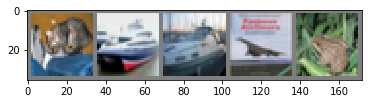

In [128]:
dataiter = iter(test_dataloader)
images, labels = dataiter.next()
img = torchvision.utils.make_grid(images[:5])
img = img / 2 + 0.5     # unnormalize
img = img.numpy()
plt.imshow(np.transpose(img, (1, 2, 0))) # tensor.permute = np.transpose


print("Class: {}\nPrediction: {}".format([test_labels_list[i] for i in range(5)], [test_preds_list[j] for j in range(5)]))

Class: ['cat', 'ship', 'ship', 'airplane', 'frog']
Prediction: ['cat', 'automobile', 'ship', 'airplane', 'frog']


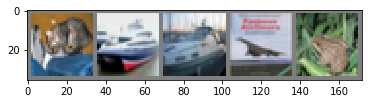

In [129]:
img = torchvision.utils.make_grid(images[:5])
img = img / 2 + 0.5     # unnormalize
img = img.numpy()
plt.imshow(np.transpose(img, (1, 2, 0))) # tensor.permute = np.transpose

label_list = list()
pred_list = list()
for i in range(5):
    label_list.append(label_dict[test_labels_list[i]])
    pred_list.append(label_dict[test_preds_list[i]])
print("Class: {}\nPrediction: {}".format([label_list[i] for i in range(5)], [pred_list[j] for j in range(5)]))

## CAM

ANS:  Cat REAL:  Cat
tensor([-0.2961, -4.5762, -0.8706,  2.5445, -3.3409,  1.3137, -4.8586,  3.9101,
        -4.0632, -2.8307], grad_fn=<SelectBackward>)
torch.Size([512, 8, 8])


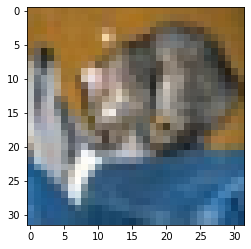

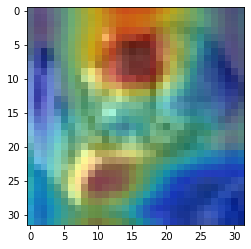

ANS:  Automobile REAL:  Ship
tensor([-0.2961, -4.5762, -0.8706,  2.5445, -3.3409,  1.3137, -4.8586,  3.9101,
        -4.0632, -2.8307], grad_fn=<SelectBackward>)
torch.Size([512, 8, 8])


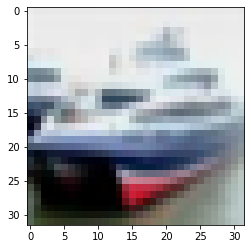

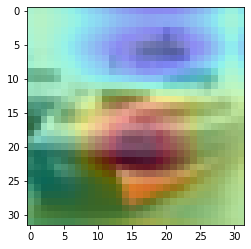

ANS:  Ship REAL:  Ship
tensor([-0.2961, -4.5762, -0.8706,  2.5445, -3.3409,  1.3137, -4.8586,  3.9101,
        -4.0632, -2.8307], grad_fn=<SelectBackward>)
torch.Size([512, 8, 8])


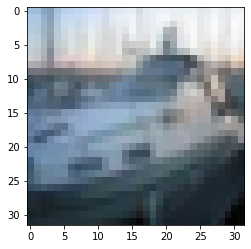

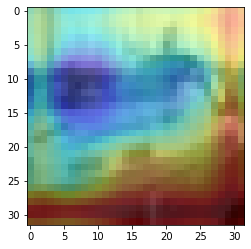

ANS:  Airplane REAL:  Airplane
tensor([-0.2961, -4.5762, -0.8706,  2.5445, -3.3409,  1.3137, -4.8586,  3.9101,
        -4.0632, -2.8307], grad_fn=<SelectBackward>)
torch.Size([512, 8, 8])


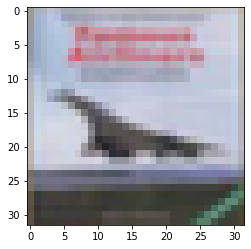

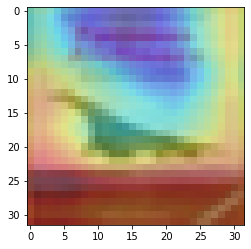

ANS:  Frog REAL:  Frog
tensor([-0.2961, -4.5762, -0.8706,  2.5445, -3.3409,  1.3137, -4.8586,  3.9101,
        -4.0632, -2.8307], grad_fn=<SelectBackward>)
torch.Size([512, 8, 8])


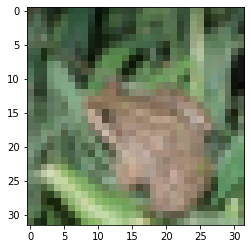

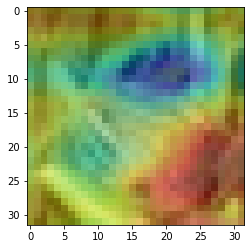

ANS:  Frog REAL:  Frog
tensor([-0.2961, -4.5762, -0.8706,  2.5445, -3.3409,  1.3137, -4.8586,  3.9101,
        -4.0632, -2.8307], grad_fn=<SelectBackward>)
torch.Size([512, 8, 8])


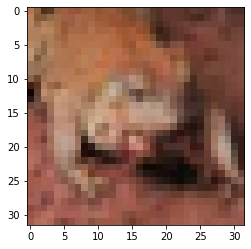

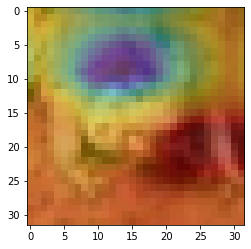

ANS:  Automobile REAL:  Automobile
tensor([-0.2961, -4.5762, -0.8706,  2.5445, -3.3409,  1.3137, -4.8586,  3.9101,
        -4.0632, -2.8307], grad_fn=<SelectBackward>)
torch.Size([512, 8, 8])


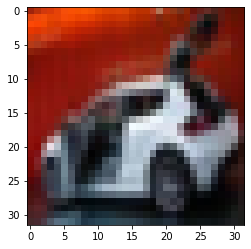

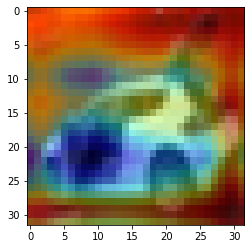

ANS:  Bird REAL:  Frog
tensor([-0.2961, -4.5762, -0.8706,  2.5445, -3.3409,  1.3137, -4.8586,  3.9101,
        -4.0632, -2.8307], grad_fn=<SelectBackward>)
torch.Size([512, 8, 8])


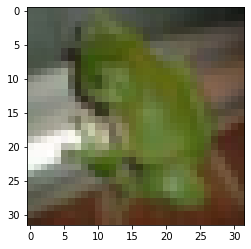

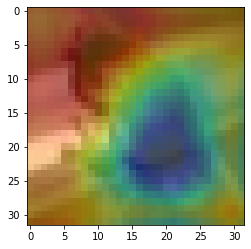

ANS:  Cat REAL:  Cat
tensor([-0.2961, -4.5762, -0.8706,  2.5445, -3.3409,  1.3137, -4.8586,  3.9101,
        -4.0632, -2.8307], grad_fn=<SelectBackward>)
torch.Size([512, 8, 8])


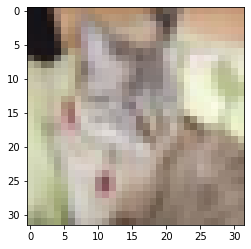

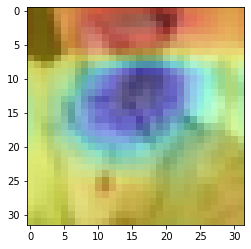

ANS:  Automobile REAL:  Automobile
tensor([-0.2961, -4.5762, -0.8706,  2.5445, -3.3409,  1.3137, -4.8586,  3.9101,
        -4.0632, -2.8307], grad_fn=<SelectBackward>)
torch.Size([512, 8, 8])


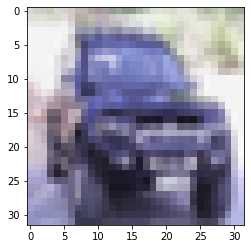

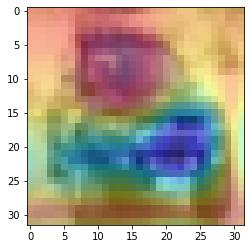

In [130]:
params = list(loaded_model.parameters())

for num in range(10):
    print("ANS: ", classes[test_preds_list[num]], "REAL: ", classes[test_labels_list[num]])
    print(test_outputs[0])
    print(f[num].shape)
    overlay = params[-2][int(test_preds_list[num])].matmul(f[num].reshape(512, 64)).reshape(8,8).cpu().detach().numpy()
    
    # Scaling
    overlay = overlay - np.min(overlay)
    overlay = overlay / np.max(overlay)
    
    img = images[num].cpu()
    img = img / 2 + 0.5     # unnormalize
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0))) # tensor.permute = np.transpose
    plt.show()
    
    img = images[num].cpu()
    img = img / 2 + 0.5     # unnormalize
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0))) # tensor.permute = np.transpose
    
    skimage.transform.resize(overlay, [32, 32])
    plt.imshow(skimage.transform.resize(overlay, [32, 32]), alpha = 0.4, cmap = 'jet')
    plt.show()

## ROC Curve

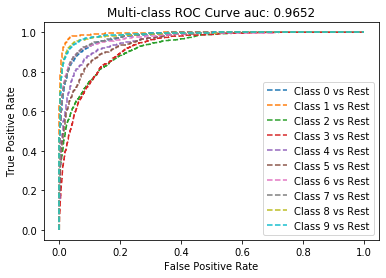

auc_score 0.9652


In [131]:
# ROC Curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr = {}
tpr = {}
thresh = {}
n_class = 10

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(test_labels_list, np.array(test_outputs_list)[:, i], pos_label=i)

# plot.
auc_score = round(roc_auc_score(test_labels_list, test_outputs_list, multi_class="ovo", average="macro"), 4)
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle="--", label=f"Class {i} vs Rest")
plt.title(f"Multi-class ROC Curve auc: {auc_score}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
img_path = os.path.join(log_dir, "Multi-class ROC Curve.png")
plt.savefig(img_path)
plt.show()

print("auc_score", auc_score)

## PCA Feature Space
PCA는 Feature Extraction의 방법이고 linear한 방법을 사용합니다.  
PCA는 원본 데이터를 저차원으로 linear mapping 합니다.   
이 방법으로 저차원에 표현되는 데이터의 variance가 최대화 됩니다.   
기본적인 방법은 공분산 행렬에서 고유벡터를 계산하는 것 입니다.   

In [132]:
from sklearn.preprocessing import StandardScaler

standardized_scalar = StandardScaler()
standardized_data = standardized_scalar.fit_transform(f_all)
standardized_data.shape

(10000, 32768)

In [ ]:
from sklearn import decomposition

pca = decomposition.PCA()
pca.n_components = 3
pca_data = pca.fit_transform(standardized_data)
pca_data.shape

In [ ]:
test_labels_list.shape

In [ ]:
pca_data = np.vstack((pca_data.T, test_labels_list)).T

In [ ]:
df_PCA = pd.DataFrame(pca_data, columns=["PC1", "PC2", "PC3", "labels"])
df_PCA.head()

In [ ]:
sns.FacetGrid(df_PCA, hue="labels", size=12).map(plt.scatter, "PC1", "PC2").add_legend()
img_path = os.path.join(log_dir, "FeatureSpace_PCA_2D.png")
plt.savefig(img_path)
plt.show()

In [ ]:
# 3차원
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
sc = ax.scatter(df_PCA['PC1'], df_PCA['PC2'], df_PCA['PC3'], c=df_PCA['labels'], cmap=cmap, alpha=1)
plt.legend(*sc.legend_elements())
img_path = os.path.join(log_dir, "FeatureSpace_PCA_3D.png")
plt.savefig(img_path)
plt.show()

## t-SNE Feature Space
t-SNE는 비선형적인 방법의 차원 축소 방법이고 특히 고차원의 데이터 셋을 시각화하는 것에 성능이 좋습니다.   
t-SNE는 다양한 분야에서 시각화 하는 데 사용되고 있습니다.   
t-SNE 알고리즘은 고차원 공간에서의 점들의 유사성과 그에 해당하는 저차원 공간에서의 점들의 유사성을 계산합니다.   
점들의 유사도는 A를 중심으로 한 정규 분포에서 확률 밀도에 비례하여 이웃을 선택하면 포인트 A가 포인트 B를 이웃으로 선택한다는 조건부 확률로 계산됩니다.   
그리고 저 차원 공간에서 데이터 요소를 완벽하게 표현하기 위해 고차원 및 저 차원 공간에서 이러한 조건부 확률 (또는 유사점) 간의 차이를 최소화하려고 시도합니다.   

>  PCA와 Local Linear Embedding은 차원 축소 방법을 선형적으로 접근하지만 T-SNE는 비선형적으로 접근하기 때문에 표현력이 증가됩니다. 따라서 위 시각화 결과와 같이 T-SNE는 클래스 간 분별력이 있게 시각화 할 수 있습니다.


In [133]:
from sklearn.manifold import TSNE

n_components = 2
tsne = TSNE(n_components=n_components)
tsne_data = tsne.fit_transform(standardized_data)
tsne_data.shape

(10000, 2)

In [134]:
tsne_data = np.vstack((tsne_data.T, test_labels_list)).T
df_tsne = pd.DataFrame(tsne_data, columns=["f1", "f2", "labels"])
df_tsne.head()

,f1,f2,labels
0,-16.285072,19.657627,3.0
1,24.094437,-53.298355,8.0
2,9.232840,-38.181187,8.0
3,24.509298,-26.282825,0.0
4,-39.615623,3.852780,6.0


In [135]:
DBI = metrics.davies_bouldin_score(df_tsne.iloc[:,:-1], df_tsne.iloc[:,2])
DBI

2.2884280846150404

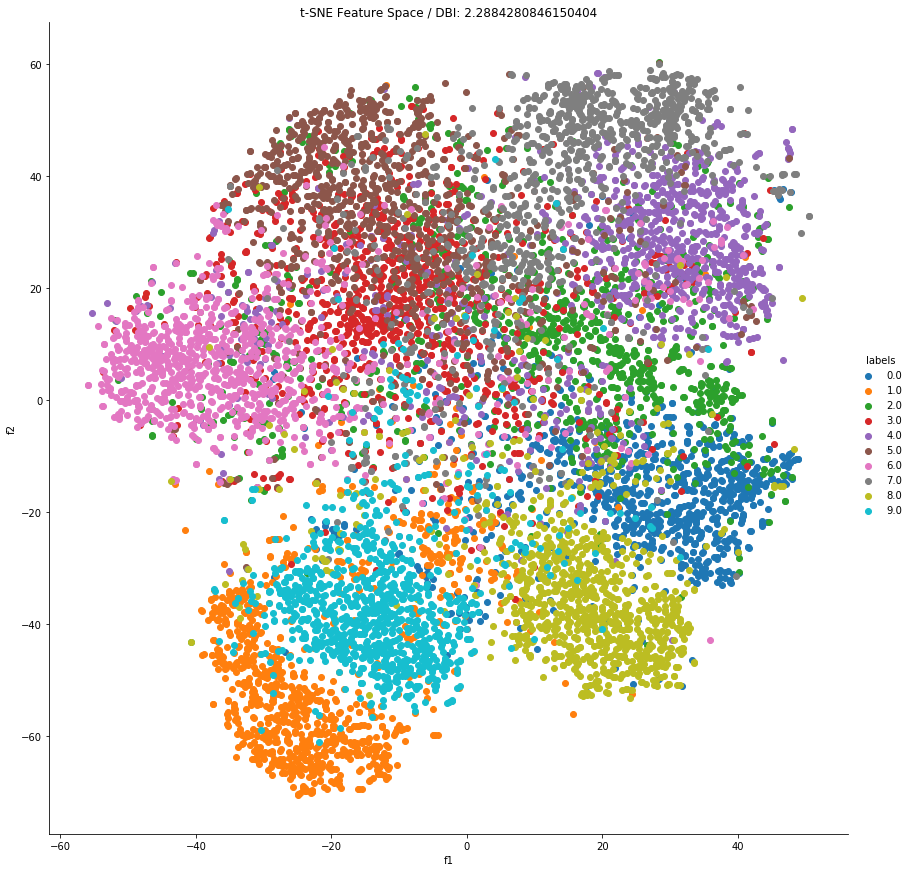

In [136]:
sns.FacetGrid(df_tsne, hue="labels", size=12).map(plt.scatter, "f1", "f2").add_legend()
plt.title(f"t-SNE Feature Space / DBI: {DBI}")
img_path = os.path.join(log_dir, "FeatureSpace_tSNE_2D.png")
plt.savefig(img_path)
plt.show()

In [107]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
sc = ax.scatter(df_tsne['f1'], df_tsne['f2'], df_tsne['f3'], c=df_tsne['labels'], cmap=cmap, alpha=1)
plt.legend(*sc.legend_elements())
img_path = os.path.join(log_dir, "FeatureSpace_tSNE_3D.png")
plt.savefig(img_path)
plt.show()

ValueError: Unknown projection '3d'

<Figure size 864x864 with 0 Axes>

* pca 보다 클래스 별로 더 잘 구분한다.

## K-Means Clustering
* K-Means는 개별 군집의 중심에서 원형의 범위에서 군집화를 수행하므로 잘 뭉쳐있는 데이터의 경우 군집화 효율이 높아진다.
![example_kmeans](https://romg2.github.io/assets/images/post_images/2021-06-17-19/output_20_0.png)
* 타원형의 가상데이터에 대해 K-Means 군집화가 잘 이루어지지 않는다.
* K-Means는 평균 거리 기반으로 군집화하므로 같은 거리상 원형으로 군집을 구성한다.
* 다음과 같은 데이터에 대해선 최적의 군집화가 어렵다.
![example_kmeans2](https://romg2.github.io/assets/images/post_images/2021-06-17-19/output_25_0.png)

In [137]:
df_for_clustering = df_tsne[df_tsne.columns.difference(['labels'])]
cluster_df = pd.DataFrame(df_tsne, columns=["f1","f2"])
df_for_clustering.head()

,f1,f2
0,-16.285072,19.657627
1,24.094437,-53.298355
2,9.232840,-38.181187
3,24.509298,-26.282825
4,-39.615623,3.852780


In [ ]:
from sklearn.cluster import KMeans

# KMeans
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans_label = kmeans.fit_predict(df_for_clustering)

# 군집 레이블 추가
cluster_df['labels'] = df_tsne['labels']
cluster_df["kmeans_label"] = kmeans_label

# 군집분석 시각화
#visualize_cluster_plot(kmeans, cluster_df, "kmeans_label", iscenter=True)
sns.FacetGrid(cluster_df, hue="kmeans_label", size=12).map(plt.scatter, "f1", "f2").add_legend()
img_path = os.path.join(log_dir, "KMeans_tSNE_2D.png")
plt.savefig(img_path)
plt.show()

## GMM Clustering
* GMM은 데이터가 여러 개의 정규 분포를 가진 데이터 집합들이 섞여서 생성된 것이라는 가정하에 군집화를 수행한다.
* GMM은 여러 개의 정규 분포 곡선을 추출하고, 개별 데이터가 그 중 어떤 정규 분포에 속하는지 결정한다.
* 이와 같은 방식은 GMM에서는 모수 추정이라고 하는데, 모수 추정은 대표적으로 2가지를 추정한다.
    * 개별 정규 분포의 평균과 분산
    * 각 데이터가 어떤 정규 분포에 해당되는지의 확률
* 모수 추정을 위해 GMM은 EM(Expectation and Maximization) 방법을 적용한다.
* 따라서 GMM은 다음과 같은 데이터 분포에서도 잘 작동한다.
![example_gmm](https://romg2.github.io/assets/images/post_images/2021-06-17-19/output_28_0.png)

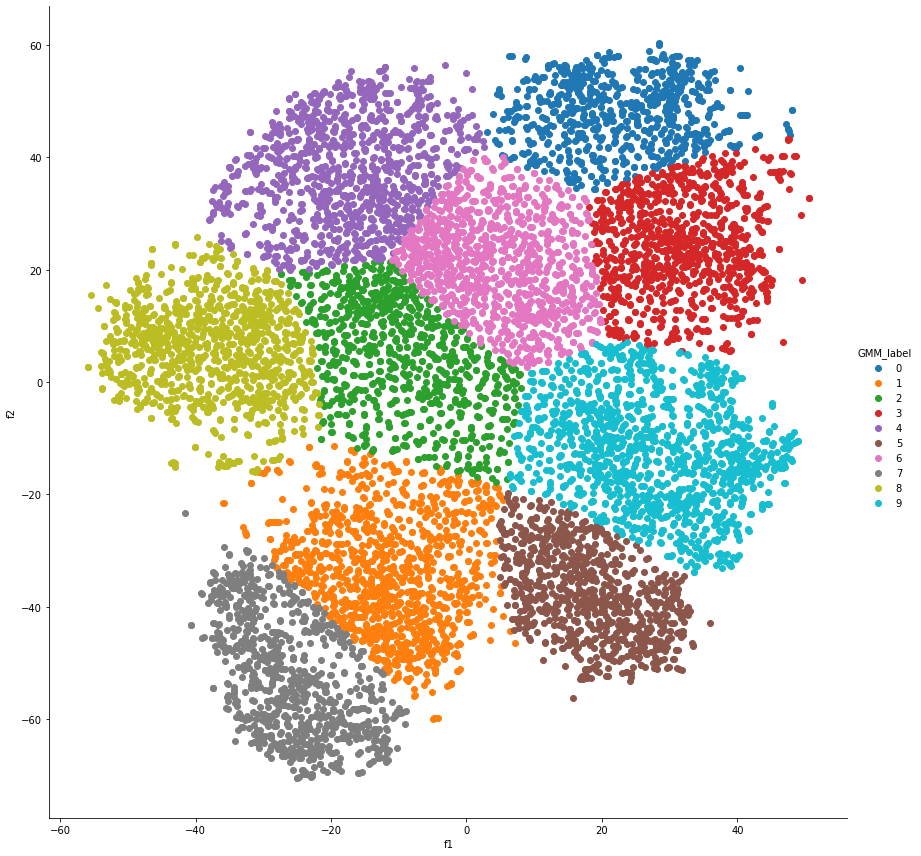

In [138]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10, random_state=0)
gmm_label = gmm.fit_predict(df_for_clustering)

# 군집 레이블 추가
cluster_df["GMM_label"] = gmm_label

# 군집분석 시각화
#visualize_cluster_plot(kmeans, cluster_df, "kmeans_label", iscenter=True)
sns.FacetGrid(cluster_df, hue="GMM_label", size=12).map(plt.scatter, "f1", "f2").add_legend()
img_path = os.path.join(log_dir, "GMM_tSNE_2D.png")
plt.savefig(img_path)
plt.show()